## Esame Time Series Analysis
Marco Bolpagni - 22/12/2020

## Indice
1. [Obiettivi e caricamento librerie](#1-Obiettivi-e-caricamento-librerie)
2. [Contesto e analisi esplorativa](#2-Contesto-e-analisi-esplorativa)
3. [Modello lineare](#3-Modello-lineare)
4. [Punti di rottura della serie storica](#4-Punti-di-rottura-della-serie-storica)
5. [Modello additivo: studio delle componenti della serie storica](#5-Modello-additivo:-studio-delle-componenti-della-serie-storica)
6. [Modello *SARIMA* e Forecast](#6-Modello-SARIMA-e-Forecast)

## 1 Obiettivi e caricamento librerie

### 1.1 Consegna
* Analizzare al meglio delle possibilità la time series *ausbeer* *(Quarterly Australian Beer Production)* contenuta nel pacchetto *fpp2*

### 1.2 Obiettivi personali
Oltre allo svolgimento della consegna secondo quanto visto a lezione mi piacerebbe:
* inserire un'introduzione esplorativa e di contesto sulla serie storica
* riuscire a gestire l'intero flusso dello studio della serie storica con il solo utilizzo della struttura ts e dei plot nativi (opportunamente modificati nello stile)
* riuscire a unire scelte matematiche con criteri di analisi dei fenomeni
* provare, in una seconda fase, a utilizzare il modello sarima per togliere anche la componente stagionale della serie e fare il forecasting (come materiale di approfondimento ho usato il corso [*STAT 510: Applied Time Series Analysis*](https://online.stat.psu.edu/stat510/) della *Penn State University*)

### 1.3 Caricamento librerie

In [92]:
# librerie
library("moments")
library("lmtest")
library("strucchange")
library("fpp2")
library("repr")
library("WDI")
library("dplyr")
library("astsa")
library("stats")
library("fBasics")
library("tseries")
library("car")

# Imposto dimensione dei plot (16 x 8)
options(repr.plot.width=16, repr.plot.height=8)
# escludo warning dall'output
options(warn=-1)

## 2 Contesto e analisi esplorativa

### 2.1 La serie storica ausbeer

La serie storica assegnata riguarda la produzione di birra in Australia dall'inizio del 1956 a metà del 2010. I dati sono forniti dall'*Australian Bureau of Statistics* e hanno cadenza trimestrale. Si tratta dunque di un fenomeno socio-economico che comprende tanto le dinamiche economiche quanto quelle sociali. La produzione e il consumo di alcolici infatti sono stati al centro di campagne pubbliche e di interventi da parte del decisore politico sin dalla metà del secolo scorso [^1]. Tutto ciò potrebbe avere influenzato in modo più o meno diretto la nostra serie storica e avere eventualmente introdotto alcuni punti di rottura. Oltre a tutti questi aspetti, la serie storica fornisce un'idea sulle abitudini di consumo di birra in Australia (se consideriamo un mercato tendenzialmente isolato e una situazione standard in cui il volume della produzione è in relazione a quello dei consumi).

[^1]: Lewis, M. (1988). Alcoholism in Australia, the 1880s to the 1980s: from medical science to political science. Drug and Alcohol Review, 7(4), 391–401.

### 2.2 Il dataset: organizzazione e valori mancanti

In [2]:
head(ausbeer, 8)

,Qtr1,Qtr2,Qtr3,Qtr4
1956,284,213,227,308
1957,262,228,236,320


In [3]:
sum(is.na(ausbeer))

[1] 0

Come anticipato dalla descrizione della serie storica essa è organizzata in trimetristri e inserita in un oggetto *ts()*. Non sono presenti elementi mancanti (*NA*)

### 2.3 Plot e analisi grafica

Come primo passo per studiare la serie storica disegno sia uno scatterplot che un lineplot per avere un'informazione grafica completa. Per completezza sono state aggiunte la linea della regressione lineare e della LOESS che forniscono un'idea sull'andamento globale e locale della serie storica.

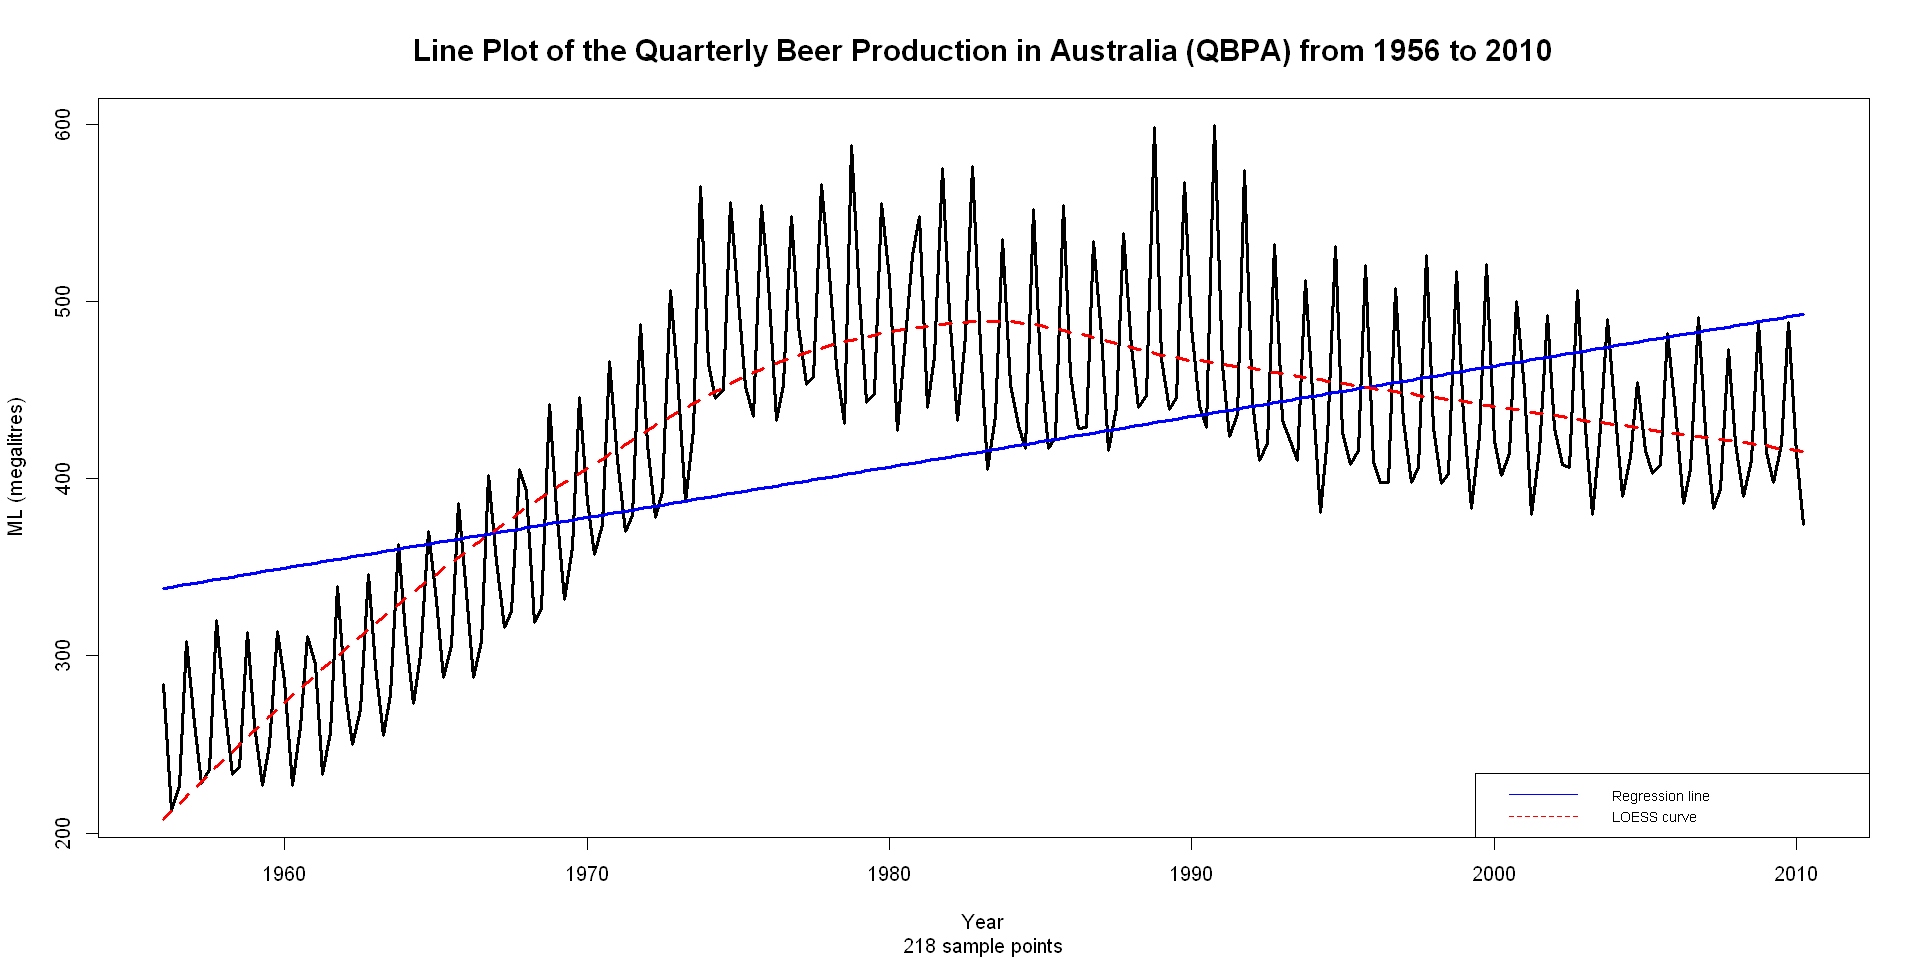

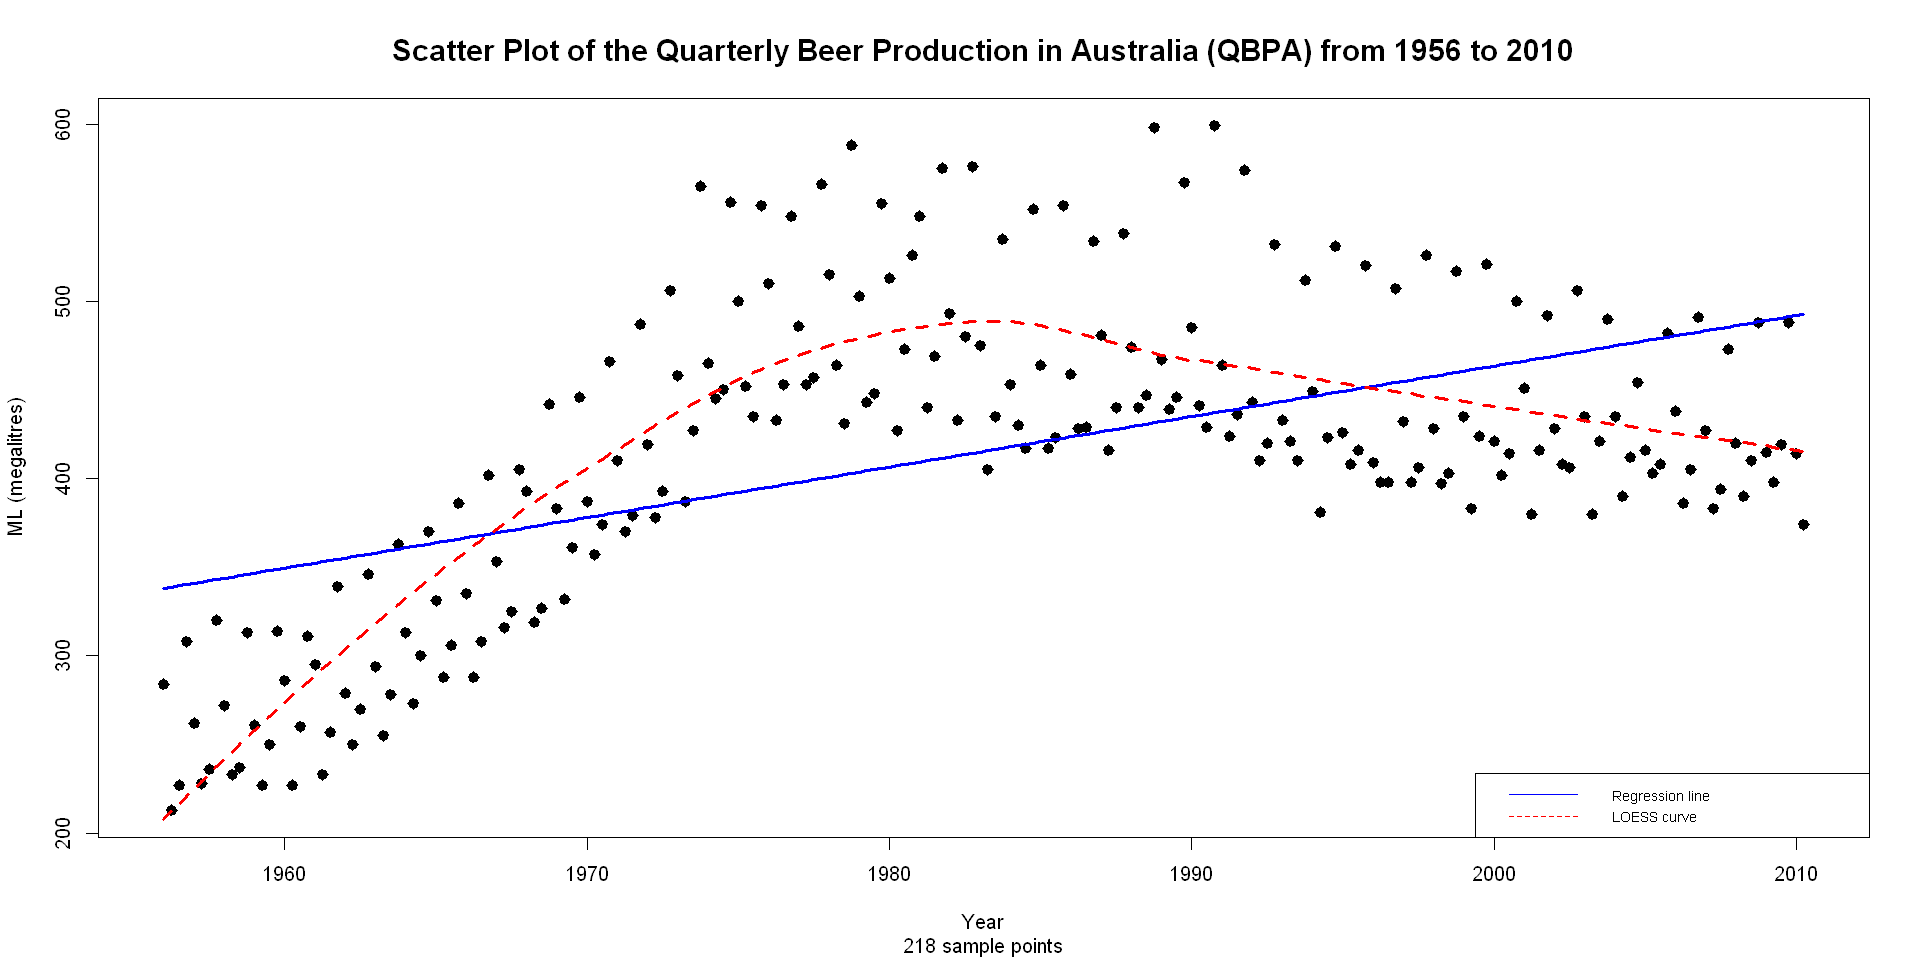

In [4]:
#line plot
plot(ausbeer, type="l", lwd=3,
     main = "Line Plot of the Quarterly Beer Production in Australia (QBPA) from 1956 to 2010",
     sub = paste(length(ausbeer), "sample points", sep=" "),
     xlab = "Year", ylab = "ML (megalitres)", 
     cex.axis=0.5, cex.main= 1.5, cex.sub = 1, cex.lab = 0.5)
loess.fit <- ts(loess(coredata(ausbeer) ~ index(ausbeer), span = 0.8)$fitted, start = 1956, frequency = 4)
lm.fit <- ts(lm(coredata(ausbeer) ~ index(ausbeer))$fitted.values, start = 1956, frequency = 4)
lines(lm.fit, col = "blue", , lwd=3)
lines(loess.fit, col = "red", lty=2, , lwd=3)
legend("bottomright", legend = c("Regression line", "LOESS curve"), cex = 0.7, col = c("blue","red"), lty=c(1,2))

#scatter plot
plot(ausbeer, type="p", lwd=3, pch = 10, 
     main = "Scatter Plot of the Quarterly Beer Production in Australia (QBPA) from 1956 to 2010",
     sub = paste(length(ausbeer), "sample points", sep=" "),
     xlab = "Year", ylab = "ML (megalitres)", 
     cex.axis=0.5, cex.main= 1.5, cex.sub = 1, cex.lab = 0.5)
loess.fit <- ts(loess(coredata(ausbeer) ~ index(ausbeer), span = 0.8)$fitted, start = 1956, frequency = 4)
lm.fit <- ts(lm(coredata(ausbeer) ~ index(ausbeer))$fitted.values, start = 1956, frequency = 4)
lines(lm.fit, col = "blue", lwd=3)
lines(loess.fit, col = "red", lty=2, lwd=3)
legend("bottomright", legend = c("Regression line", "LOESS curve"), cex = 0.7, col = c("blue","red"), lty=c(1,2))

Dall'analisi grafica il fenomeno sottostante alla serie storica sembra scandito da tre fasi; una prima fase di crescita (apparentemente lineare) seguita da un rallentamento tra gli anni '80 e '90 che culmina in un trend decrescente nelle decadi successive. La natura della serie storica appare quindi non lineare (con una componente parabolica abbastanza marcata, apprezzabile dal confronto tra la retta di regressione lineare e la loess). Anche la varianza ha un comportamento interessante: globalmente non sembra essere costante (indizio di eteroschedasticità), tuttavia, all'interno delle tre fasi individuate (1956-1980, 1980-1990 e 1990-2010) la situazione sembra essere abbastanza omogenea. All'interno della serie storica inoltre è presente una componente stagionale.

Un'informazione di contesto interessante è che proprio a cavallo tra gli anni '70 e gli anni '80 il governo Australiano ha introdotto la *Drug and Alcohol Authority*, un organo deputato alla gestione del fenomeno del consumo eccessivo di bevande alcoliche.

In massima sintesi la serie storica sembra presentare evidenze grafiche di non stazionarietà, eteroschedasticità, stagionalità e possibile presenza di breakpoint.

### 2.4 Approfondimento sulla stagionalità

Data la presenza di stagionalità, è stato deciso di costruire un grafico per descrivere più in dettaglio l'andamento della produzione di birra nei trimestri

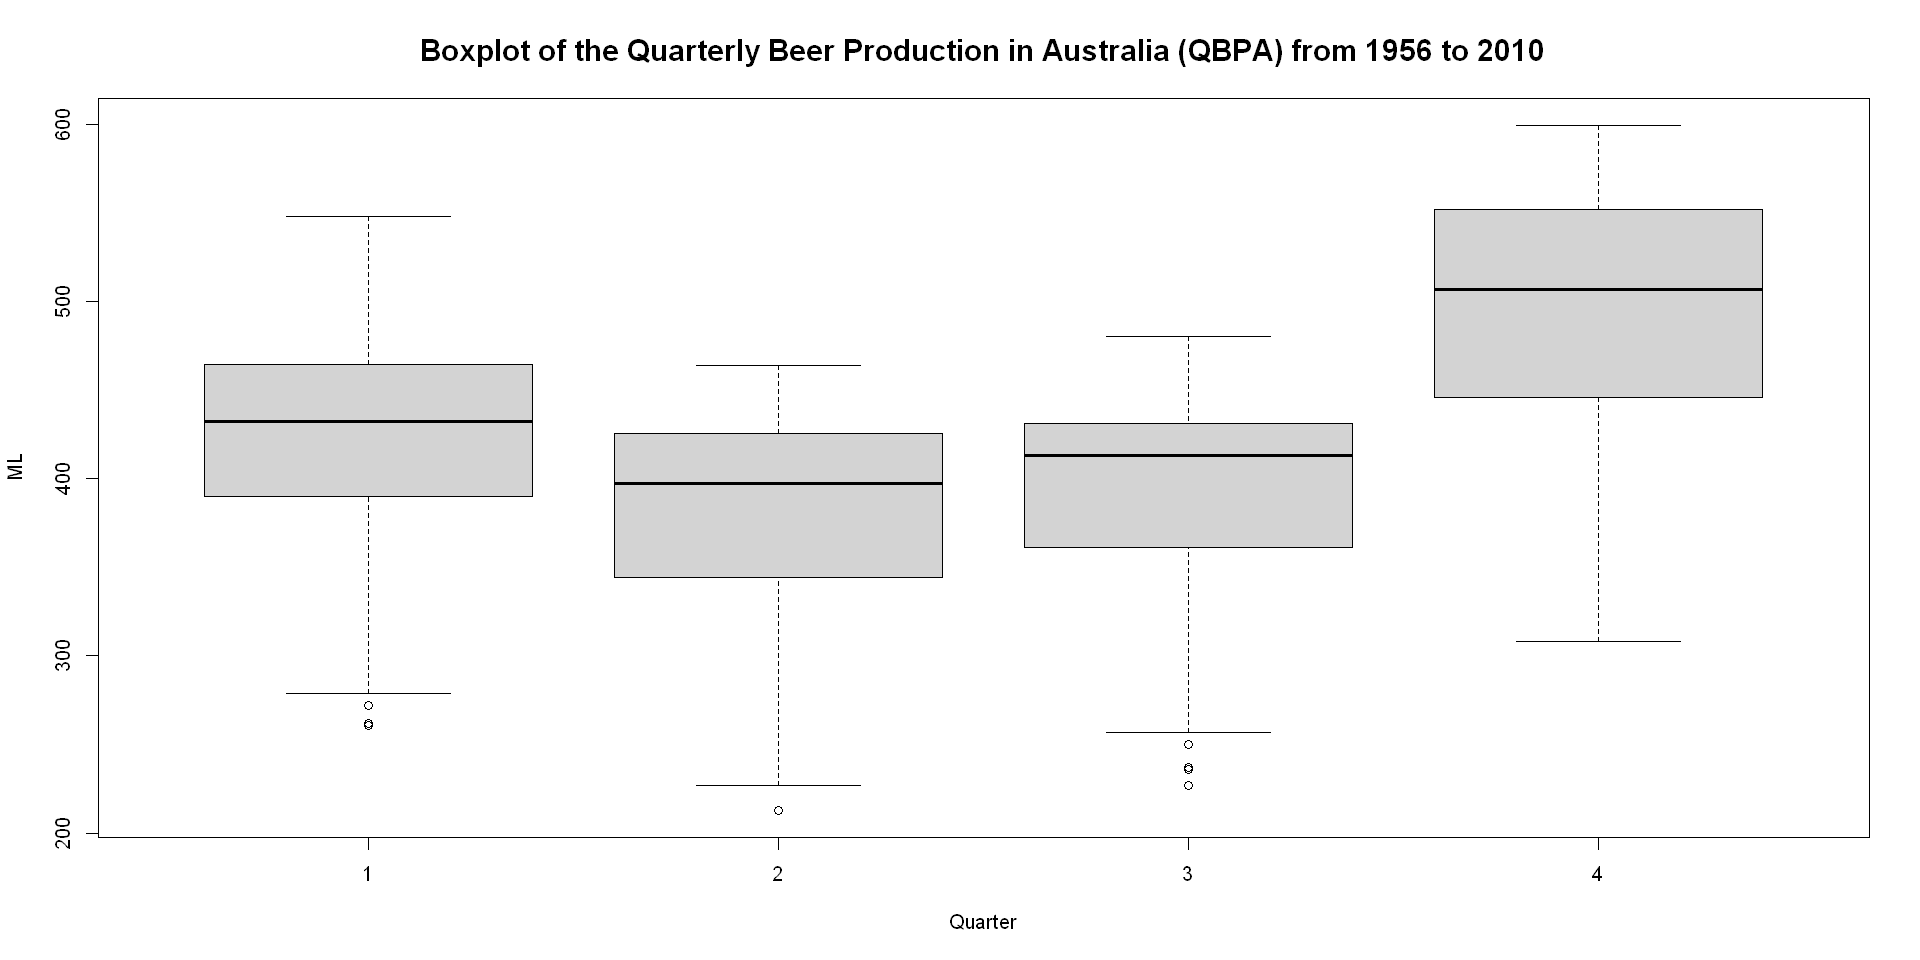

In [5]:
boxplot(ausbeer ~ cycle(ausbeer), 
        xlab = "Quarter", ylab = "ML", 
        main = "Boxplot of the Quarterly Beer Production in Australia (QBPA) from 1956 to 2010", 
        cex.axis=1, cex.main= 1.5, cex.lab = 1)

Dal boxplot si evince una maggiore produzione nel quarto trimestre dell'anno, seguita da quella del primo trimestre. I trimestri centrali si attestano su livelli simili anche se il terzo trimestre presenza un numero maggiore di outlier. I periodi in cui viene prodotta più birra (trimestri 3 e 4) coincidono con la primavera-estate australiana.

### 2.5 Impatto della popolazione sul fenomeno descritto dalla serie storica

Le serie storiche che descrivono caratteri socioeconomici possono essere impattate da fenomeni come la crescita della popolazione. Se diamo uno sguardo ai dati sulla popolazione dell'Australia ci si può accorgere che nel periodo considerato (1956-2010) la popolazione è più che raddoppiata; ho deciso dunque di utilizzare la popolazione come fattore di correzione per creare un grafico che mi permetta di avere un'idea più chiara dell'andamento dell'industria della birra e della sua produzione.

*Nota metodologica: i dati sulla popolazione australiana sono stati scaricati dal database della World Bank attraverso il pacchetto "WDI". I dati sulla popolazione offerti dalla World Bank tuttavia partono dal 1960 ed è stato necessario stimare i dati riguardanti gli anni precedenti attraverso un modello lineare*

In [6]:
auspop <- WDI(indicator='SP.POP.TOTL', country="AU", start=1960, end=2010)

pop.lm <- lm(auspop$SP.POP.TOTL ~ auspop$year)
iso2c <- c()
country <- c()
SP.POP.TOTL <- c()
year <- c()
for(i in 1956:1959) {
  val <- pop.lm$coefficients[1]+pop.lm$coefficients[2]*i
  iso2c <- append(iso2c, "AU", after = length(iso2c))
  country <- append(country, "Australia", after = length(country))
  SP.POP.TOTL <- append(SP.POP.TOTL, val, after = length(SP.POP.TOTL))
  year <- append(year, i, after = length(year))
}
pop.lm.df <- data.frame(iso2c, country, SP.POP.TOTL, year)
auspop <- auspop %>% arrange(desc(row_number()))
auspop <- bind_rows(pop.lm.df, auspop)
auspop <- auspop %>% select(SP.POP.TOTL,year) %>% slice(rep(1:n(), each = 4)) %>% as.data.frame()
auspop <- ts(auspop$SP.POP.TOTL, start=c(1956, 1), end=c(2010, 4), frequency=4)

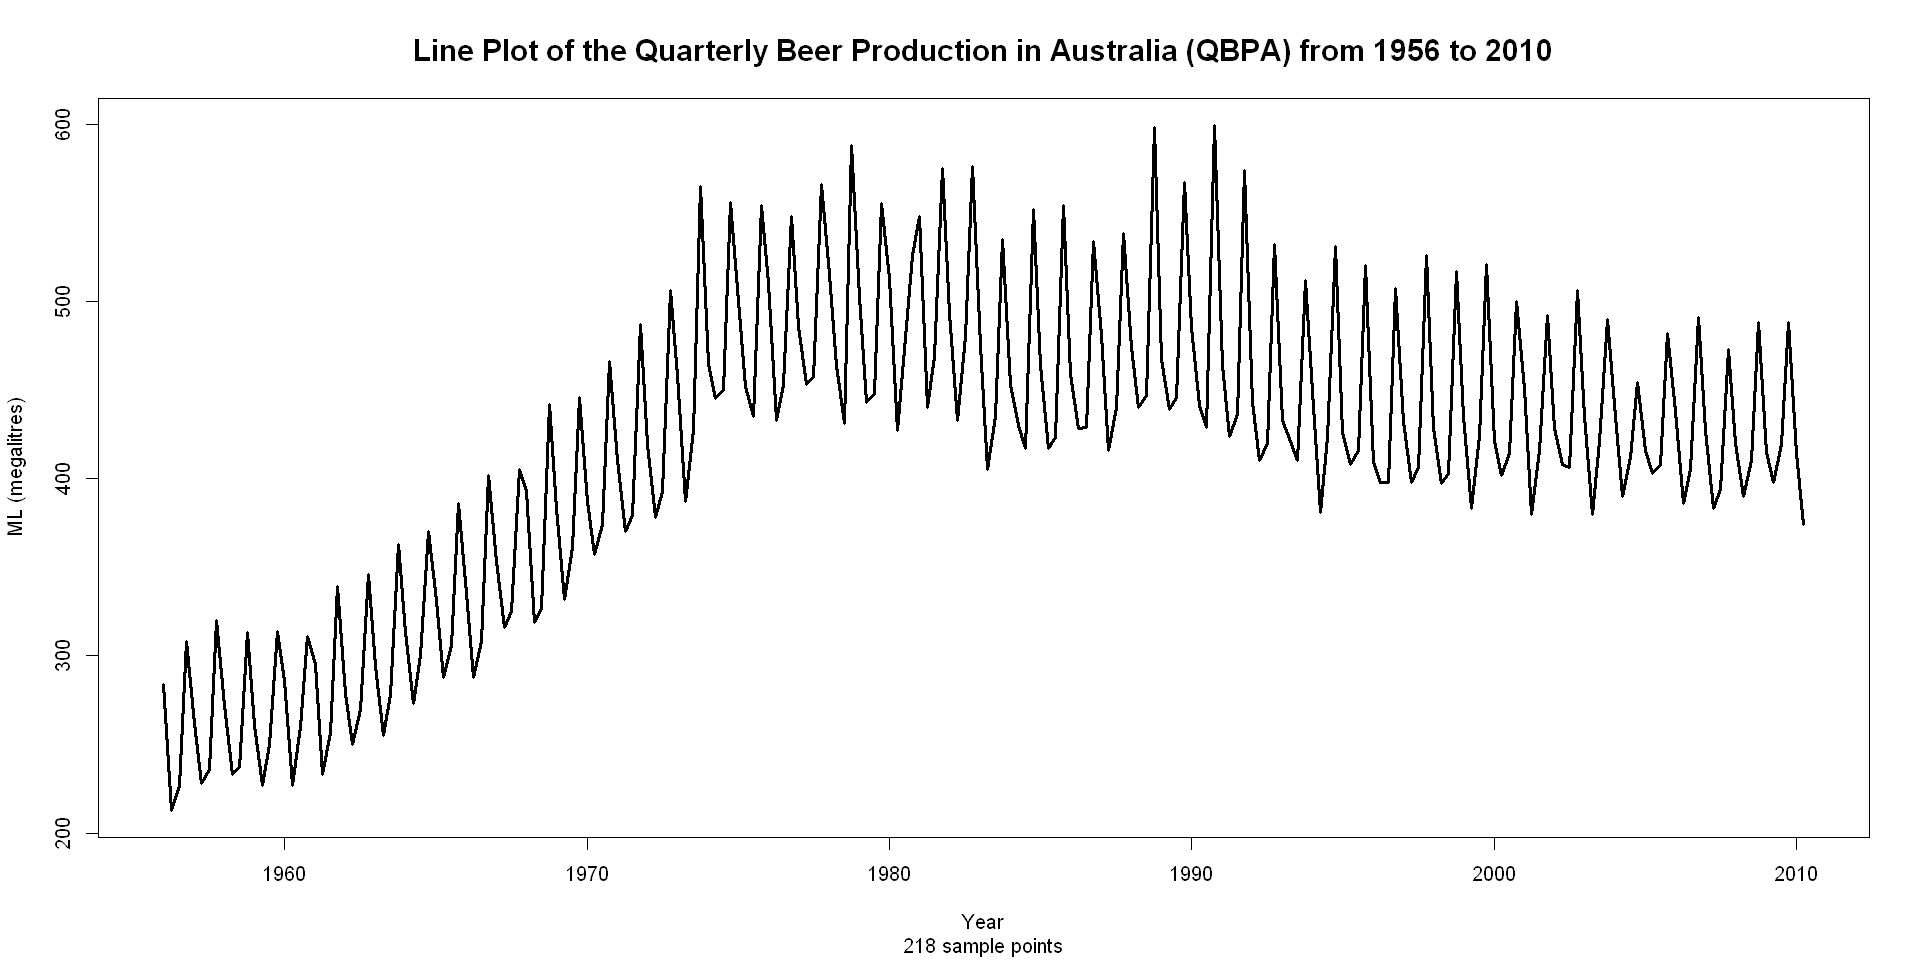

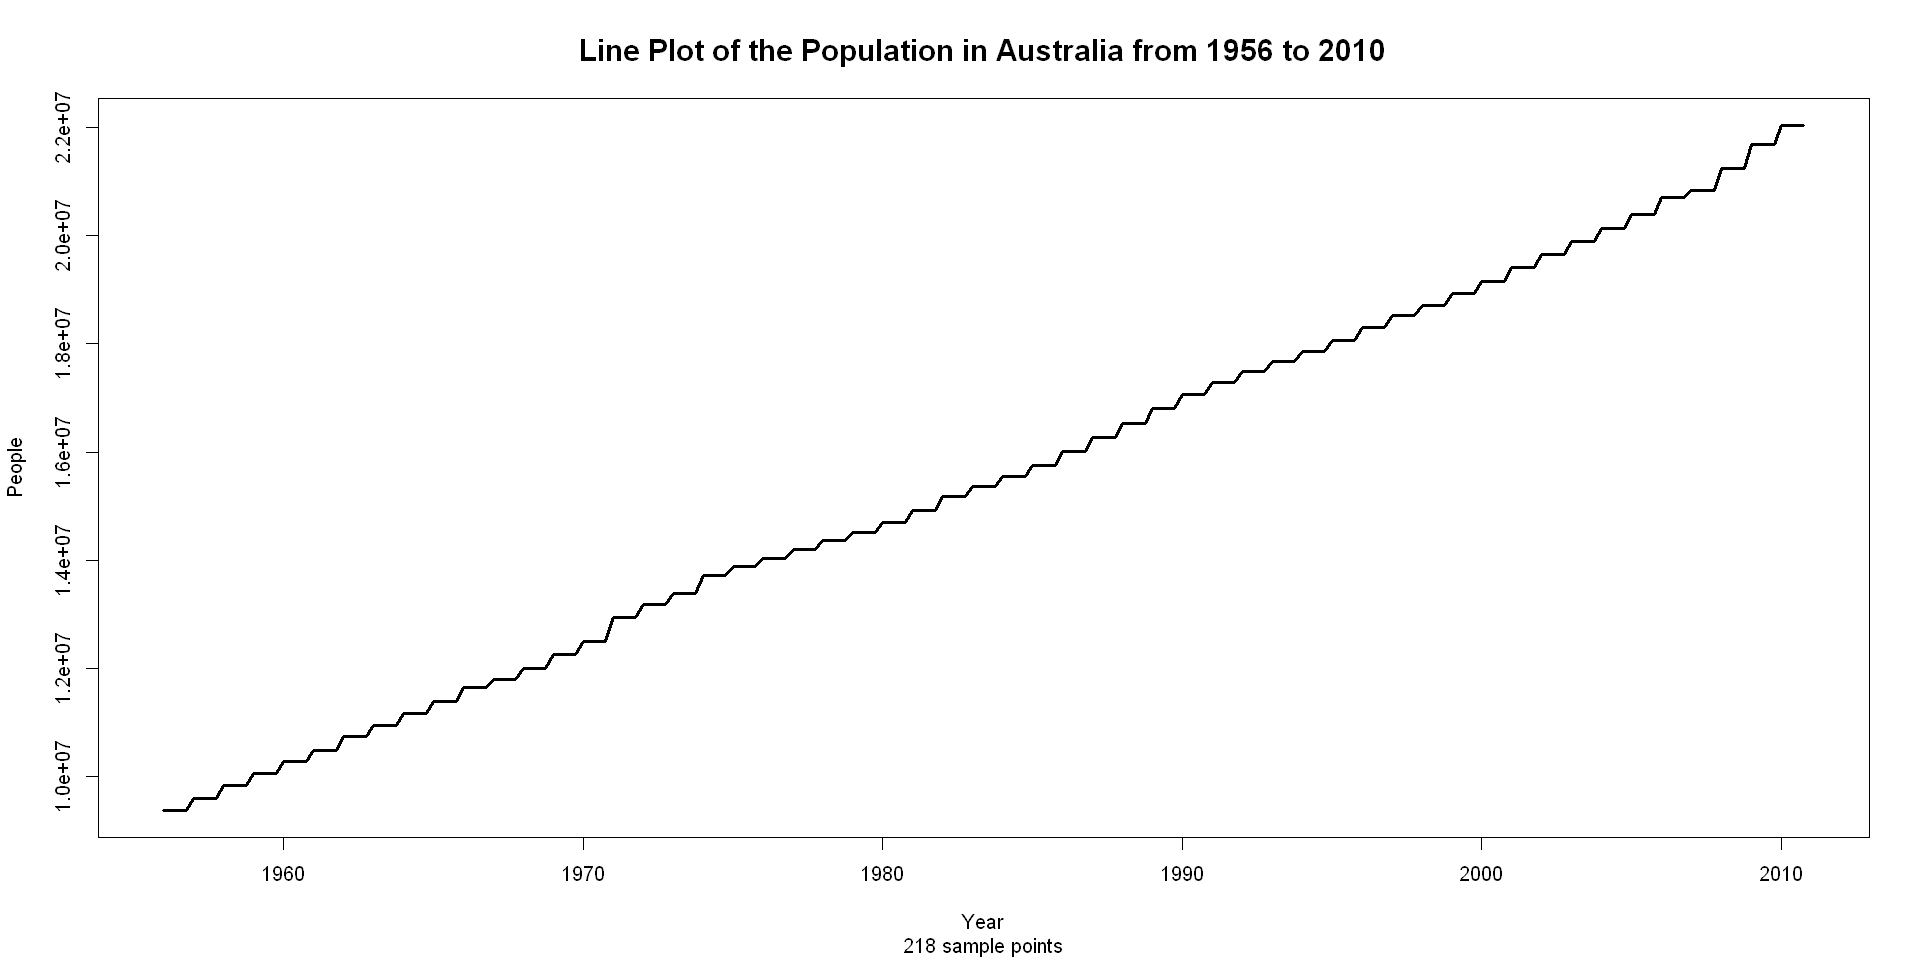

In [7]:
#line plot
plot(ausbeer, type="l", lwd=3,
     main = "Line Plot of the Quarterly Beer Production in Australia (QBPA) from 1956 to 2010",
     sub = paste(length(ausbeer), "sample points", sep=" "),
     xlab = "Year", ylab = "ML (megalitres)", 
     cex.axis=0.5, cex.main= 1.5, cex.sub = 1, cex.lab = 0.5)

#line plot
plot(auspop, type="l", lwd=3,
     main = "Line Plot of the Population in Australia from 1956 to 2010",
     sub = paste(length(ausbeer), "sample points", sep=" "),
     xlab = "Year", ylab = "People", 
     cex.axis=0.5, cex.main= 1.5, cex.sub = 1, cex.lab = 0.5)

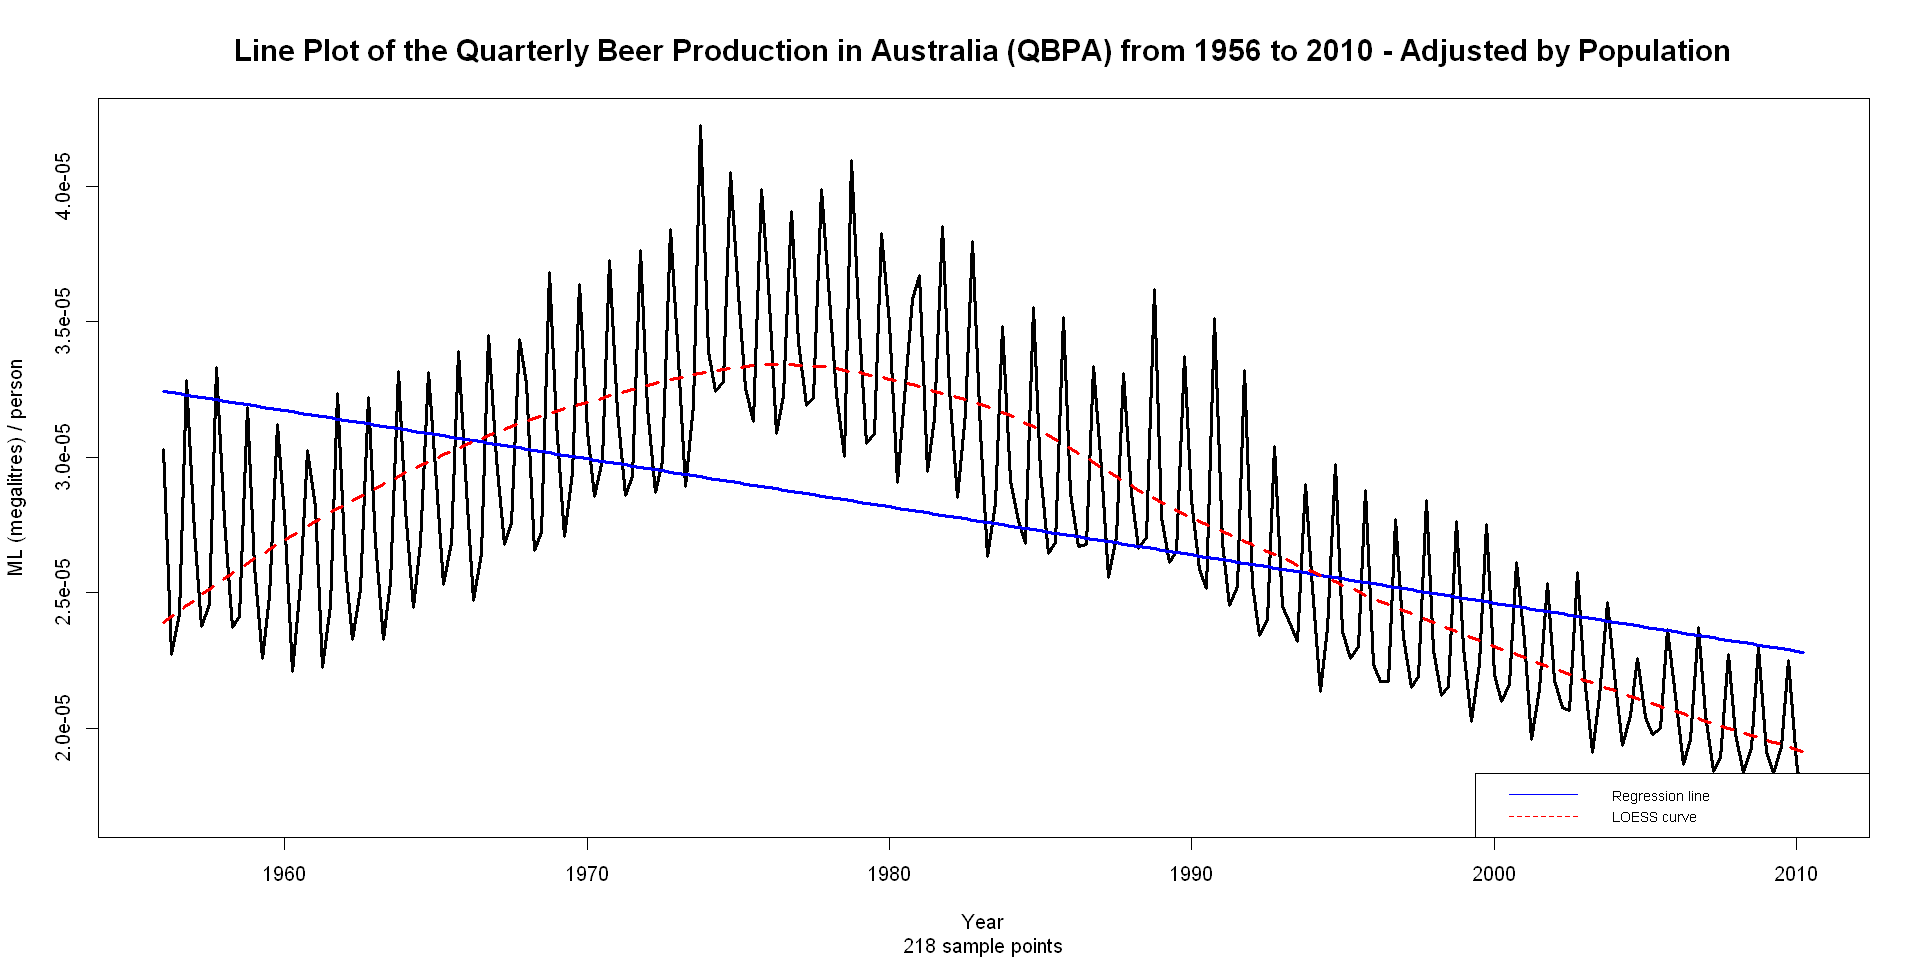

In [8]:
#line plot
plot(ausbeer/auspop, type="l", lwd=3,
     main = "Line Plot of the Quarterly Beer Production in Australia (QBPA) from 1956 to 2010 - Adjusted by Population",
     sub = paste(length(ausbeer), "sample points", sep=" "),
     xlab = "Year", ylab = "ML (megalitres) / person", 
     cex.axis=0.5, cex.main= 1.5, cex.sub = 1, cex.lab = 0.5)
loess.fit <- ts(loess(coredata(ausbeer/auspop) ~ index(ausbeer/auspop), span = 0.8)$fitted, start = 1956, frequency = 4)
lm.fit <- ts(lm(coredata(ausbeer/auspop) ~ index(ausbeer/auspop))$fitted.values, start = 1956, frequency = 4)
lines(lm.fit, col = "blue", , lwd=3)
lines(loess.fit, col = "red", lty=2, , lwd=3)
legend("bottomright", legend = c("Regression line", "LOESS curve"), cex = 0.7, col = c("blue","red"), lty=c(1,2))

La correzione permette di rappresentare in modo più evidente quanto emerso dalla serie originale ovvero la presenza di una prima fase di crescita del settore della produzione della birra sul territorio australiano, seguita da un declino pressochè costante e consistente. Da metà degli anni '90 il quantitativo di birra prodotta per persona ha raggiunto livelli inferiori a quelli del 1956 (prima del boom produttivo). Il trend globale della serie storica corretta risulta essere discendente fornendo la fotografia di un settore in declino.

La serie storica corretta, come quella originale, sembra presentare evidenze grafiche di non stazionarietà, eteroschedasticità, stagionalità e possibile presenza di breakpoint.

[Torna all'indice](#Indice)

### 3 Modello lineare

Anche se per nulla promettente in ottica predittiva (per via della non linearità emersa dall'analisi grafica), come primo approccio allo studio della serie storica è stato applicato un modello lineare semplice per avere un'inisght più profondo sulla natura e sulle caratteristiche della serie storica in analisi.

Per verificare la bontà del modello lineare e i suoi limiti è stato scelto di analizzare, sia da un punto di vista grafico che da un punto di vista numerico, le proprietà dei residui: 
* gaussianità
* stazionarietà
* scorrelazione
* omoschedasticità

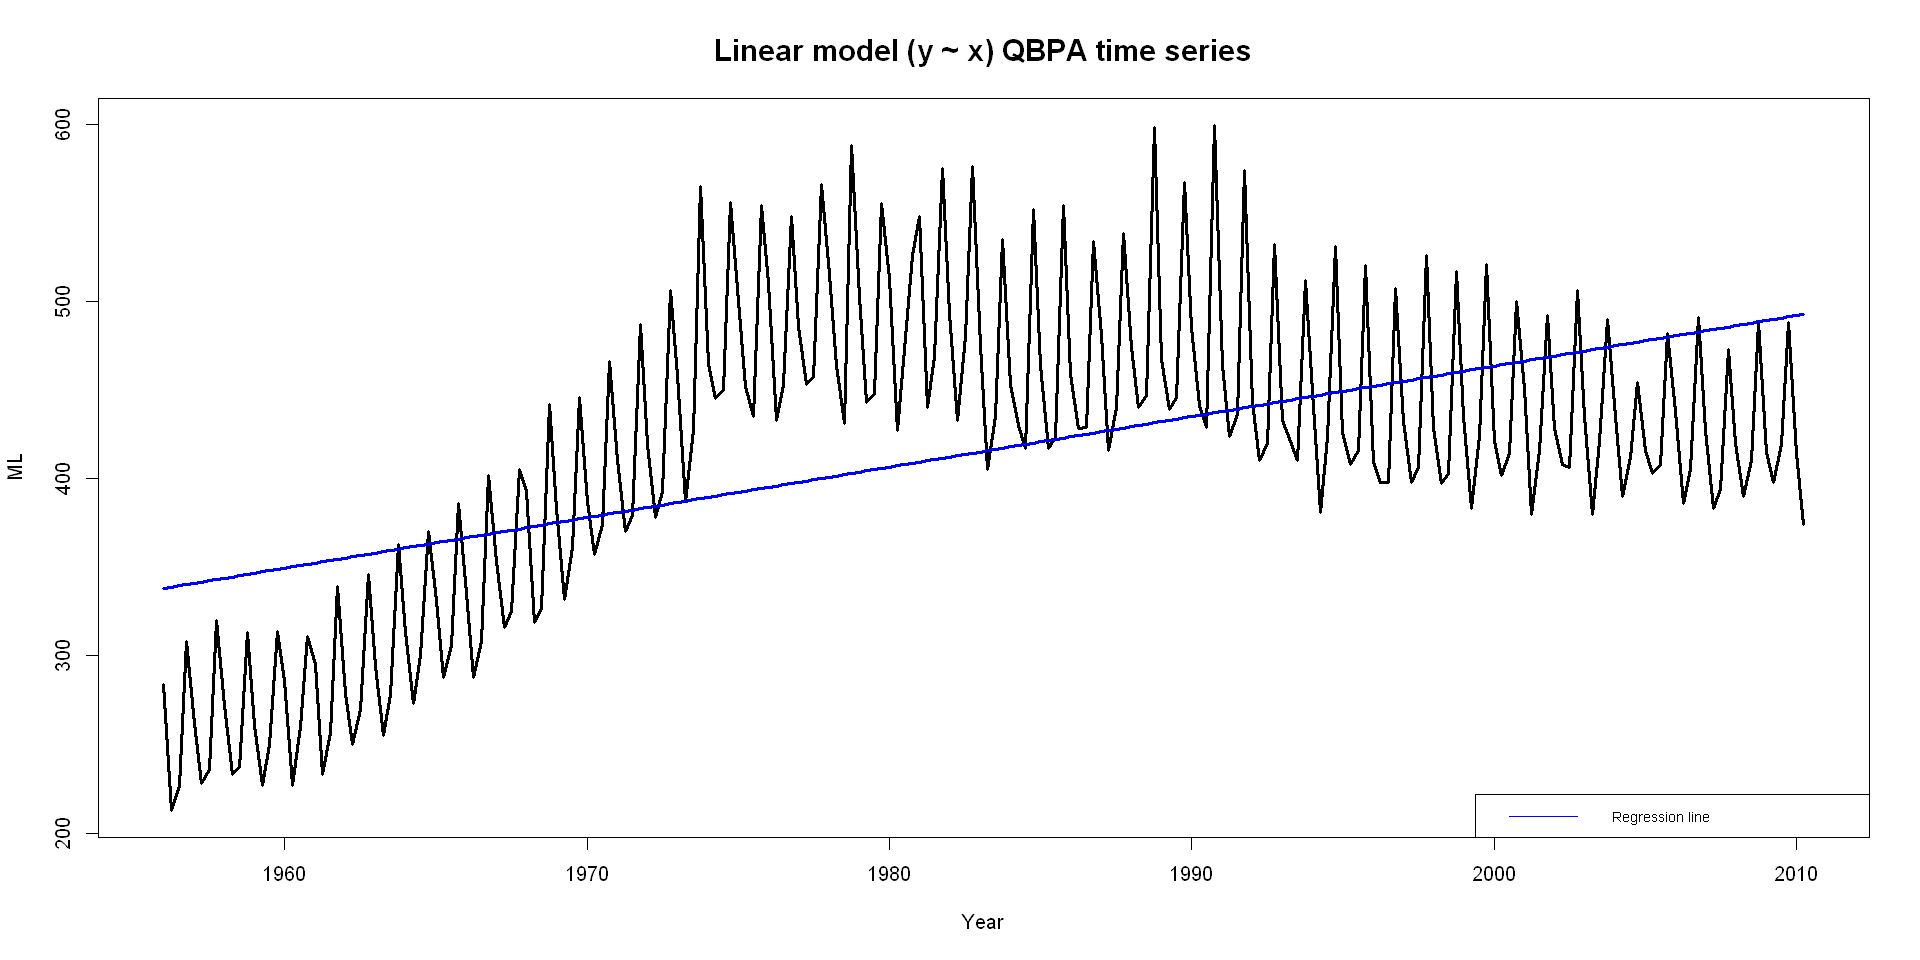

In [9]:
plot(ausbeer, type="l", lwd=3,
     main = "Linear model (y ~ x) QBPA time series", 
     xlab = "Year", ylab = "ML",
     cex.axis=0.5, cex.main= 1.5, cex.sub = 1, cex.lab = 0.5)
lm.fit <- ts(lm(coredata(ausbeer) ~ index(ausbeer))$fitted.values, start = 1956, frequency = 4)
lines(lm.fit, col = "blue", lwd=3)
legend("bottomright", legend = c("Regression line"), cex = 0.7, col = c("blue"), lty=1)

In [10]:
ausbeer.lm <- lm(coredata(ausbeer) ~ index(ausbeer))
summary(ausbeer.lm)


Call:
lm(formula = coredata(ausbeer) ~ index(ausbeer))

Residuals:
     Min       1Q   Median       3Q      Max 
-125.830  -57.111   -6.887   48.722  185.089 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)    -5232.6634   626.4127  -8.353 8.02e-15 ***
index(ausbeer)     2.8480     0.3159   9.017  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 73.37 on 216 degrees of freedom
Multiple R-squared:  0.2735,	Adjusted R-squared:  0.2701 
F-statistic:  81.3 on 1 and 216 DF,  p-value: < 2.2e-16


### 3.1 Gaussianità dei residui

Come primo passo per la valutazione della gaussianità definisco una funzione per determinare i valori teorici in una situazione di residui normalmente distribuiti

In [11]:
theo.residuals <- function(lm){
  se <- sigma(lm)
  theo.min <- round(-3*se,3)
  theo.max <- round(3*se,3)
  theo.1Q <- round(qnorm(0.25, mean = 0 , sd = se, lower.tail = T),3)
  theo.median <- 0
  theo.3Q <- round(qnorm(0.75, mean = 0 , sd = se, lower.tail = T),3)
  print(cbind(theo.min,theo.1Q, theo.median , theo.3Q , theo.max))
}

In [12]:
theo.residuals(ausbeer.lm)

     theo.min theo.1Q theo.median theo.3Q theo.max
[1,] -220.114 -49.488           0  49.488  220.114


Confrontando i residui osservati con quelli teorici di una distribuzione normale si può apprezzare che la distribuzione si discosta da quella gaussiana.

Per approfondire questo aspetto e raccogliere ulteriori evidenze numeriche calcolo l'asimmetria e la curtosi

In [13]:
ausbeer.lm.skew <- skewness(ausbeer.lm$residuals)
ausbeer.lm.kurt <- kurtosis(ausbeer.lm$residuals)
print(cbind(ausbeer.lm.skew,ausbeer.lm.kurt))

     ausbeer.lm.skew ausbeer.lm.kurt
[1,]       0.5123544      -0.4343608


La distribuzione appare platicurtica e presenta una lieve asimmetria positiva; per visualizzare meglio queste caratteristiche decido di rappresentarla su un grafico

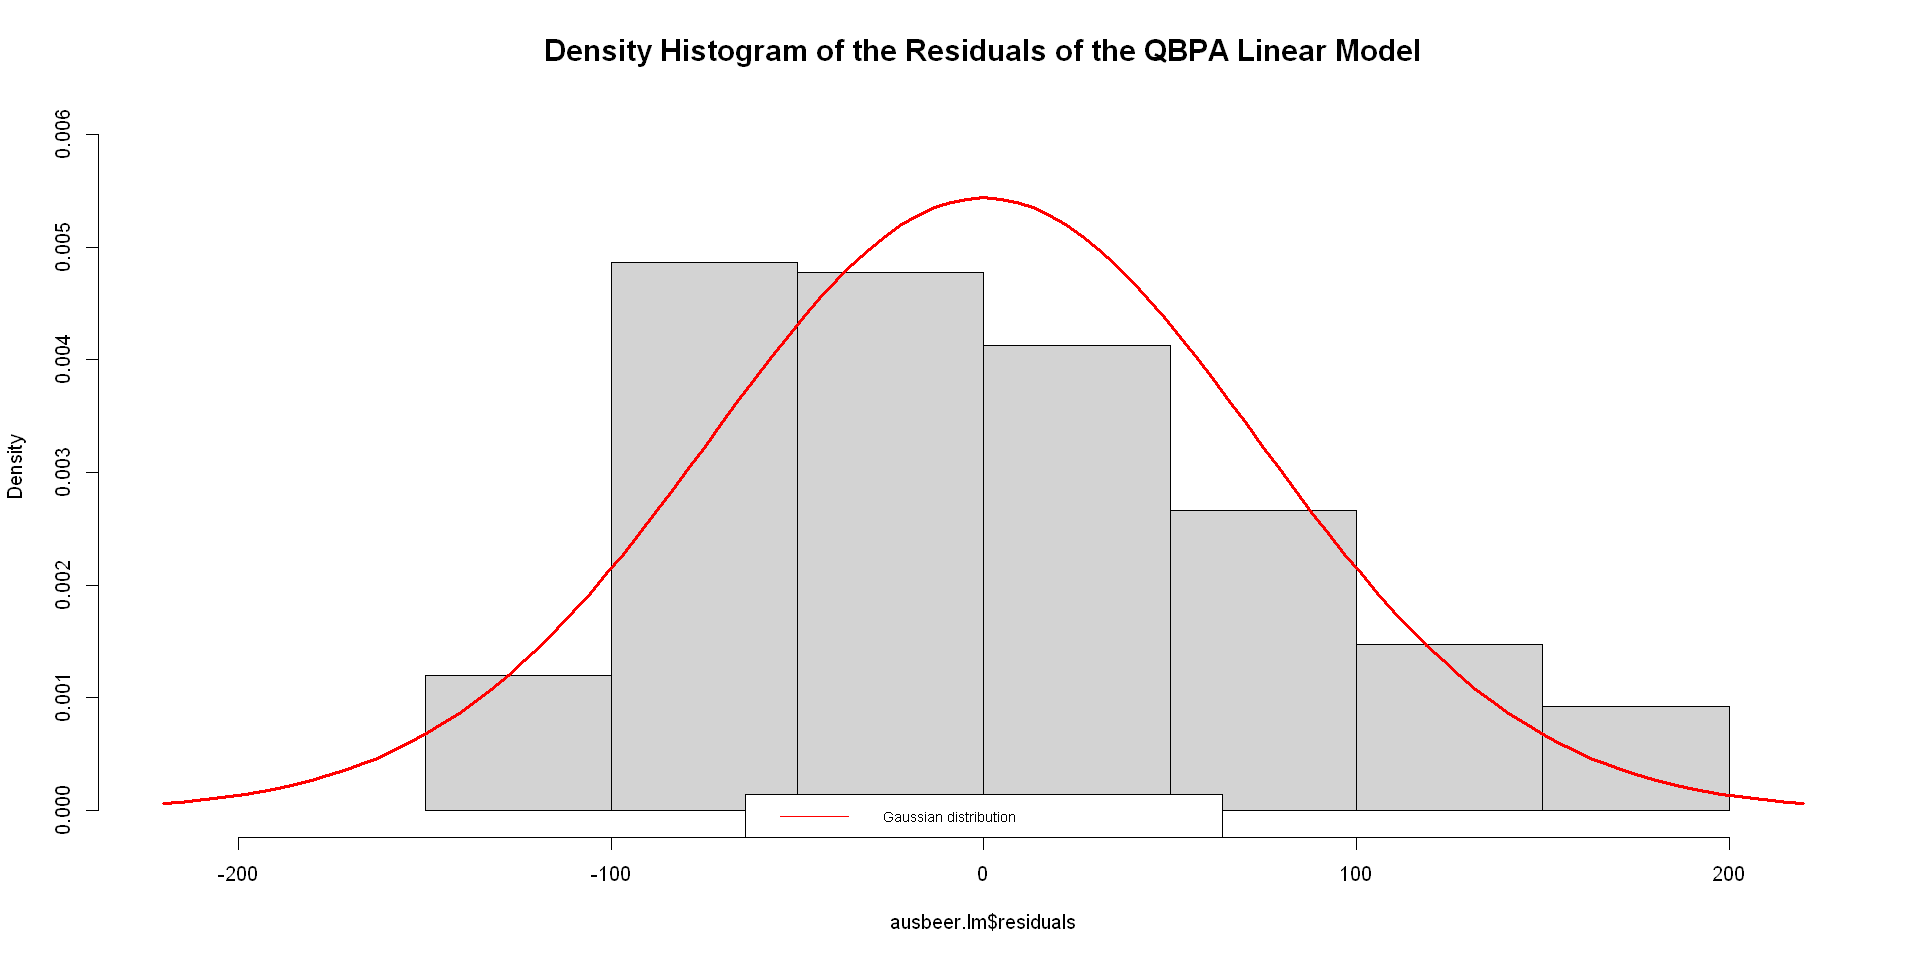

In [14]:
density <- hist(ausbeer.lm$residuals, plot=FALSE)$density
hist(ausbeer.lm$residuals, freq = FALSE, , xlim=c(-3*sigma(ausbeer.lm),3*sigma(ausbeer.lm)), ylim=c(0,max(density*1.25)),
    main = "Density Histogram of the Residuals of the QBPA Linear Model",
    cex.axis=1, cex.main= 1.5, cex.sub = 1, cex.lab = 1)
curve(dnorm(x,mean=0,sd=sigma(ausbeer.lm)), add=TRUE,col="red", lwd=3)
legend("bottom", legend = "Gaussian distribution", cex = 0.7, col = "red", lty=c(1,2))

Cerco ulteriori conferme attraverso il qqPlot

[1] 92 72

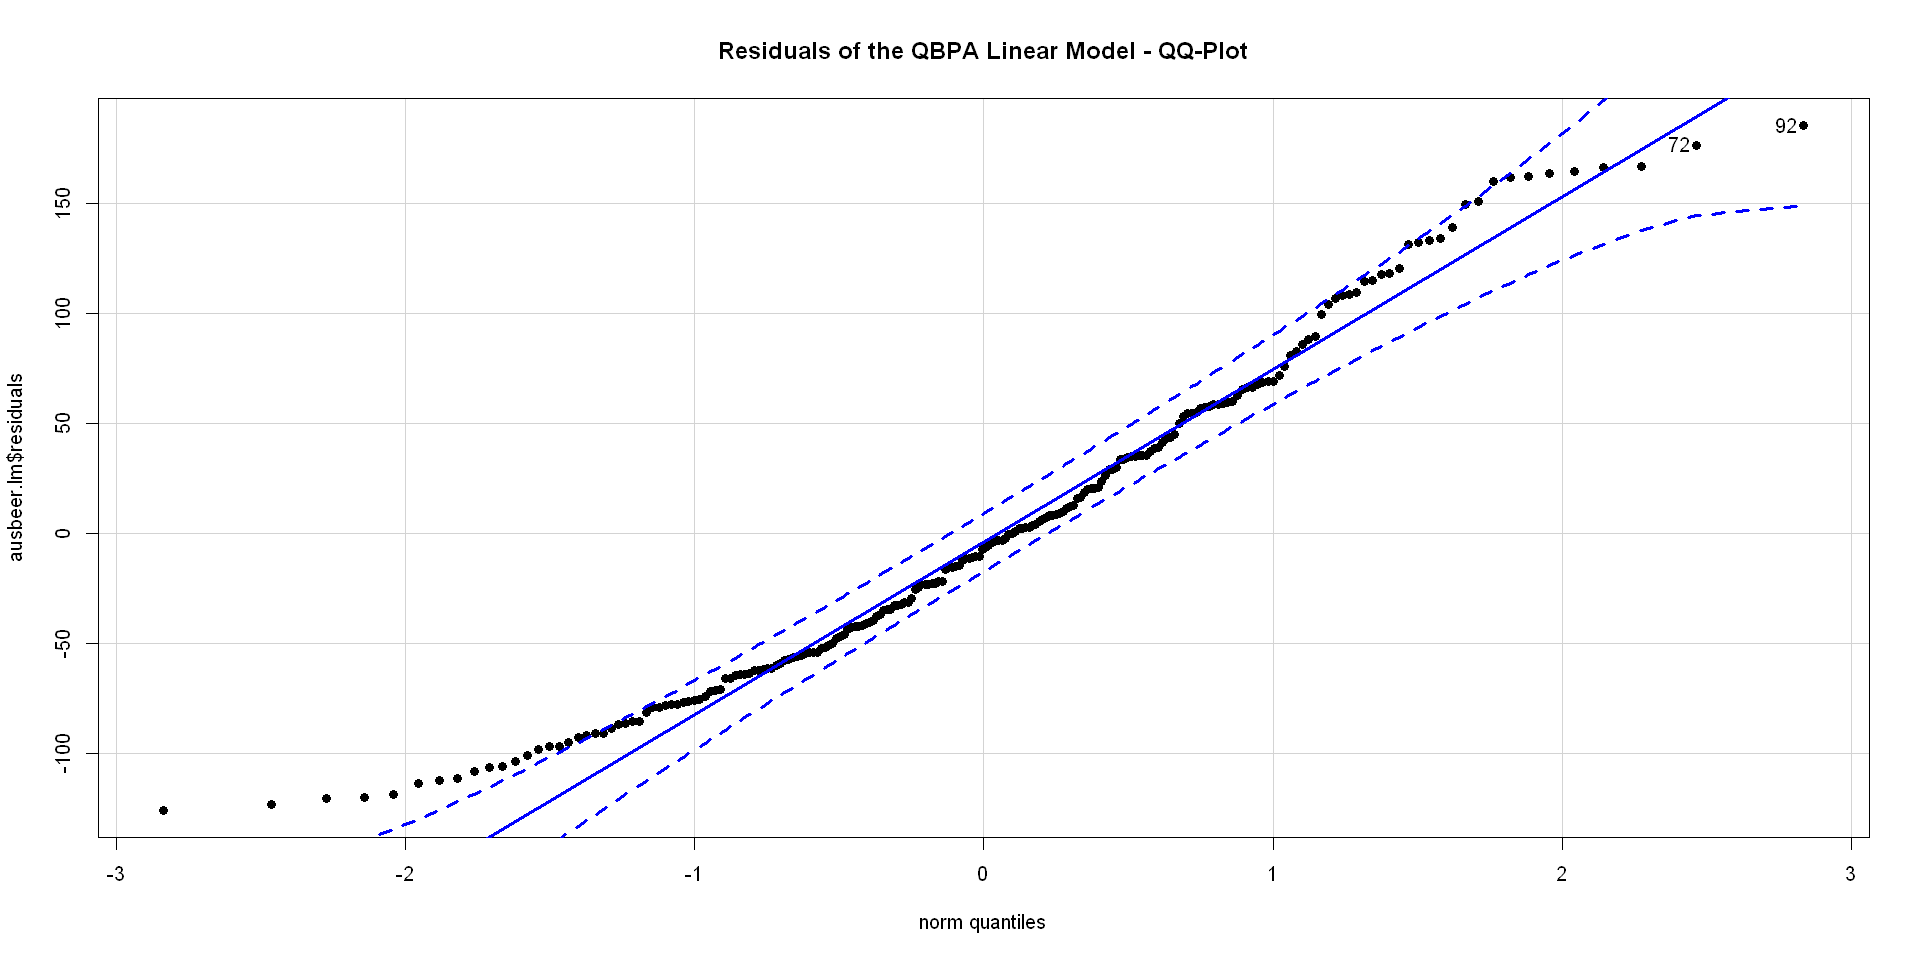

In [15]:
qqPlot(ausbeer.lm$residuals, lwd=3, pch=16,
      main = "Residuals of the QBPA Linear Model - QQ-Plot")

Infine applico i test statistici per la confermare l'ipotesi di non gaussianità dei residui emersa dalle evidenze raccolte precedentemente

In [16]:
jarque.bera.test(ausbeer.lm$residuals) # Jarque-Bera ## H0: The data is normally distributed.
shapiro.test(ausbeer.lm$residuals) # Shapiro-Wilks ## H0: The data is normally distributed.
dagoTest(ausbeer.lm$residuals) # D’Agostino Pearson ## H0: The data is normally distributed.


	Jarque Bera Test

data:  ausbeer.lm$residuals
X-squared = 11.202, df = 2, p-value = 0.003694



	Shapiro-Wilk normality test

data:  ausbeer.lm$residuals
W = 0.96595, p-value = 4.262e-05



Title:
 D'Agostino Normality Test

Test Results:
  STATISTIC:
    Chi2 | Omnibus: 11.115
    Z3  | Skewness: 3.0416
    Z4  | Kurtosis: -1.3652
  P VALUE:
    Omnibus  Test: 0.003858 
    Skewness Test: 0.002354 
    Kurtosis Test: 0.1722 

Description:
 Tue Dec 22 23:14:23 2020 by user: Marco


Tutti i test rigettano l'ipotesi di normalità dei residui confermando la violazione dell'assunto del modello lineare.

*Nota metodologica: è stato considerato un livello di significatività α=.05*

### 3.2 Stazionarietà dei residui

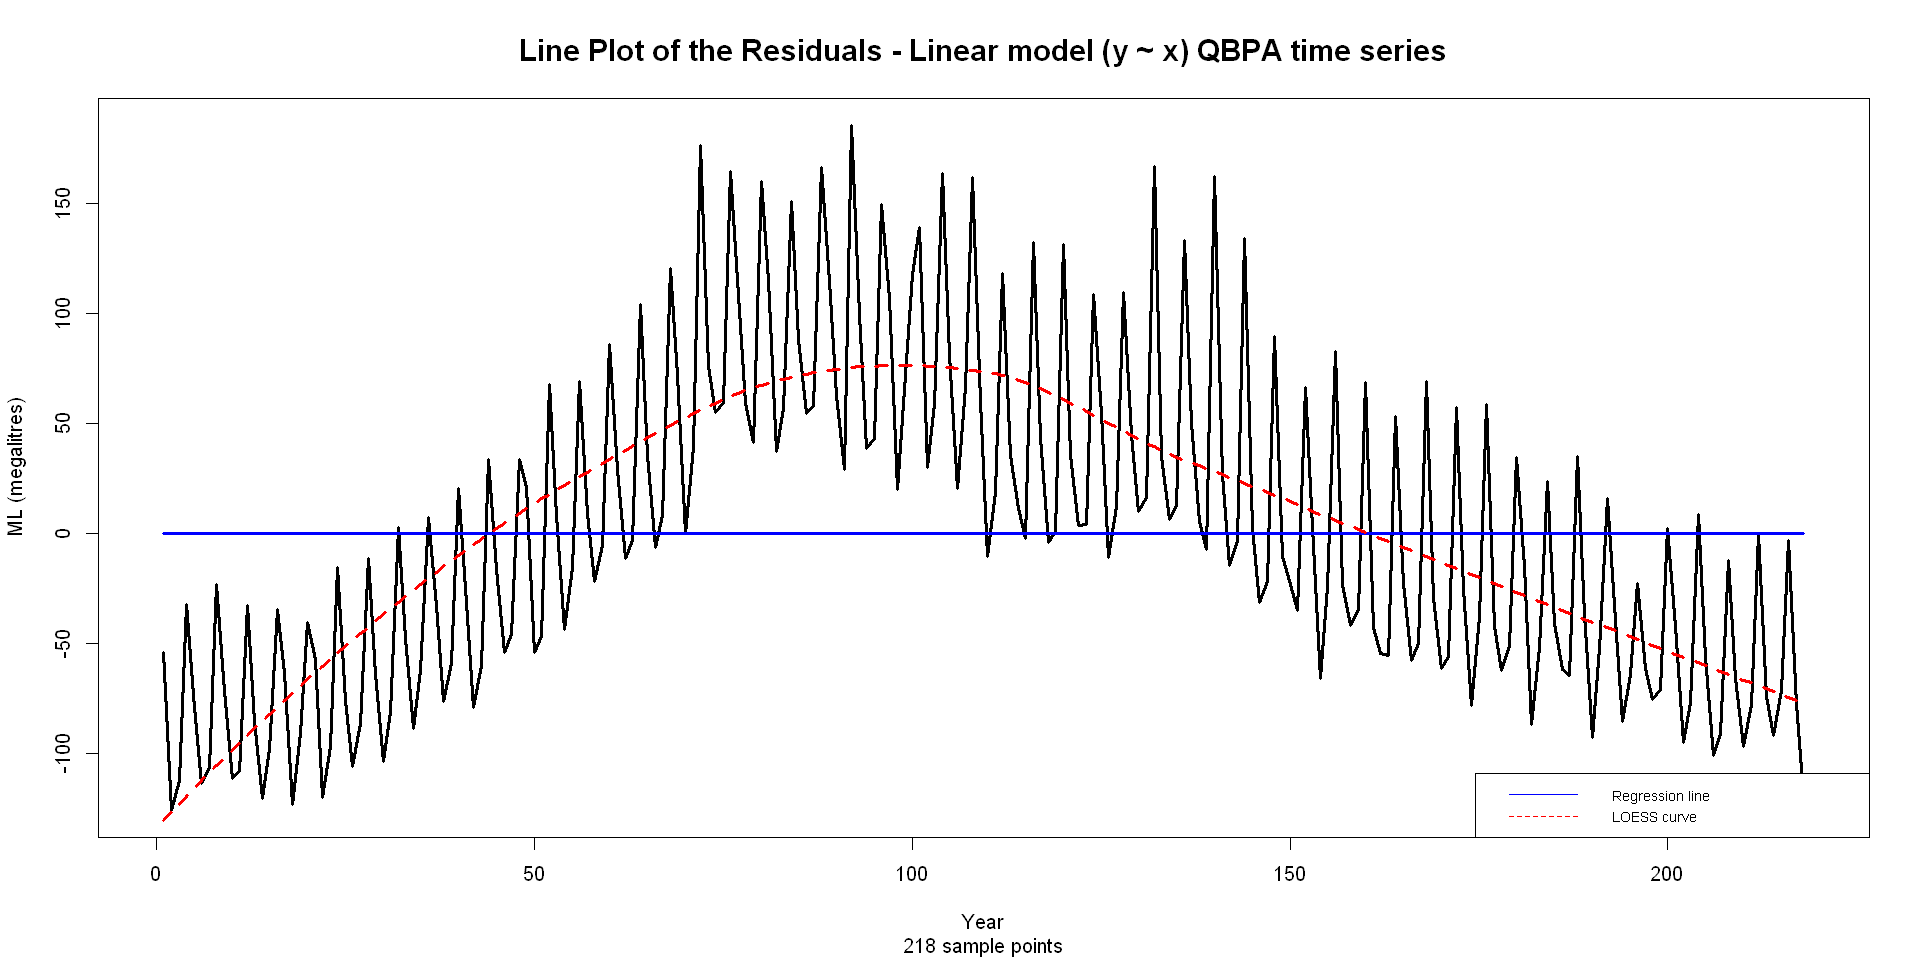

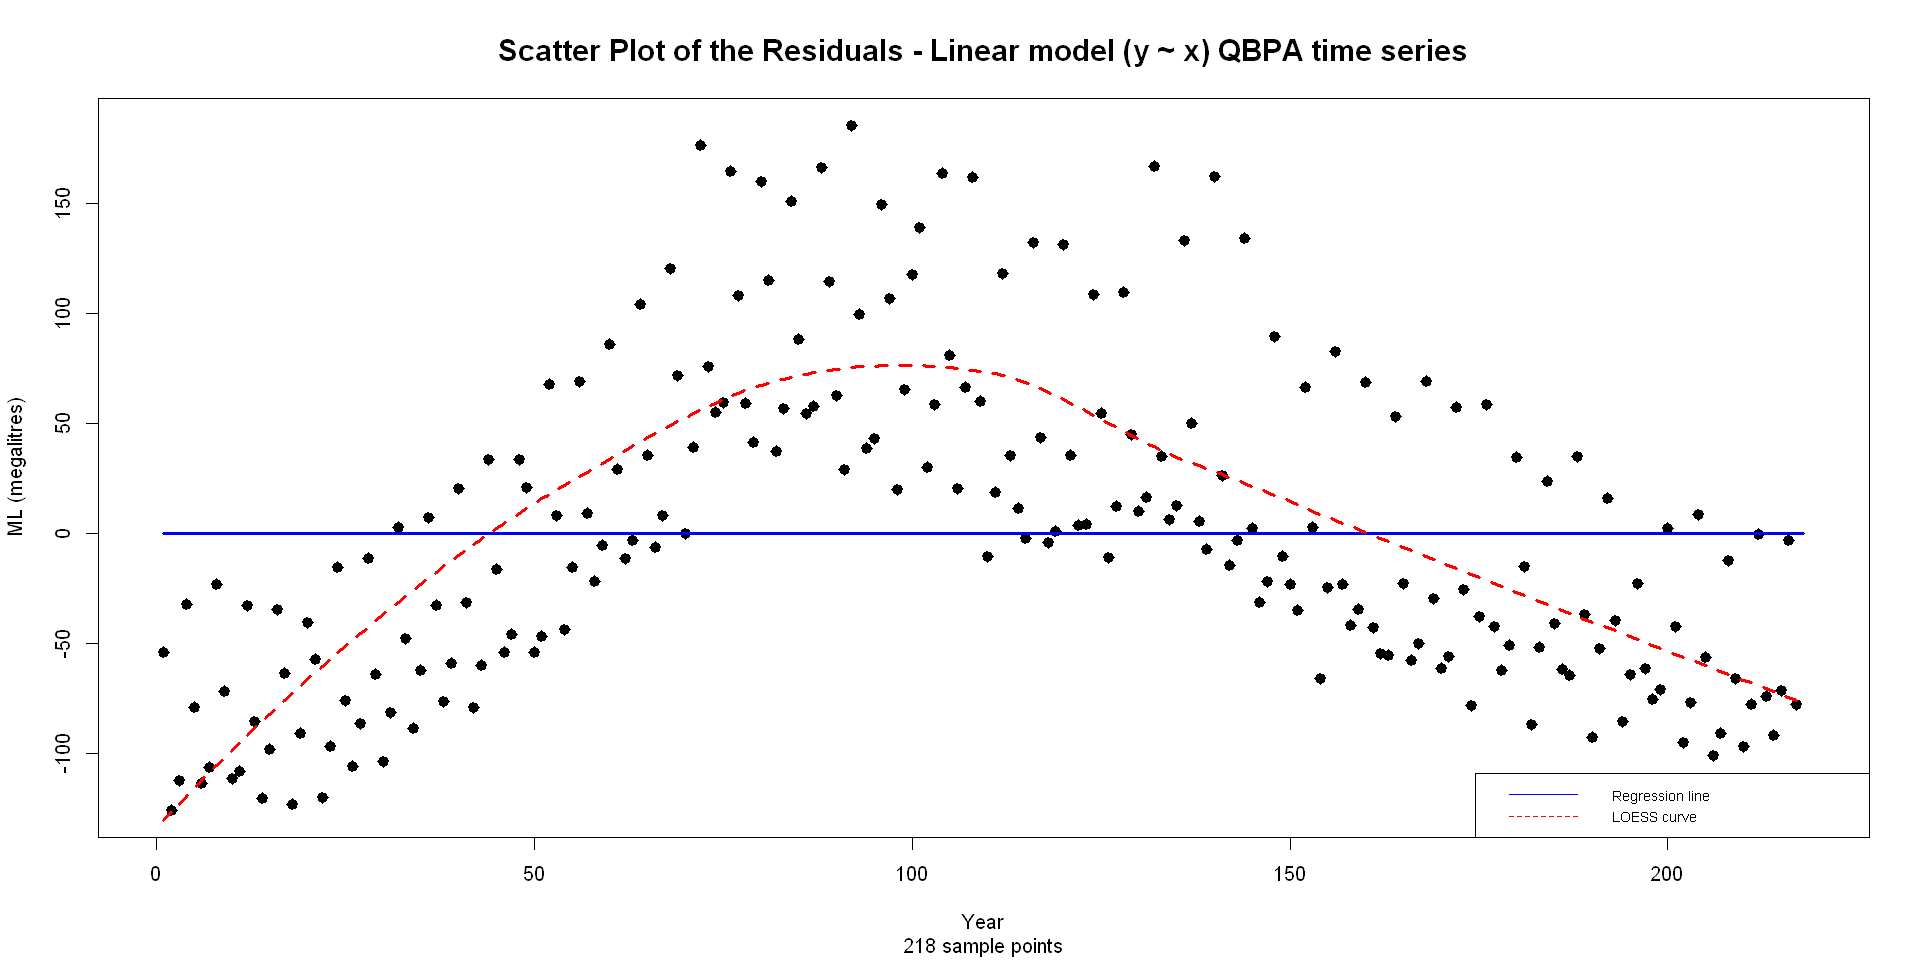

In [17]:
#line plot
plot(ausbeer.lm$residuals, type="l", lwd=3,
     main = "Line Plot of the Residuals - Linear model (y ~ x) QBPA time series",
     sub = paste(length(ausbeer), "sample points", sep=" "),
     xlab = "Year", ylab = "ML (megalitres)",
     cex.axis=1, cex.main= 1.5, cex.sub = 1, cex.lab = 1)
loess.fit <- ts(loess((ausbeer.lm$residuals ~ index(ausbeer.lm$residuals)), span = 0.8)$fitted)
lm.fit <- ts(lm(ausbeer.lm$residuals ~ index(ausbeer.lm$residuals))$fitted.values)
lines(lm.fit, col = "blue", lwd=3)
lines(loess.fit, col = "red", lty=2, , lwd=3)
legend("bottomright", legend = c("Regression line", "LOESS curve"), cex = 0.7, col = c("blue","red"), lty=c(1,2))

#scatter plot
plot(ausbeer.lm$residuals, type="p", lwd=3, pch = 10, 
     main = "Scatter Plot of the Residuals - Linear model (y ~ x) QBPA time series",
     sub = paste(length(ausbeer), "sample points", sep=" "),
     xlab = "Year", ylab = "ML (megalitres)", 
     cex.axis=1, cex.main= 1.5, cex.sub = 1, cex.lab = 1)
loess.fit <- ts(loess((ausbeer.lm$residuals ~ index(ausbeer.lm$residuals)), span = 0.8)$fitted)
lm.fit <- ts(lm(ausbeer.lm$residuals ~ index(ausbeer.lm$residuals))$fitted.values)
lines(lm.fit, col = "blue", lwd=3)
lines(loess.fit, col = "red", lty=2, , lwd=3)
legend("bottomright", legend = c("Regression line", "LOESS curve"), cex = 0.7, col = c("blue","red"), lty=c(1,2))

Dall'analisi grafica dei residui emerge una chiara non stazionarietà di tipo quadratico.
In questo caso non ha molto senso approfondire la stazionarità con i test statistici basati sul modello lineare (Dickey-Fuller e Kwiatkowski, Phillips, Schmidt e Shin) perchè non siamo in presenza di un trend lineare o stocastico; per andare a fondo e cercare ulteriori conferme di non stazionarietà provo a fare una regressione di tipo parabolico sui residui:

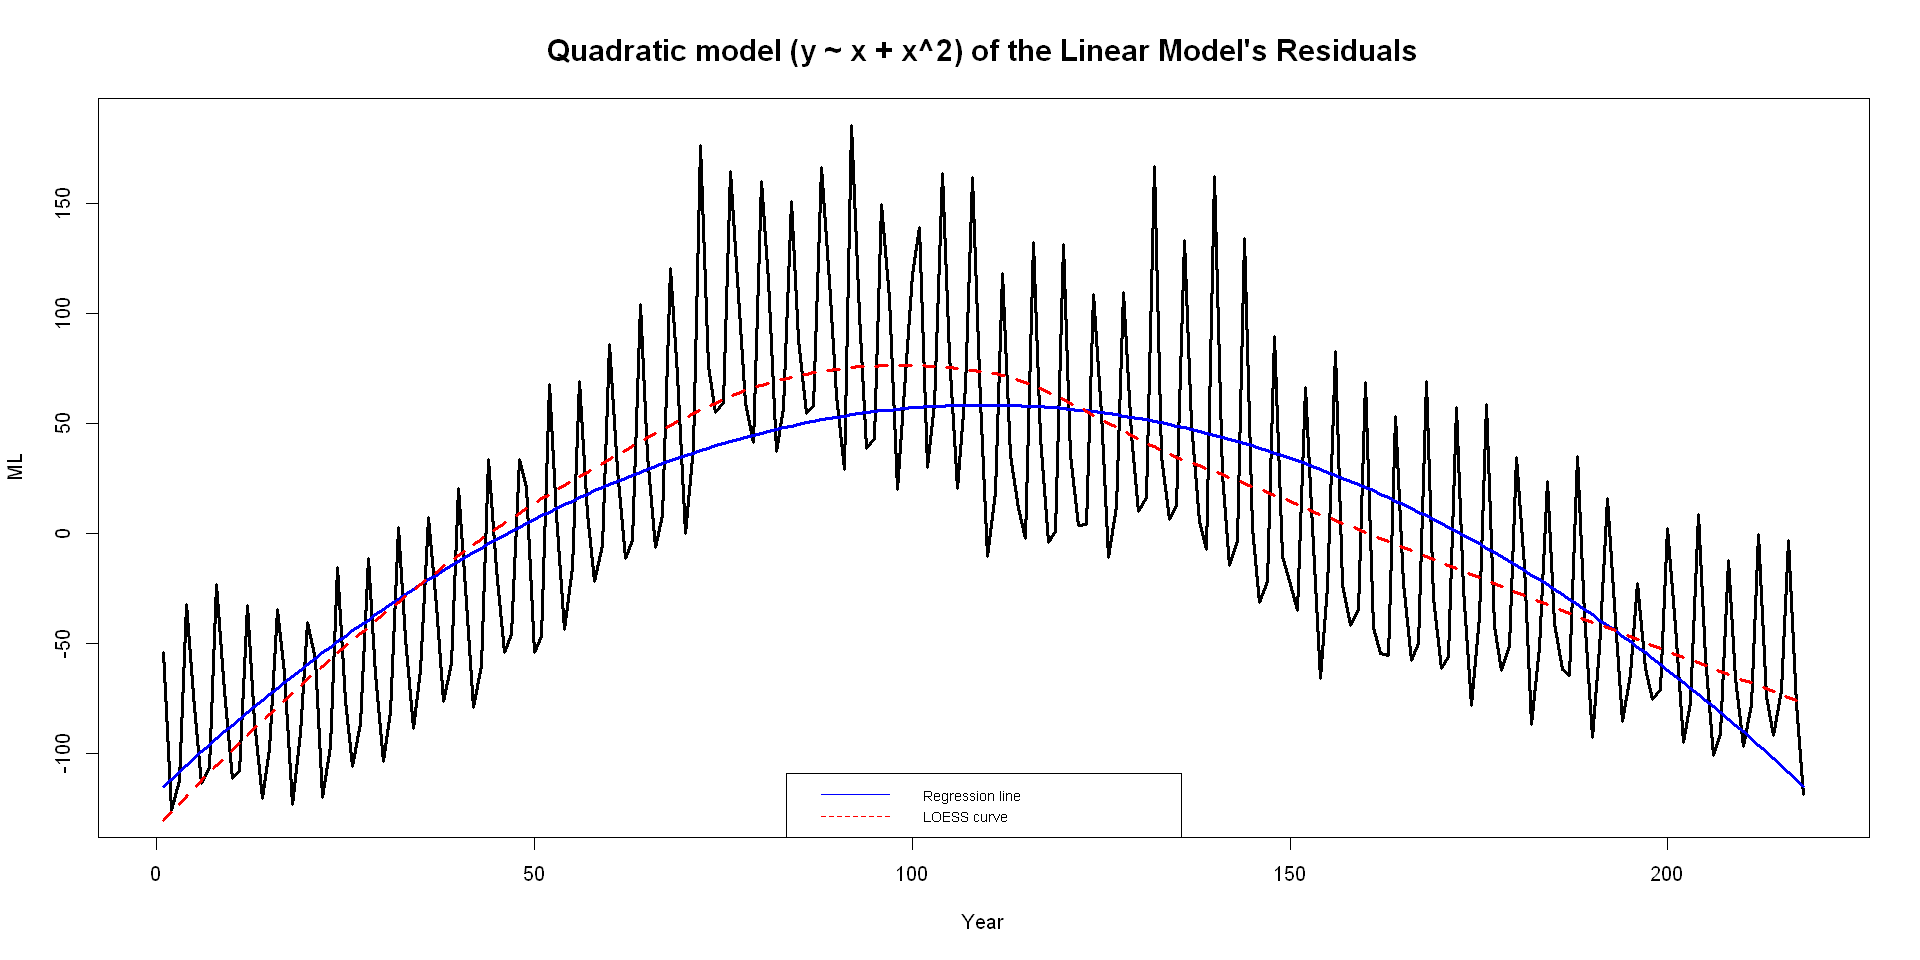

In [18]:
#line plot
plot(ausbeer.lm$residuals, type="l", lwd=3,
     main = "Quadratic model (y ~ x + x^2) of the Linear Model's Residuals", 
     xlab = "Year", ylab = "ML",
     cex.axis=1, cex.main= 1.5, cex.sub = 1, cex.lab = 1)
loess.fit <- ts(loess((ausbeer.lm$residuals ~ index(ausbeer.lm$residuals)), span = 0.8)$fitted)
x2 <- index(ausbeer.lm$residuals)^2
lm.fit <- ts(lm(ausbeer.lm$residuals ~ index(ausbeer.lm$residuals)+x2)$fitted.values)
lines(lm.fit, col = "blue", lwd=3)
lines(loess.fit, col = "red", lty=2, , lwd=3)
legend("bottom", legend = c("Regression line", "LOESS curve"), cex = 0.7, col = c("blue","red"), lty=c(1,2))

In [19]:
ausbeer.lm.res <- ausbeer.lm$residuals
x2 <- index(ausbeer.lm.res)^2

In [20]:
ausbeer.qm <- lm(ausbeer.lm.res ~ index(ausbeer.lm.res)+I(x2))
summary(ausbeer.qm)


Call:
lm(formula = ausbeer.lm.res ~ index(ausbeer.lm.res) + I(x2))

Residuals:
   Min     1Q Median     3Q    Max 
-95.17 -40.61 -10.02  35.32 138.77 

Coefficients:
                        Estimate Std. Error t value Pr(>|t|)    
(Intercept)           -1.181e+02  1.057e+01  -11.17   <2e-16 ***
index(ausbeer.lm.res)  3.221e+00  2.229e-01   14.45   <2e-16 ***
I(x2)                 -1.471e-02  9.857e-04  -14.92   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 51.55 on 215 degrees of freedom
Multiple R-squared:  0.5086,	Adjusted R-squared:  0.5041 
F-statistic: 111.3 on 2 and 215 DF,  p-value: < 2.2e-16


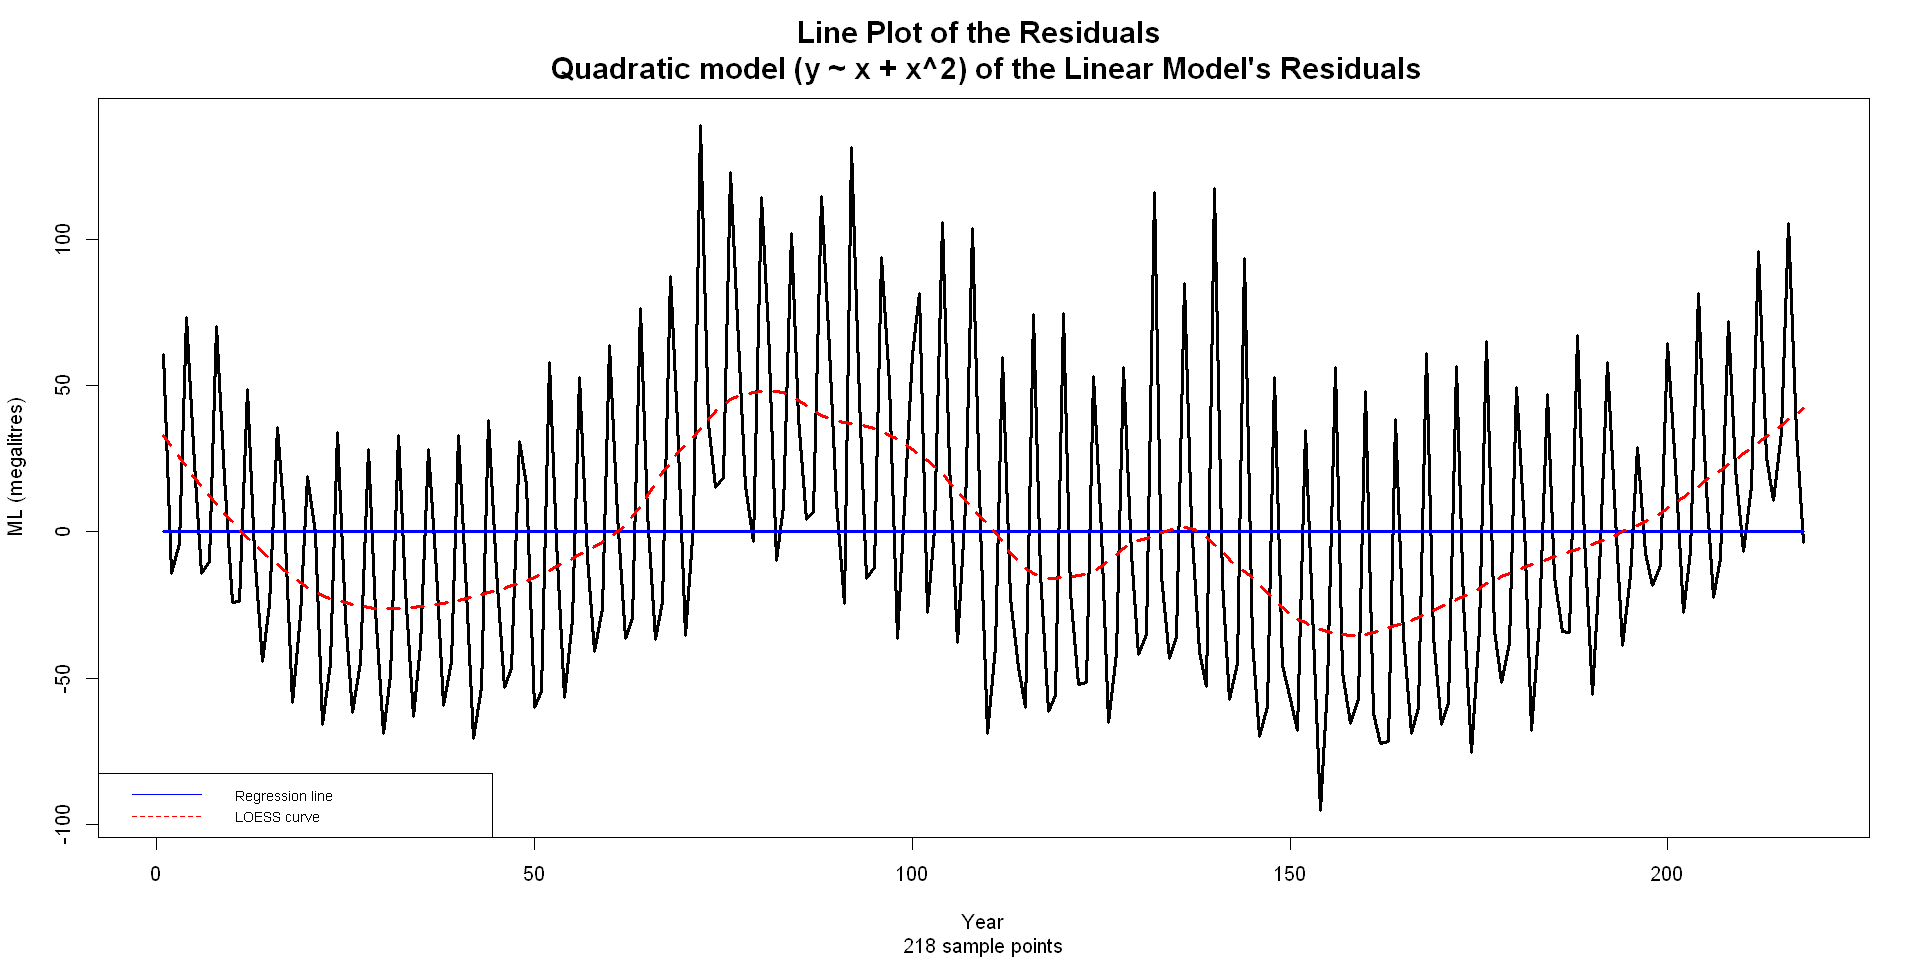

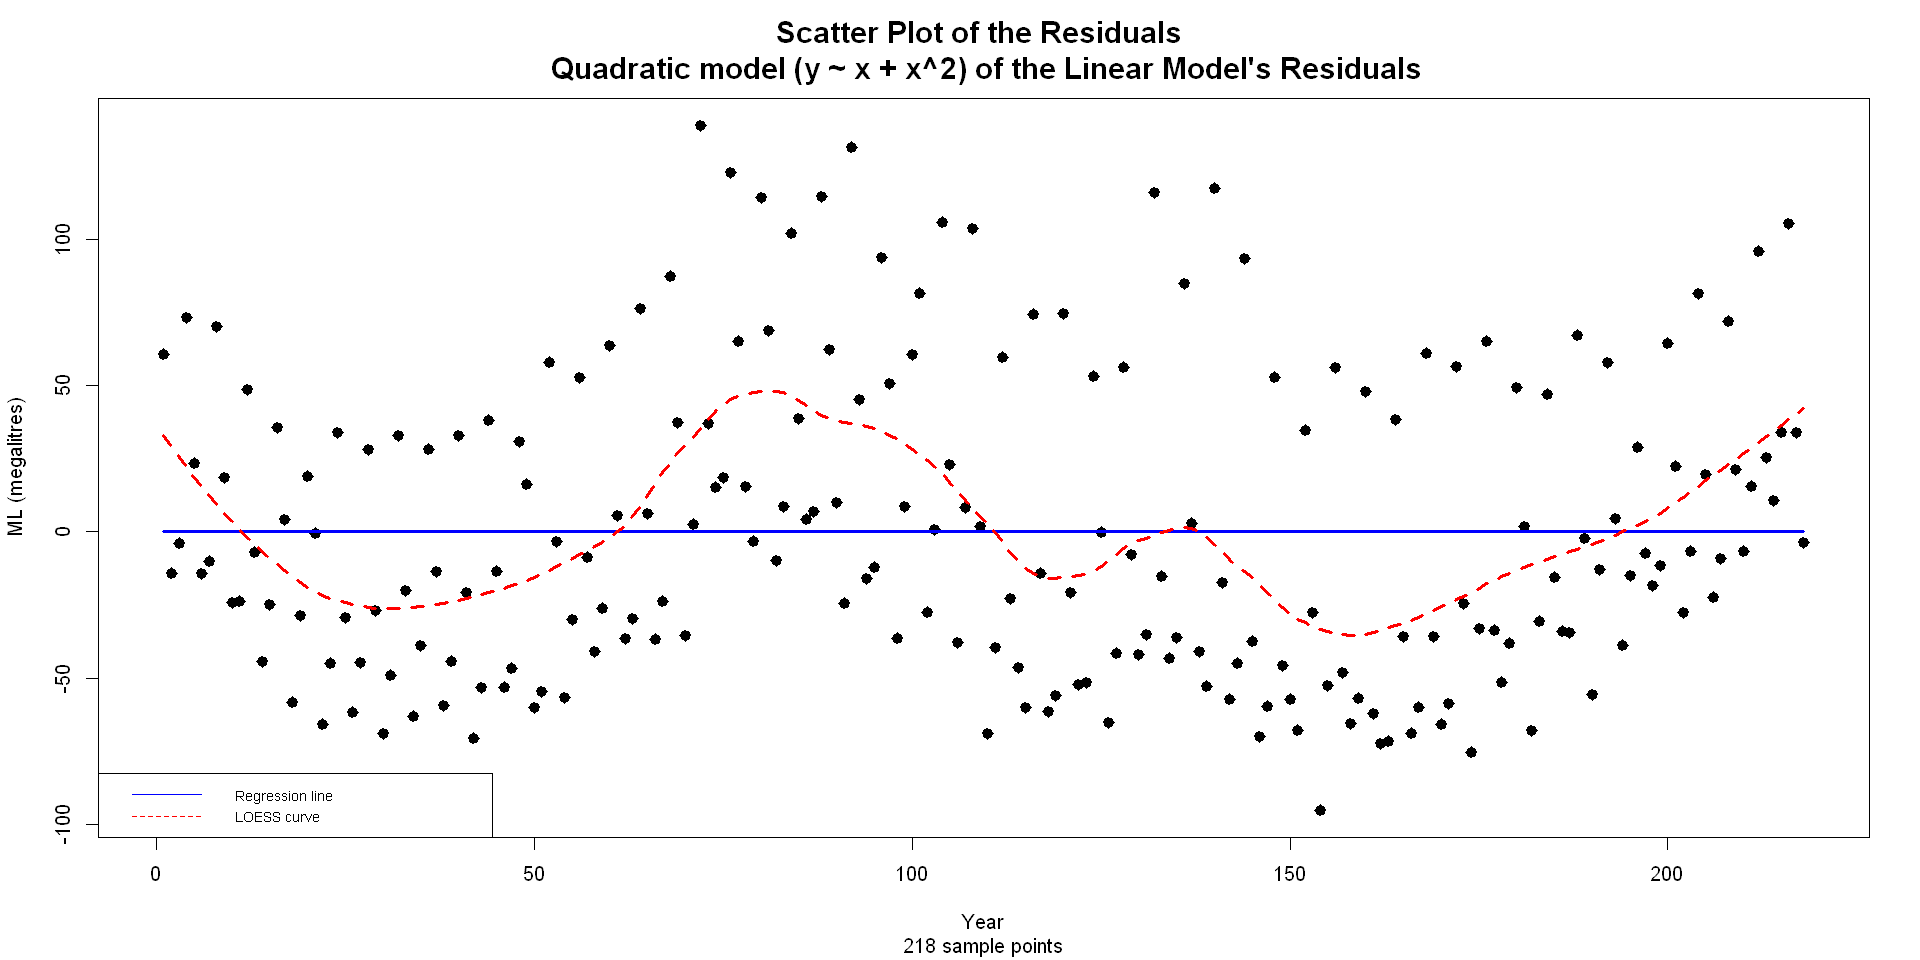

In [21]:
#line plot
plot(ausbeer.qm$residuals, type="l", lwd=3,
     main = "Line Plot of the Residuals \n Quadratic model (y ~ x + x^2) of the Linear Model's Residuals",
     sub = paste(length(ausbeer), "sample points", sep=" "),
     xlab = "Year", ylab = "ML (megalitres)", 
     cex.axis=1, cex.main= 1.5, cex.sub = 1, cex.lab = 1)
loess.fit <- ts(loess((ausbeer.qm$residuals ~ index(ausbeer.qm$residuals)), span = 0.2)$fitted)
lm.fit <- ts(lm(ausbeer.qm$residuals ~ index(ausbeer.qm$residuals))$fitted.values)
lines(lm.fit, col = "blue", lwd=3)
lines(loess.fit, col = "red", lty=2, , lwd=3)
legend("bottomleft", legend = c("Regression line", "LOESS curve"), cex = 0.7, col = c("blue","red"), lty=c(1,2))

#scatter plot
plot(ausbeer.qm$residuals, type="p", lwd=3, pch = 10, 
     main = "Scatter Plot of the Residuals \n Quadratic model (y ~ x + x^2) of the Linear Model's Residuals",
     sub = paste(length(ausbeer), "sample points", sep=" "),
     xlab = "Year", ylab = "ML (megalitres)", 
     cex.axis=1, cex.main= 1.5, cex.sub = 1, cex.lab = 1)
loess.fit <- ts(loess((ausbeer.qm$residuals ~ index(ausbeer.qm$residuals)), span = 0.2)$fitted)
lm.fit <- ts(lm(ausbeer.qm$residuals ~ index(ausbeer.qm$residuals))$fitted.values)
lines(lm.fit, col = "blue", lwd=3)
lines(loess.fit, col = "red", lty=2, , lwd=3)
legend("bottomleft", legend = c("Regression line", "LOESS curve"), cex = 0.7, col = c("blue","red"), lty=c(1,2))

*Nota metodologica: nella visualizzazione della loess dei residui del modello quadratico (dei residui della regressione lineare) è stato scelto di cambiare il parametro span (da 0.8 delle precedenti visualizzazioni a 0.2) per cogliere al meglio gli andamenti locali dei residui (dei residui).*

L'analisi grafica evidenzia la rimozione della maggior parte della componente non lineare dai residui del modello lineare, aspetto che avvalora l'ipotesi di non stazionarietà della serie storica di partenza; allo stesso tempo è stato possibile evidenziare un'ulteriore componente di non stazionarietà che risulta essere particolarmente interessante a livello economico. Se guardati attentamente i residui della regressione quadratica sembrano ricalcare, almeno graficamente, i cicli economici [^2] dell'economia australiana [^3] [^4].

[^2]: Gallego, L. (n.d.). Business cycles. Retrieved December 22, 2020, from https://policonomics.com/economic-cycles/

[^3]: Fang, V., Lin, C. T., & Parbhoo, K. M. (2008). Macroeconomic news, business cycles and Australian financial markets. Asia-Pacific Financial Markets, 15(3-4), 185-207.

[^4]: Phases of Business Cycles in Australia. (n.d.). Retrieved December 15, 2020, from https://melbourneinstitute.unimelb.edu.au/publications/macroeconomic-reports/phases-of-business-cycles-in-australia

### 3.3 Scorrelazione dei residui

Visto che dall'analisi grafica preliminare della serie storica era emerso un comportamento oscillatorio, costruisco un autocorrelogramma dei residui del modello lineare; l'autocorrelogramma nello specifico permette di indagare la tendenza dei residui ad essere correlati tra loro sia da un punto di vista grafico, sia da un punto di vista quantitativo. 

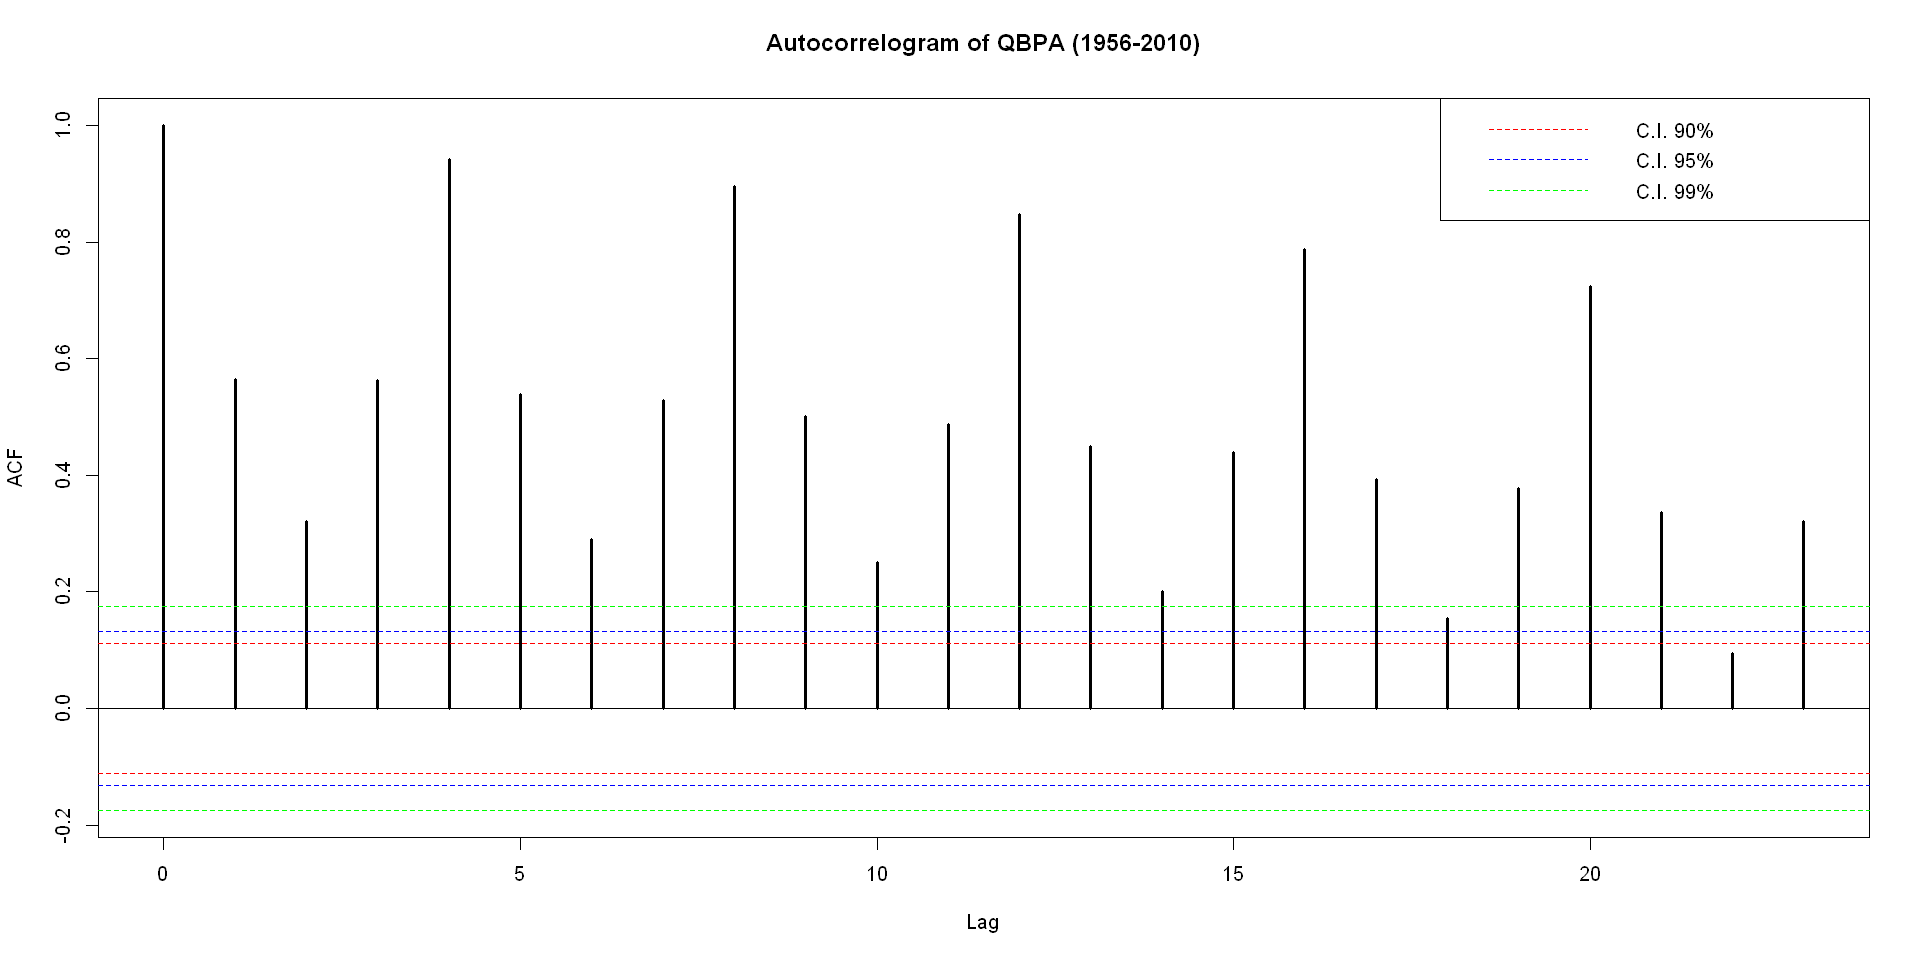

In [22]:
acf(ausbeer.lm$residuals, lwd=3,
    main="Autocorrelogram of QBPA (1956-2010)",
    ci = c(0.90,0.95, 0.99), ci.col=c("red", "blue", "green"),
    cex.axis=1, cex.main= 1.5, cex.sub = 1, cex.lab = 1)
legend("topright", 
       legend = c("C.I. 90%", "C.I. 95%", "C.I. 99%"), 
       col = c("red", "blue", "green"), lty=c(2,2,2))

In linea con quanto ipotizzato nell'analisi grafica preliminare della serie storica, l'autocorrelogramma fornisce una chiara evidenza di stagionalità all'interno dei residui, con picchi ripetuti secondo uno schema chiaro e ricorrente che segue i trimestri dell'anno. Anche se l'autocrrelogramma ha fornito una fotografia abbastanza chiara della situazione applico i test statistici per raccogliere ulteriori evidenze:

In [23]:
Box.test(ausbeer.lm$residuals, lag=4, type="Ljung-Box") # Ljung-Box ## H0: autocorrelations (for chosen lags) in the data is zero
dwtest(ausbeer.lm, alternative = "two.sided", exact = TRUE) # Durbin-Watson ## H0: residuals from an OLS regression are not autocorrelated
bgtest(ausbeer.lm, order = 4, type="Chisq") # Breusch-Godfrey ## H0: there is no serial correlation of any order up to p
bgtest(ausbeer.lm, order = 4, type="F") # Breusch-Godfrey ## H0: there is no serial correlation of any order up to p


	Box-Ljung test

data:  ausbeer.lm$residuals
X-squared = 362.92, df = 4, p-value < 2.2e-16



	Durbin-Watson test

data:  ausbeer.lm
DW = 0.85463, p-value < 2.2e-16
alternative hypothesis: true autocorrelation is not 0



	Breusch-Godfrey test for serial correlation of order up to 4

data:  ausbeer.lm
LM test = 198.49, df = 4, p-value < 2.2e-16



	Breusch-Godfrey test for serial correlation of order up to 4

data:  ausbeer.lm
LM test = 539.2, df1 = 4, df2 = 212, p-value < 2.2e-16


I test rigettano in blocco l'ipotesi di scorrelazione confermando quanto già emerso dagli autocorrelogrammi; non è dunque rispettato l'assunto di assenza di correlazione nei residui.

*Nota metodologica: è stato considerato un livello di significatività α=.05*

### 3.4 Omoschedasticità dei residui

Come primo passo per indagare l'omoschedasticità dei residui costruisco uno scale-location plot dei residui della regressione lineare.

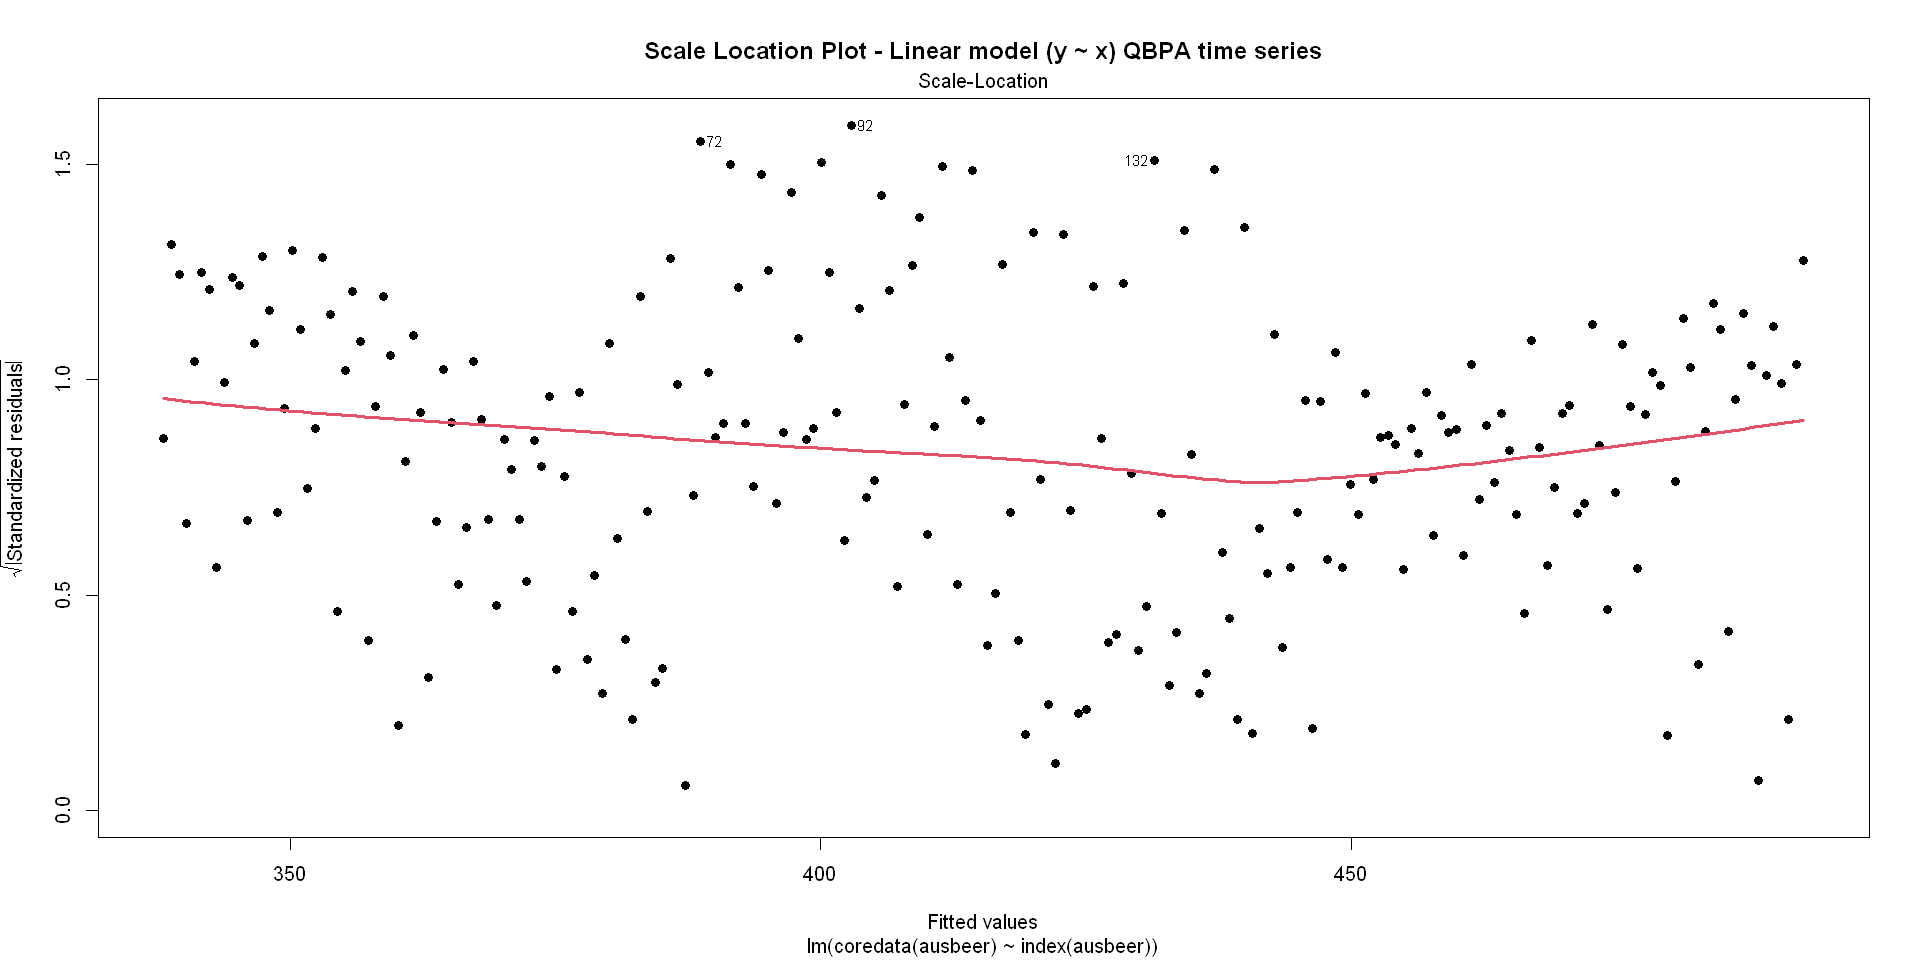

In [24]:
plot(ausbeer.lm, 3, lwd = 3, pch = 16, 
     main="Scale Location Plot - Linear model (y ~ x) QBPA time series")

Dalla visualizzazione dello scale location-plot non sembrano emergere grossi problemi di eteroschedasticità a livello globale, tuttavia ci sono alcune parti della serie che lasciano qualche dubbio sull'eteroschedasticità di specifiche zone. Se osservate con attenzione, le zone corrispondenti agli anni in cui sono stati prodotti i maggiori quantitativi di birra mostrano una varianza maggiore. Questo comportamento trova un riscontro a livello teorico: è noto che quando un fenomeno economico cresce la sua domanda diventa più volatile.

A questo punto verifico con i test statistici l'ipotesi che i residui siano omoschedastici, nello specifico applico il test di Koenker, il test di White e il test di White-Wooldridge. 

*Nota metodologica: Applico i test studentizzati perchè la normalità nei residui non è rispettata*

In [25]:
print("------ Koenker test ------")
bptest(ausbeer.lm, studentize = TRUE) # Koenker ## H0: Equal/constant variances
print("------ White test ------")
bptest(ausbeer.lm,  ~ index(ausbeer.lm) + I(index(ausbeer.lm)^2) , studentize = TRUE) # White ## H0: Equal/constant variances
print("------ White-Wooldridge test ------")
bptest(ausbeer.lm,  ~ ausbeer.lm$fitted + I(ausbeer.lm$fitted^2) , studentize = TRUE) # White-Wooldridge ## H0: Equal/constant variances

[1] "------ Koenker test ------"



	studentized Breusch-Pagan test

data:  ausbeer.lm
BP = 3.8037, df = 1, p-value = 0.05114


[1] "------ White test ------"



	studentized Breusch-Pagan test

data:  ausbeer.lm
BP = 0.069593, df = 2, p-value = 0.9658


[1] "------ White-Wooldridge test ------"



	studentized Breusch-Pagan test

data:  ausbeer.lm
BP = 4.1734, df = 2, p-value = 0.1241


Gli esiti dei test statistici, uniti alle evidenze dello scale-location plot, confermano l'omoschedasticità dei residui del modello lineare confutando l'ipotesi di eteroschedasticità fatta nella prima fase di visualizzazione della serie storica

*Nota metodologica: è stato considerato un livello di significatività α=.05*

### 3.5 Conclusioni sul modello lineare

L'analisi approfondita sul modello lineare ha permesso, in primo luogo, di confermare che non si tratta di un buon modello per descrivere il fenomeno considerato (a causa della violazione di quasi tutti gli assunti alla base del modello lineare) e, successivamente, di capire meglio le caratteristiche della serie stessa ovvero che ci troviamo davanti a una serie storica non stazionaria, ragionevolmente omoschedastica e con una forte presenza di stagionalità.

[Torna all'indice](#Indice)

## 4 Punti di rottura della serie storica

A questo punto, sulla base di quanto emerso dall'analisi esplorativa e dal modello lineare, decido di indagare la presenza di punti di rottura della serie storica. Il punto di rottura è un punto in cui la serie storica subisce una brusca variazione, un momento di grande cambiamento che fa mutare la natura stessa della serie. A livello pratico il punto di rottura permette di individuare porzioni ridotte della serie storica che, se studiate opportunamente, permettono di costruire modelli per il forecasting più attendibili e precisi.

In [26]:
bp_ts <- breakpoints(ausbeer ~ 1)
ci_ts <- confint(bp_ts, level=0.90)
summary(bp_ts)


	 Optimal (m+1)-segment partition: 

Call:
breakpoints.formula(formula = ausbeer ~ 1)

Breakpoints at observation number:
                         
m = 1   51               
m = 2   35 67            
m = 3   35 67     144    
m = 4   35 67 108 144    
m = 5   35 67 108 144 181

Corresponding to breakdates:
                                               
m = 1   1968(3)                                
m = 2   1964(3) 1972(3)                        
m = 3   1964(3) 1972(3)         1991(4)        
m = 4   1964(3) 1972(3) 1982(4) 1991(4)        
m = 5   1964(3) 1972(3) 1982(4) 1991(4) 2001(1)

Fit:
                                                   
m   0       1       2       3       4       5      
RSS 1600481  642445  571949  487600  483106  479310
BIC    2570    2382    2367    2343    2352    2361

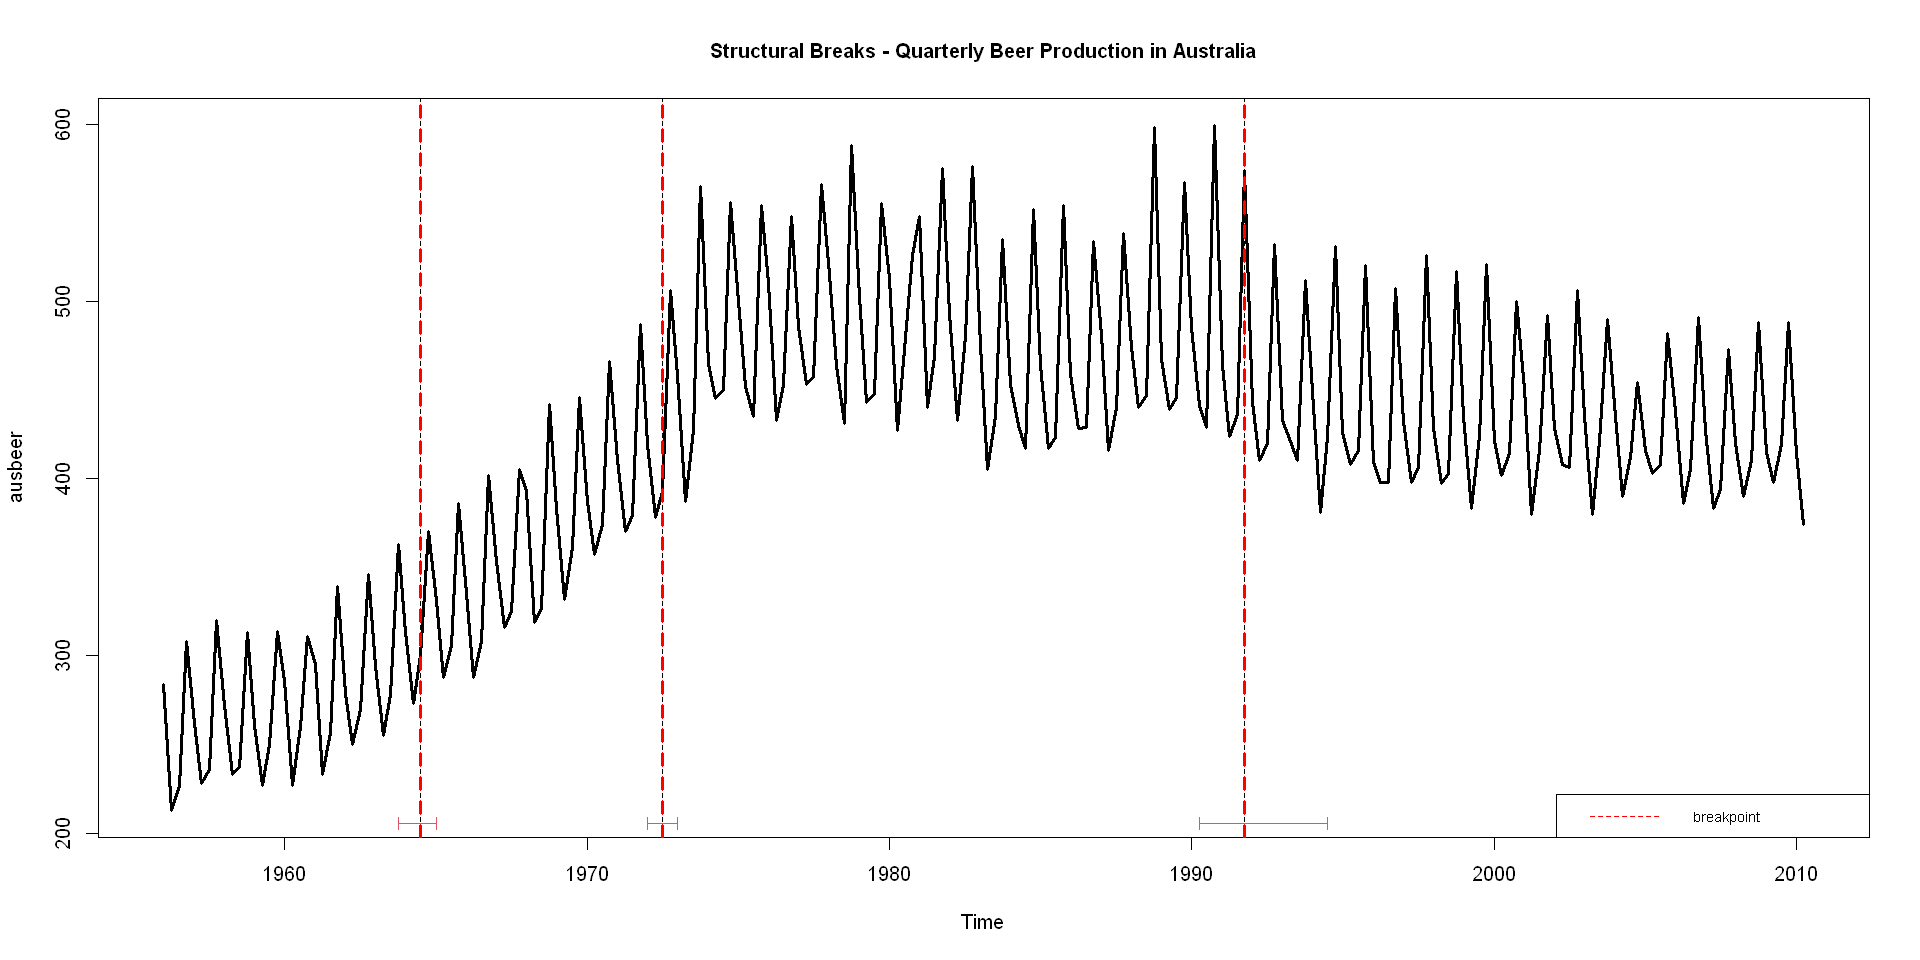

In [27]:
plot(ausbeer, main = "Structural Breaks - Quarterly Beer Production in Australia", cex.axis=0.7, cex.main= 1, lwd=3)
lines(ci_ts)
lines(bp_ts, col = "red", lwd=3)
legend("bottomright", legend = "breakpoint", cex = 0.7, col = "red", lty=2)

Sono stati individuati 3 punti di rottura principali: in corrispondenza del 1964, del 1972 e del 1991. Le ultime due date sono particolarmente interessanti dal punto di vista interpretativo in quanto compaiono in corrispondenza di eventi e/o cambiamenti significativi del tessuto socio-economico australiano. Nello specifico, nei primi anni '70 in Australia si inizia a porre l'attenzione sul consumo eccessivo di bevande alcoliche e vengono avviate le prime politiche di prevenzione e sensibilizzazione che possono aver avuto un impatto più o meno diretto sulla serie storica in esame. Il 1991, invece, è l'anno passato alla storia come l'anno che ha dato il via all'ultima grande crisi che ha colpito l'economia del paese (prima del periodo covid).

Per procedere con lo studio della serie storica e costruire successivamente un modello per il forecasting decido dunque di tagliare la serie storica all'ultimo breakpoint

*Nota metodologica: ho deciso di di includere tutto il 1991 (che cade all'interno dell'intervallo di confidenza del breakpoint) per avere i dati annuali completi*

In [28]:
ausbeer.cut <- window(ausbeer, start=c(1991, 1), end=c(2010,2))

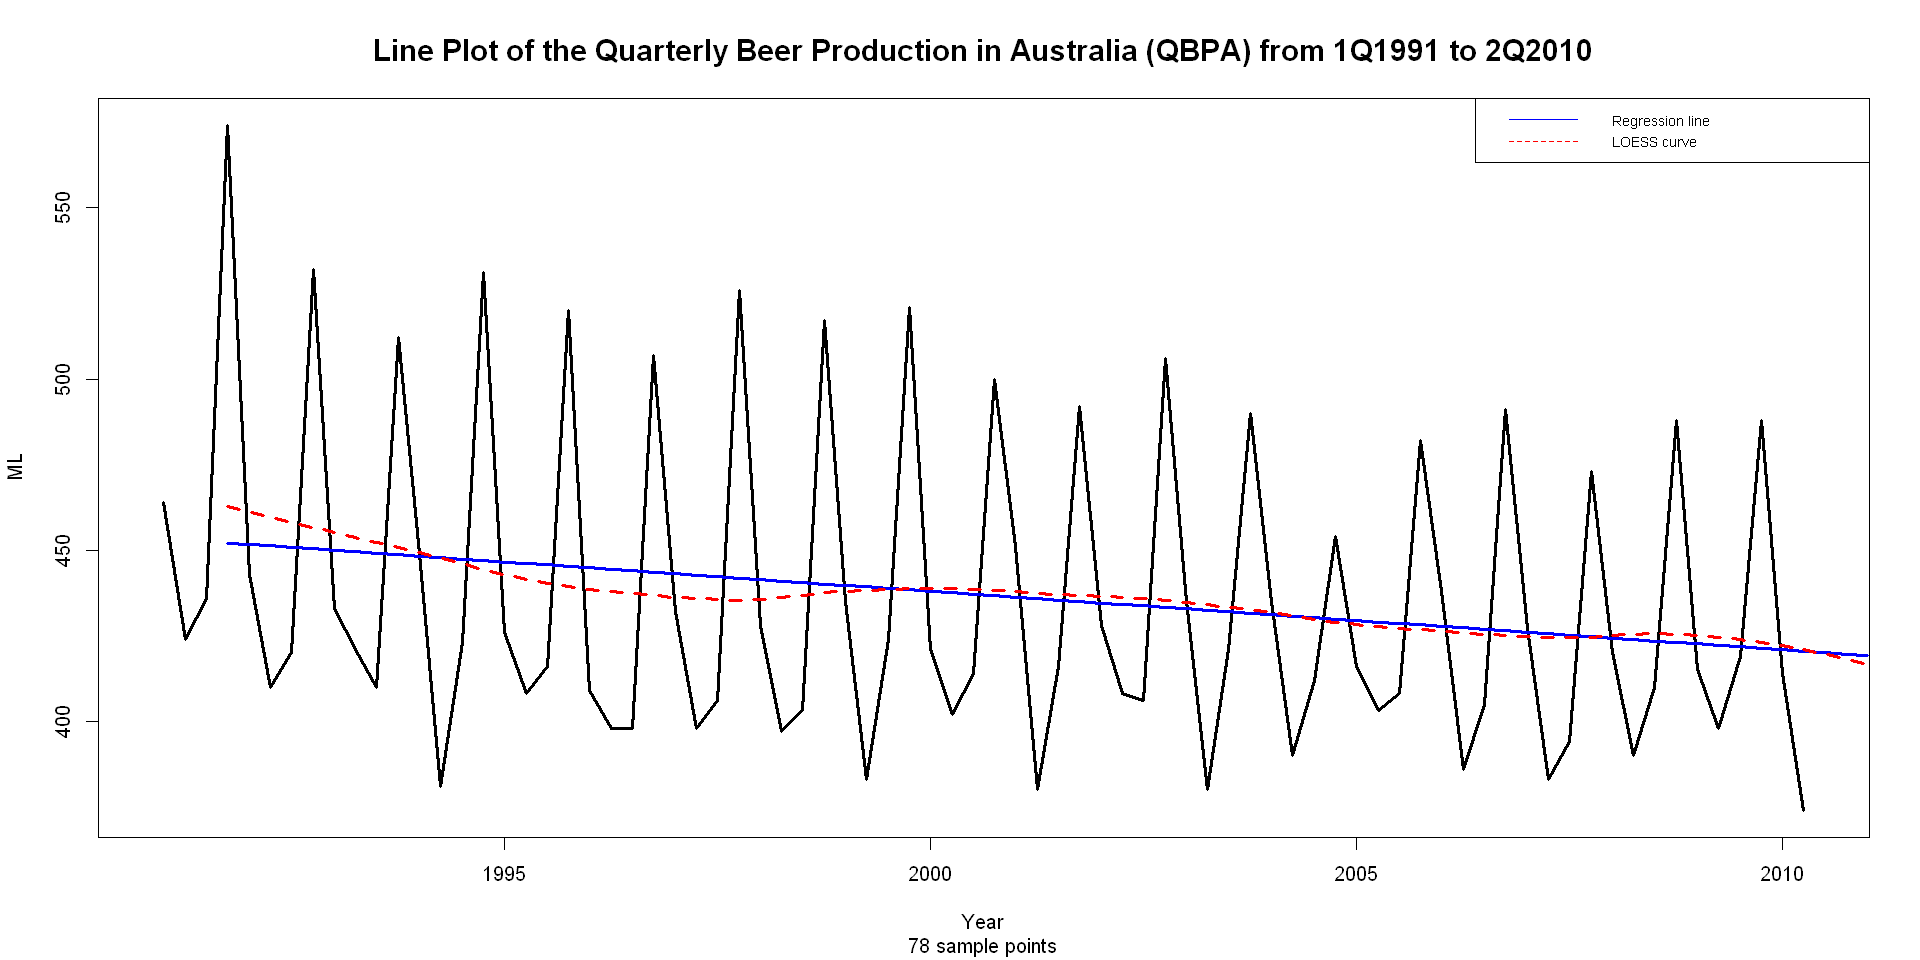

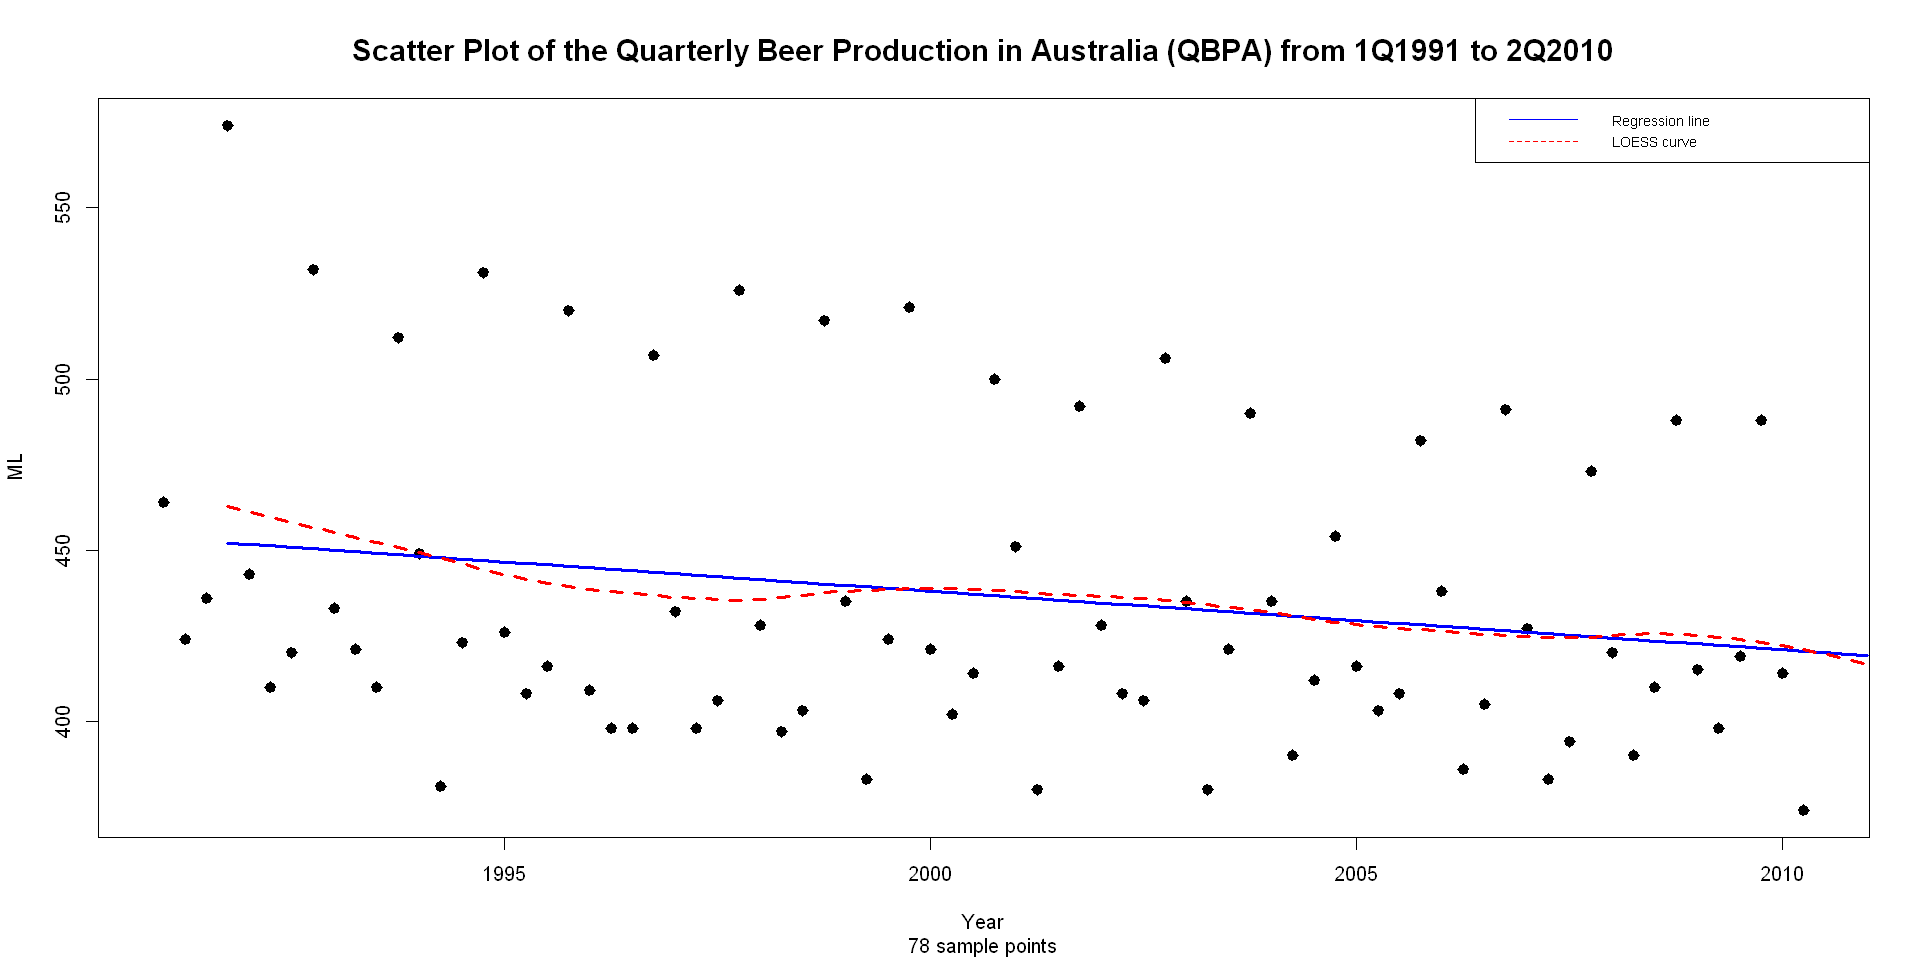

In [29]:
#line plot
plot(ausbeer.cut, type="l", lwd=3,
     main = "Line Plot of the Quarterly Beer Production in Australia (QBPA) from 1Q1991 to 2Q2010",
     sub = paste(length(ausbeer.cut), "sample points", sep=" "),
     xlab = "Year", ylab = "ML", 
     cex.axis=1, cex.main= 1.5, cex.sub = 1, cex.lab = 1)
loess.fit <- ts(loess(coredata(ausbeer.cut) ~ index(ausbeer.cut), span = 0.4)$fitted, start = c(1991,4), frequency = 4)
lm.fit <- ts(lm(coredata(ausbeer.cut) ~ index(ausbeer.cut))$fitted.values, start = c(1991,4), frequency = 4)
lines(lm.fit, col = "blue", lwd=3)
lines(loess.fit, col = "red", lwd=3, lty=2)
legend("topright", legend = c("Regression line", "LOESS curve"), cex = 0.7, col = c("blue","red"), lty=c(1,2))

#scatter plot
plot(ausbeer.cut, type="p", lwd=3, pch = 10,
     main = "Scatter Plot of the Quarterly Beer Production in Australia (QBPA) from 1Q1991 to 2Q2010",
     sub = paste(length(ausbeer.cut), "sample points", sep=" "),
     xlab = "Year", ylab = "ML",
     cex.axis=1, cex.main= 1.5, cex.sub = 1, cex.lab = 1)
loess.fit <- ts(loess(coredata(ausbeer.cut) ~ index(ausbeer.cut), span = 0.4)$fitted, start = c(1991,4), frequency = 4)
lm.fit <- ts(lm(coredata(ausbeer.cut) ~ index(ausbeer.cut))$fitted.values, start = c(1991,4), frequency = 4)
lines(lm.fit, col = "blue", lwd=3)
lines(loess.fit, col = "red", lwd=3, lty=2)
legend("topright", legend = c("Regression line", "LOESS curve"), cex = 0.7, col = c("blue","red"), lty=c(1,2))

[Torna all'indice](#Indice)

## 5 Modello additivo: studio delle componenti della serie storica

Per procedere con lo studio della serie storica è stato deciso di scomporla nella sue componenti principali con un approccio additivo. Secondo l'approccio additivo, la serie storica è definita dal seguente processo:

\begin{align}
Y(t)=T(t)+S(t)+e(t)\
\end{align}

dove:
* ***Y(t)*** è il dato riferito al periodo t
* ***T(t)*** è la componente trend al periodo t
* ***S(t)*** è la componente stagionale al periodo t
* ***e(t)*** è la componente irregolare al tempo t (rumore)

Va ricordato inoltre che la componente aleatoria (rumore) deve soddisfare alcune condizioni per essere definita come rumore bianco gaussiano:
* deve avere media nulla (stazionarietà)
* deve avere varianza costante (omoschedasticità)
* tutti i coefficienti di autocorrelazione non devono essere significativamente diversi da zero (scorrelazione)
* gaussianità

*Nota metodologica: è stato scelto un approccio additivo perchè, dalle analisi preliminari, l'ampiezza dell'oscillazione stagionale non sembrava variare significativamente col livello della serie, specialmente nella parte selezionata grazie al breakpoint. Se la fluttuazione stagionale fosse aumenta (o diminuita) proporzionalmente con l'aumento (o la diminuzione) del livello della serie, allora sarebbe stato più adeguato un modello moltiplicativo [^5].*

[^5]: Dagum, E. B. (2008). Analisi delle serie storiche: Modellistica, previsione e scomposizione. Milano: Springer.

Per rimuovere il trend e la stagionalità è stata sfruttata la tecnica della la media mobile applicandola rispettivamente agli anni e ai trimestri

#### Detrendizzazione

In [30]:
# Transforming ts in vector.
ausbeer.cut.vec <- as.vector(ausbeer.cut)
# Augmenting the vector by setting NA in place of the time series missed values
ausbeer.cut.vec <- append(ausbeer.cut.vec, rep(NA,2), after=length(ausbeer.cut.vec))
# Writing the augmented vector in matrix form.
ausbeer.cut.mat <- t(matrix(ausbeer.cut.vec, nrow=4))
# Yearly averaging by row averages.
ausbeer.cut.yearlymean.vec <- rowMeans(ausbeer.cut.mat, na.rm=TRUE)                  
# Writing the yearly averages in matrix form.
ausbeer.cut.yearlymean.mat <- matrix(rep(ausbeer.cut.yearlymean.vec,4), ncol=4)      
# Transforming the yearly average matrix in a vector.
ausbeer.cut.trend.vec <- as.vector(t(ausbeer.cut.yearlymean.mat))              
# Trasforming the yearly average vector in a time series.
ausbeer.cut.trend <- ts(ausbeer.cut.trend.vec, start=c(1991,1), end=c(2010,2), frequency=4)

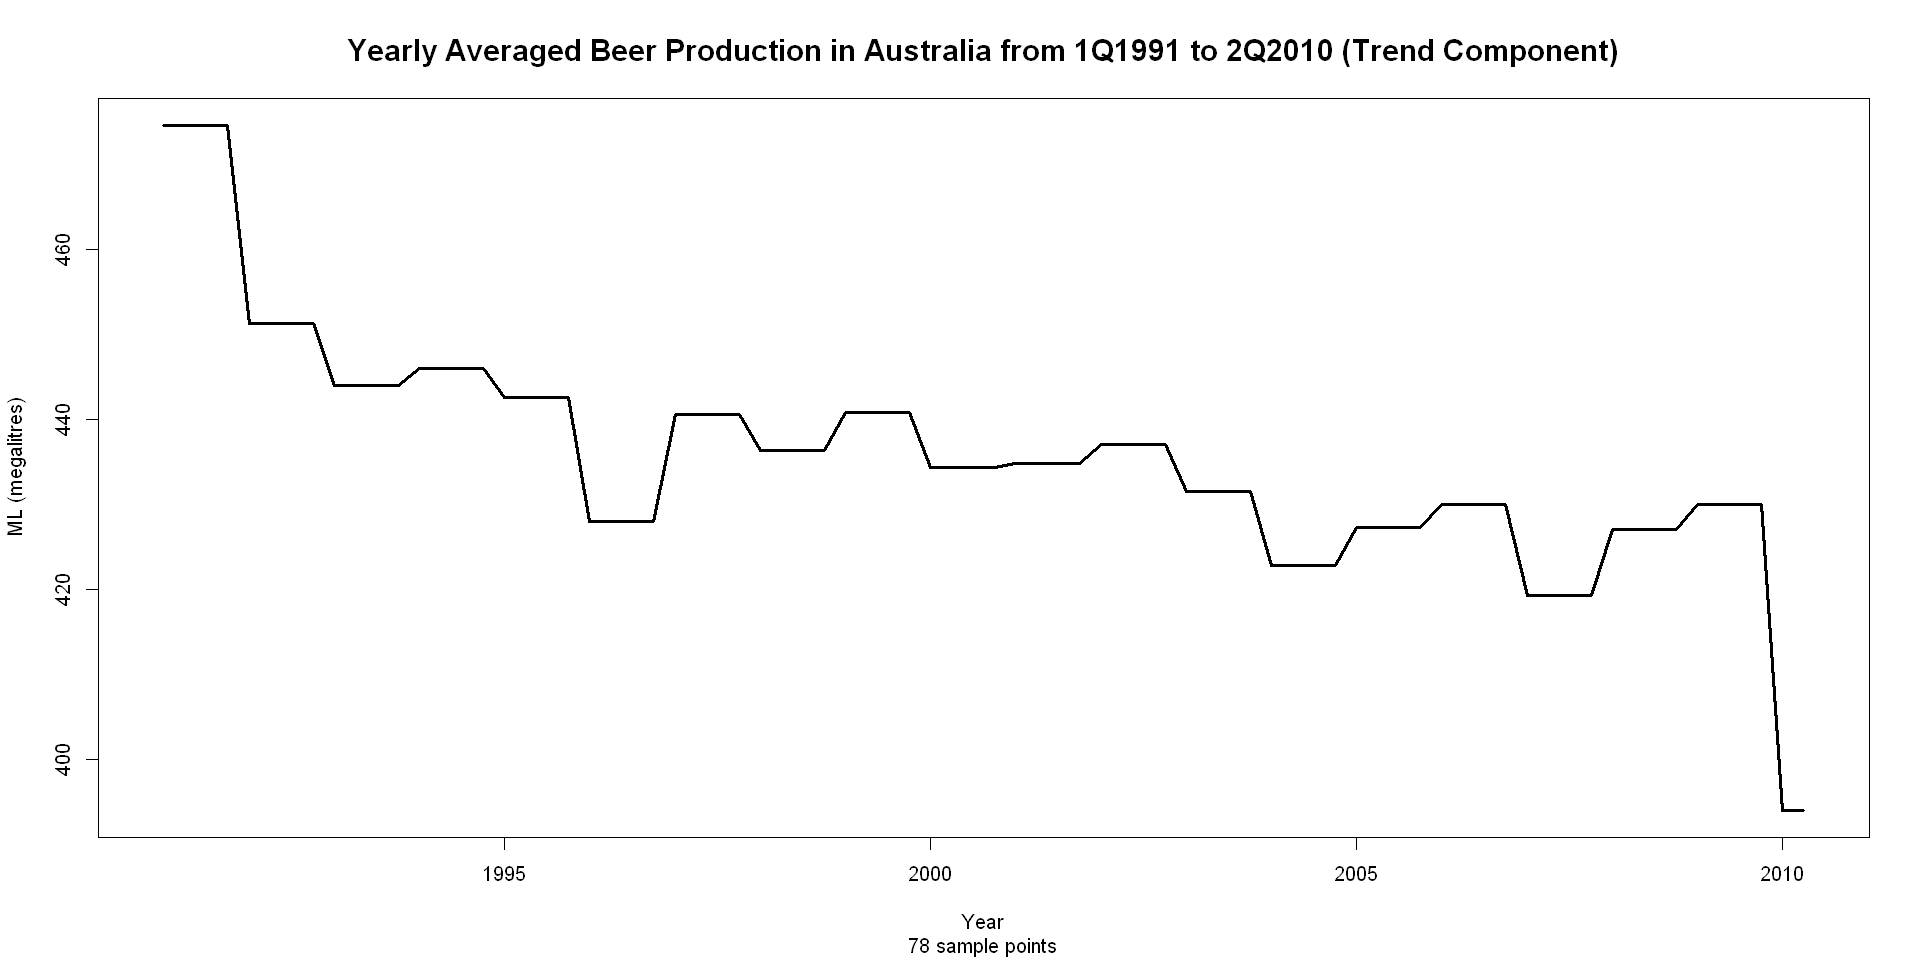

In [31]:
plot(ausbeer.cut.trend, type="l", lwd=3,
     main = "Yearly Averaged Beer Production in Australia from 1Q1991 to 2Q2010 (Trend Component)",
     sub = paste(length(ausbeer.cut.trend), "sample points", sep=" "),
     xlab = "Year", ylab = "ML (megalitres)", 
     cex.axis=1, cex.main= 1.5, cex.sub = 1, cex.lab = 1)

In [32]:
# Removing the trend.
ausbeer.cut.det <- ausbeer.cut-ausbeer.cut.trend

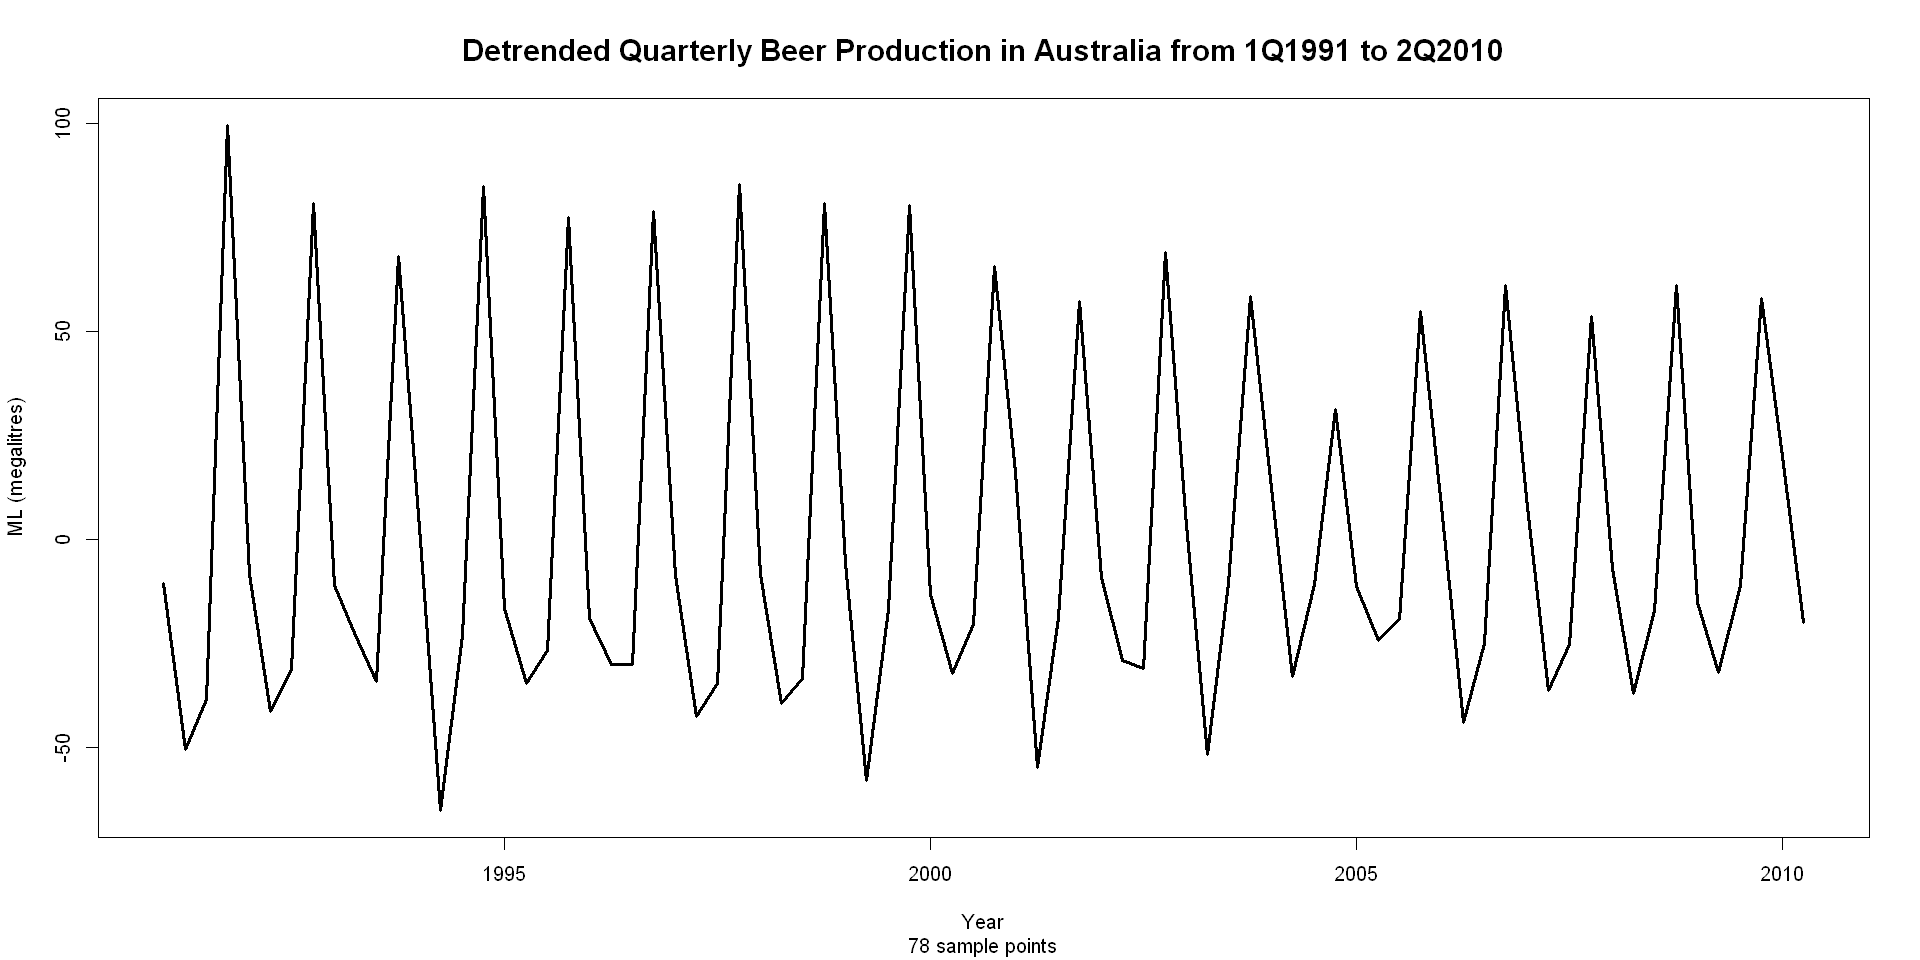

In [33]:
plot(ausbeer.cut.det, type="l", lwd=3,
     main = "Detrended Quarterly Beer Production in Australia from 1Q1991 to 2Q2010",
     sub = paste(length(ausbeer.cut.det), "sample points", sep=" "),
     xlab = "Year", ylab = "ML (megalitres)", 
     cex.axis=1, cex.main= 1.5, cex.sub = 1, cex.lab = 1)

#### Destagionalizzazione

In [34]:
## Now, we consider the deseasonalization of the detrended QBPA time series
# Transforming RWS_log_det_ts in vector.
ausbeer.cut.det.vec <- as.vector(ausbeer.cut.det)
# Augmenting the vector by setting NA in place of the time series missed values
ausbeer.cut.det.vec <- append(ausbeer.cut.det.vec, rep(NA,2), after=length(ausbeer.cut.det.vec))
# Writing the augmented vector in matrix form.
ausbeer.cut.det.mat <- t(matrix(ausbeer.cut.det.vec, nrow=4))
# Monthly (seasonal) averaging by column averages.
ausbeer.cut.det.monthlymean.vec <- colMeans(ausbeer.cut.det.mat, na.rm=TRUE)
# Writing the monthly averages in matrix form.
ausbeer.cut.det.monthlymean.mat <- t(matrix(rep(ausbeer.cut.det.monthlymean.vec,4), nrow=4))
# Transforming the monthly average matrix in a vector.
ausbeer.cut.seas.vec <- as.vector(t(ausbeer.cut.det.monthlymean.mat))
# Trasforming the monthly average vector in a time series.
ausbeer.cut.seas <- ts(ausbeer.cut.seas.vec, start=c(1991,1), end= c(2010,2), frequency=4)

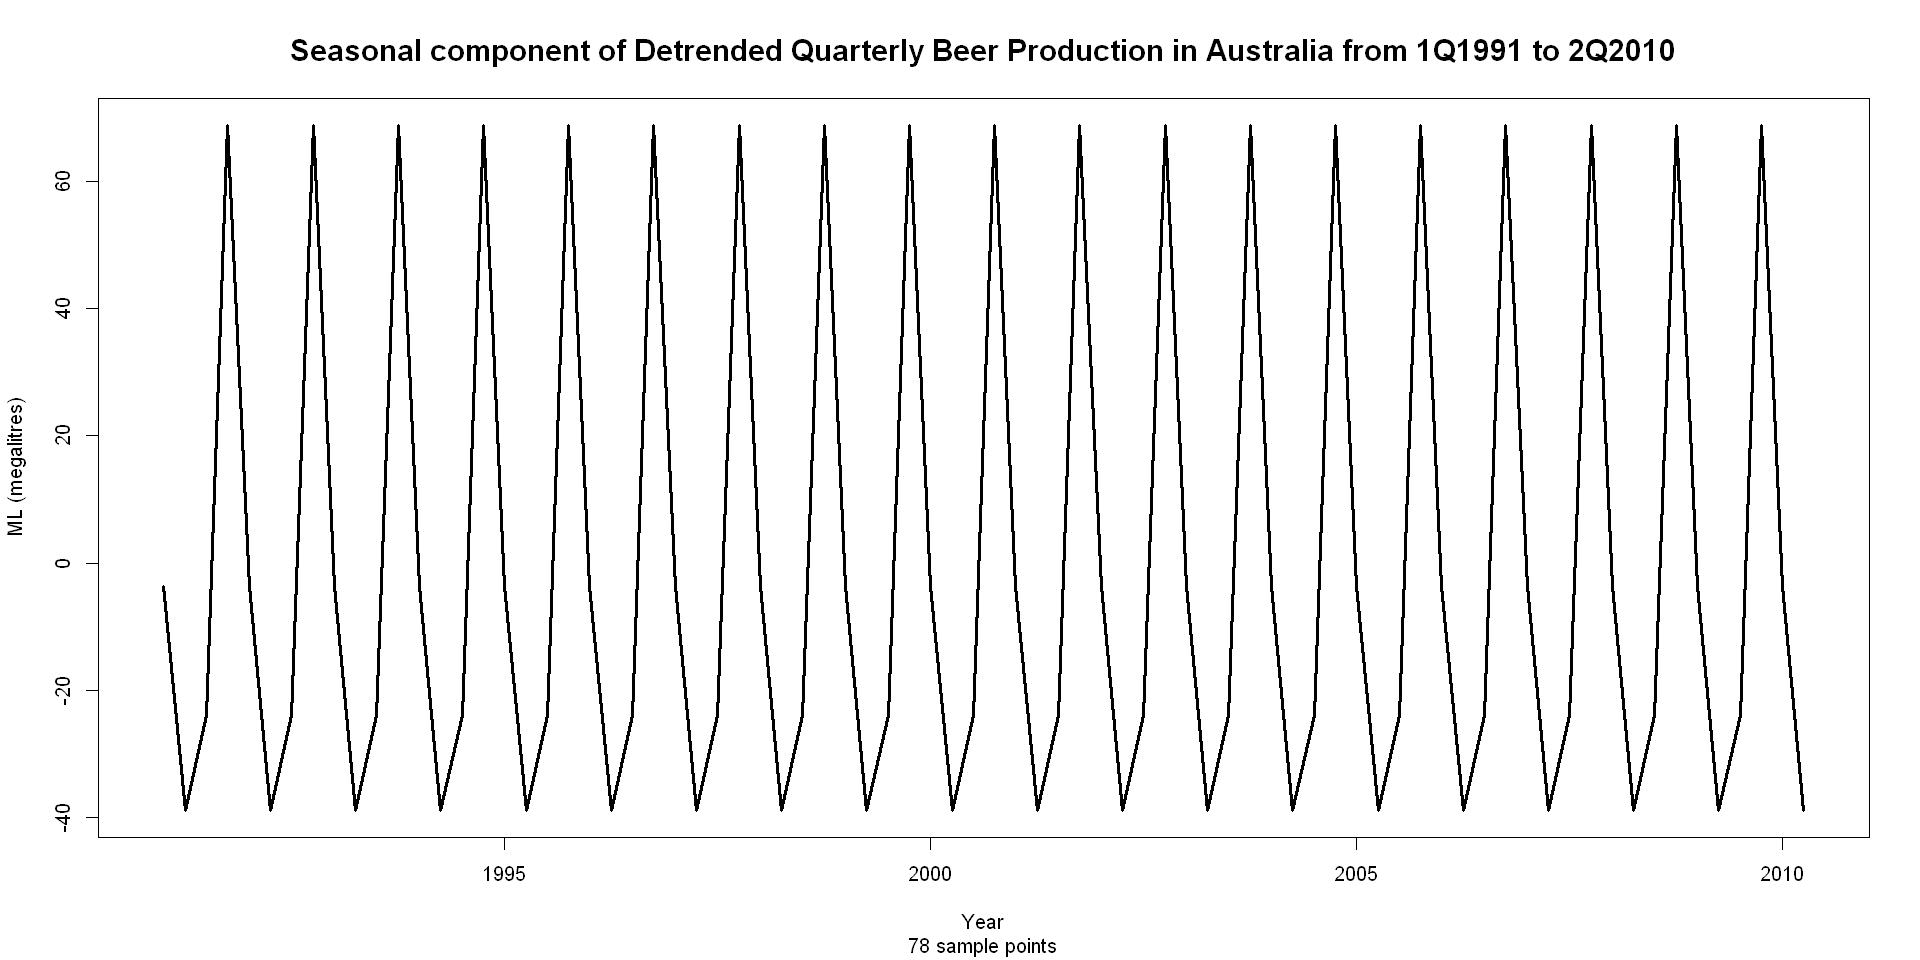

In [35]:
plot(ausbeer.cut.seas, type="l", lwd=3,
     main = "Seasonal component of Detrended Quarterly Beer Production in Australia from 1Q1991 to 2Q2010",
     sub = paste(length(ausbeer.cut.seas), "sample points", sep=" "),
     xlab = "Year", ylab = "ML (megalitres)", 
     cex.axis=1, cex.main= 1.5, cex.sub = 1, cex.lab = 1)

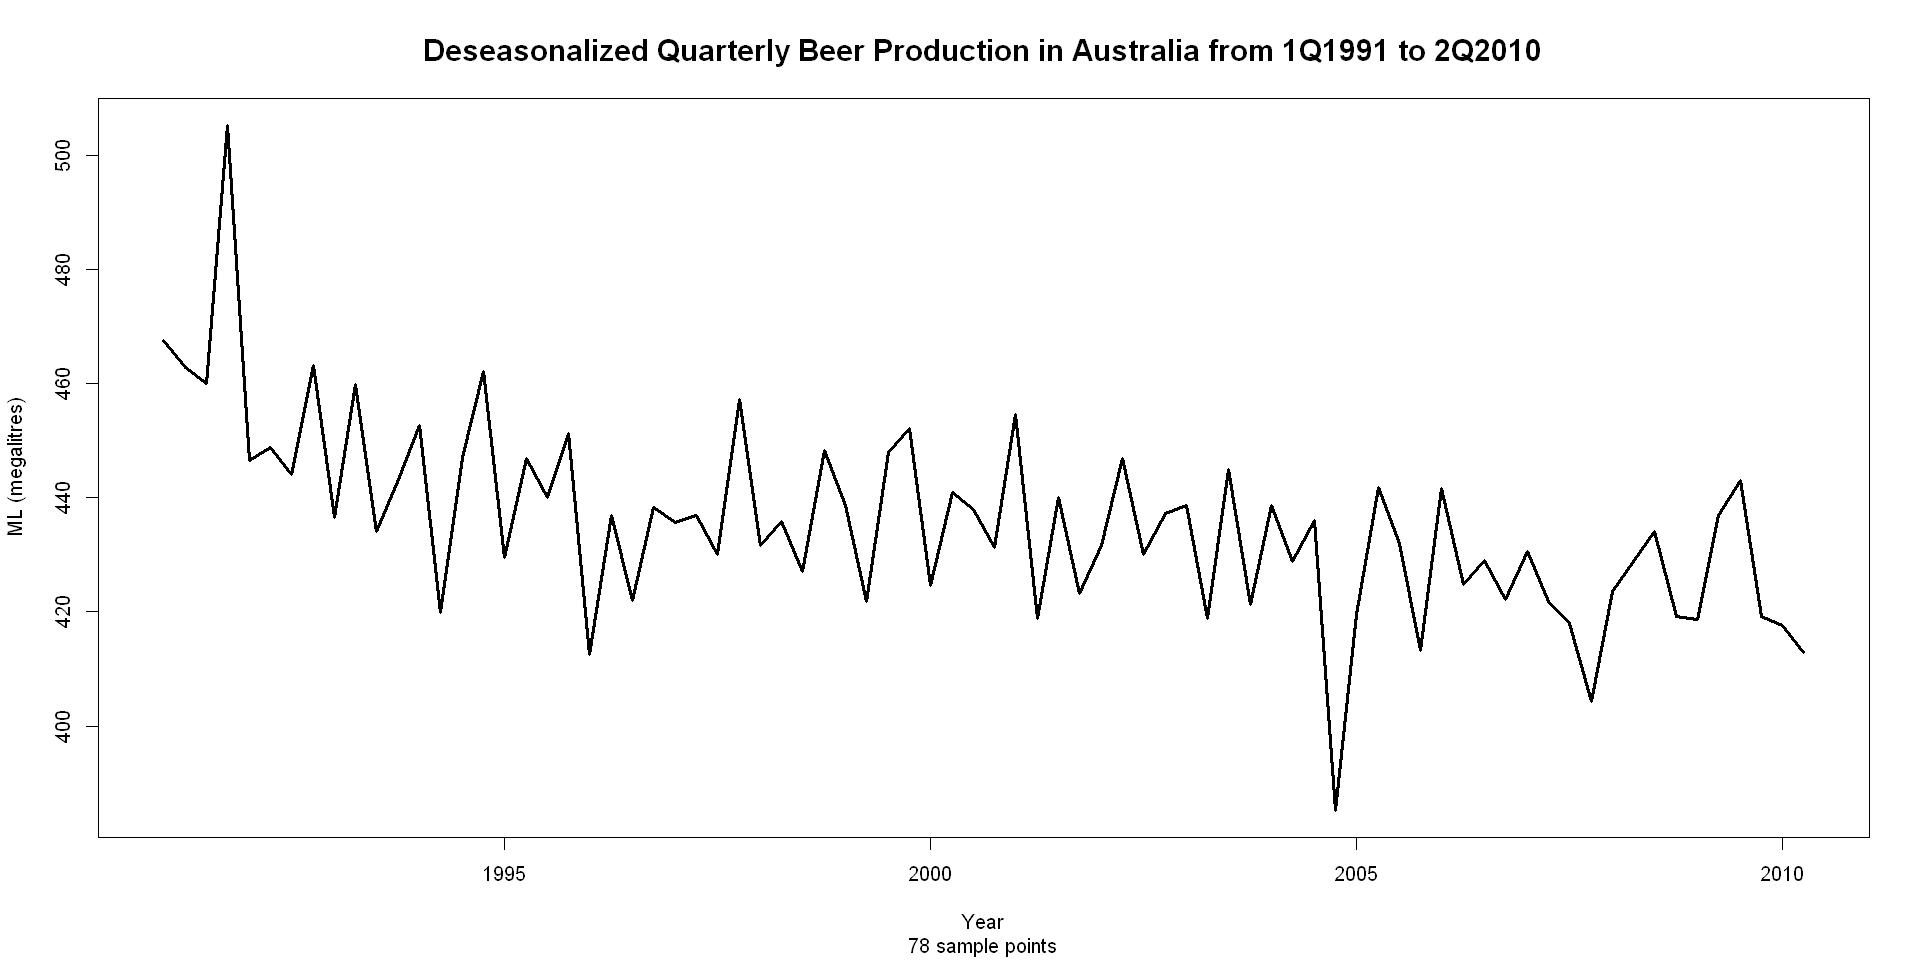

In [36]:
ausbeer.cut.deseas <- ausbeer.cut-ausbeer.cut.seas
plot(ausbeer.cut.deseas, type="l", lwd=3,
     main = "Deseasonalized Quarterly Beer Production in Australia from 1Q1991 to 2Q2010",
     sub = paste(length(ausbeer.cut.deseas), "sample points", sep=" "),
     xlab = "Year", ylab = "ML (megalitres)", 
     cex.axis=1, cex.main= 1.5, cex.sub = 1, cex.lab = 1)

#### Rumore

Ottenute le componenti di trend e di stagionalità è possibile individuare il rumore sottraendo dalla serie di partenza il trend e la stagionalità

In [37]:
ausbeer.cut.noise <- ausbeer.cut - ausbeer.cut.trend - ausbeer.cut.seas

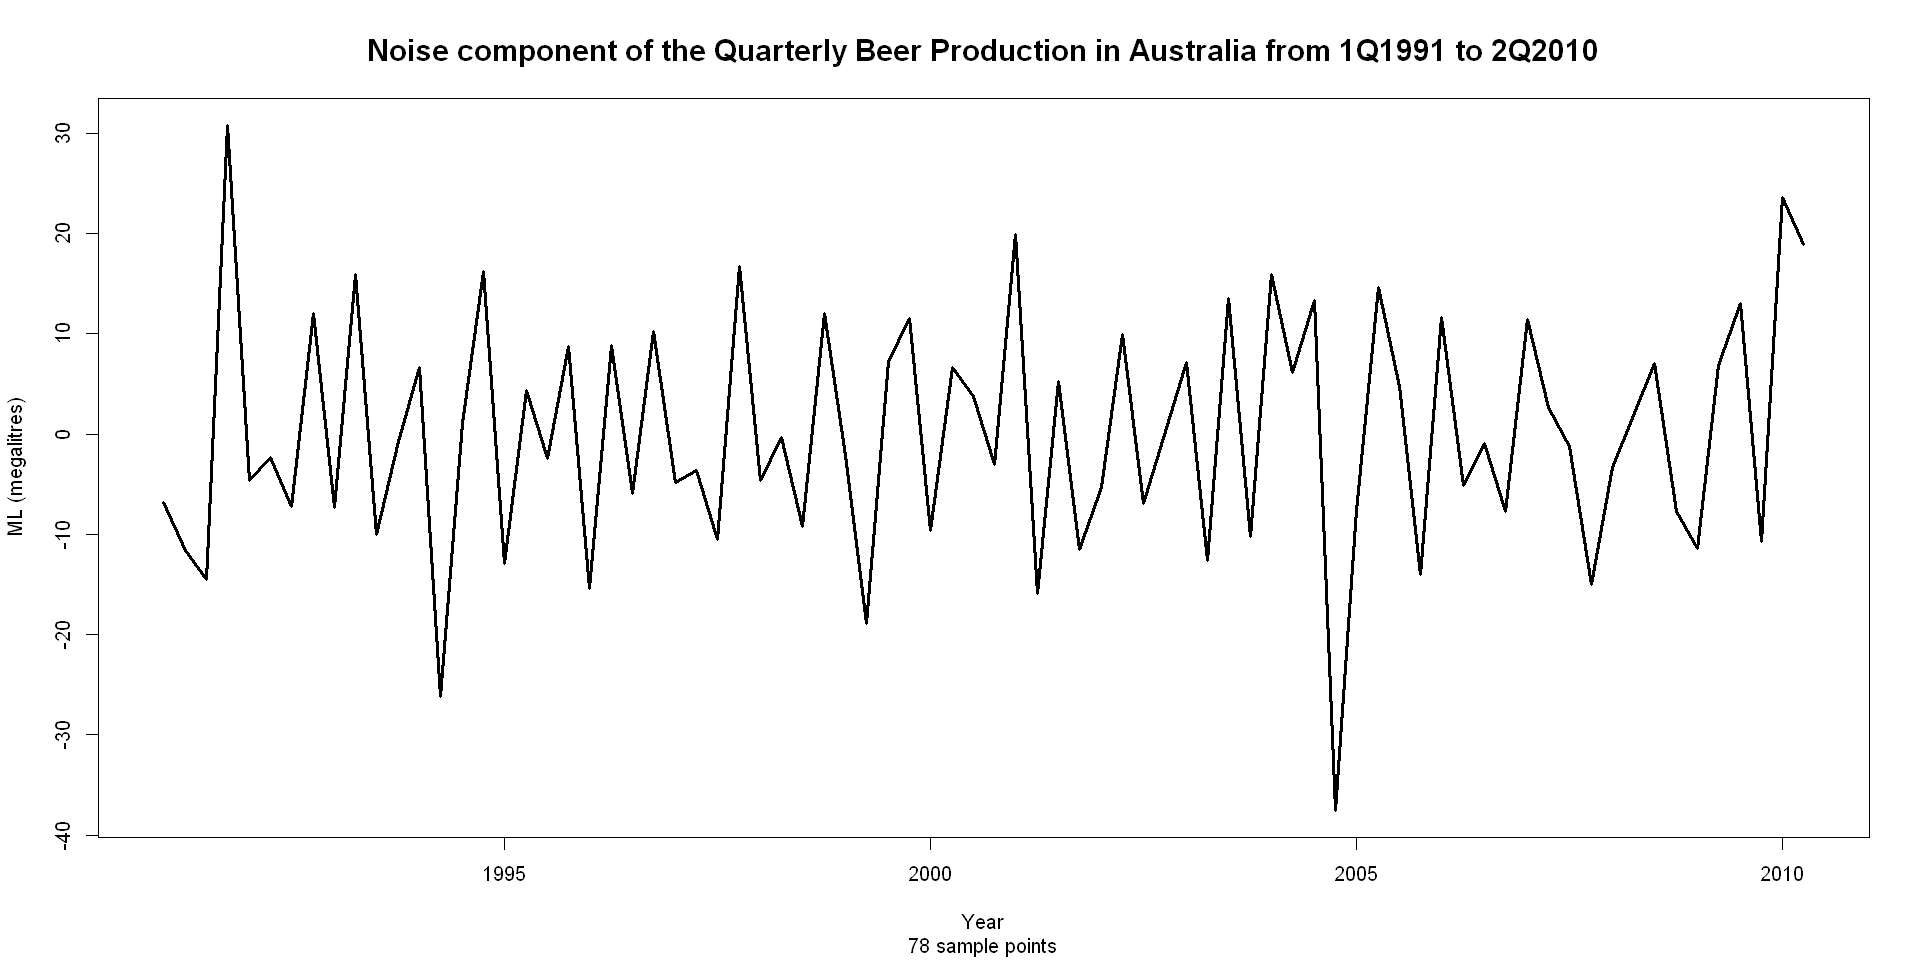

In [38]:
plot(ausbeer.cut.noise, type="l", lwd=3,
     main = "Noise component of the Quarterly Beer Production in Australia from 1Q1991 to 2Q2010",
     sub = paste(length(ausbeer.cut.noise), "sample points", sep=" "),
     xlab = "Year", ylab = "ML (megalitres)", 
     cex.axis=1, cex.main= 1.5, cex.sub = 1, cex.lab = 1)

[Torna all'indice](#Indice)

### 5.1 Studio del rumore

A questo punto bisogna verificare le proprietà del rumore ottenuto ed eventualmente procedere con la modellazione dello stesso. Si ricorda che si vuole ottenere un *white noise gaussiano* ovvero un rumore omoschedastico, stazionario, scorrelato e normale.

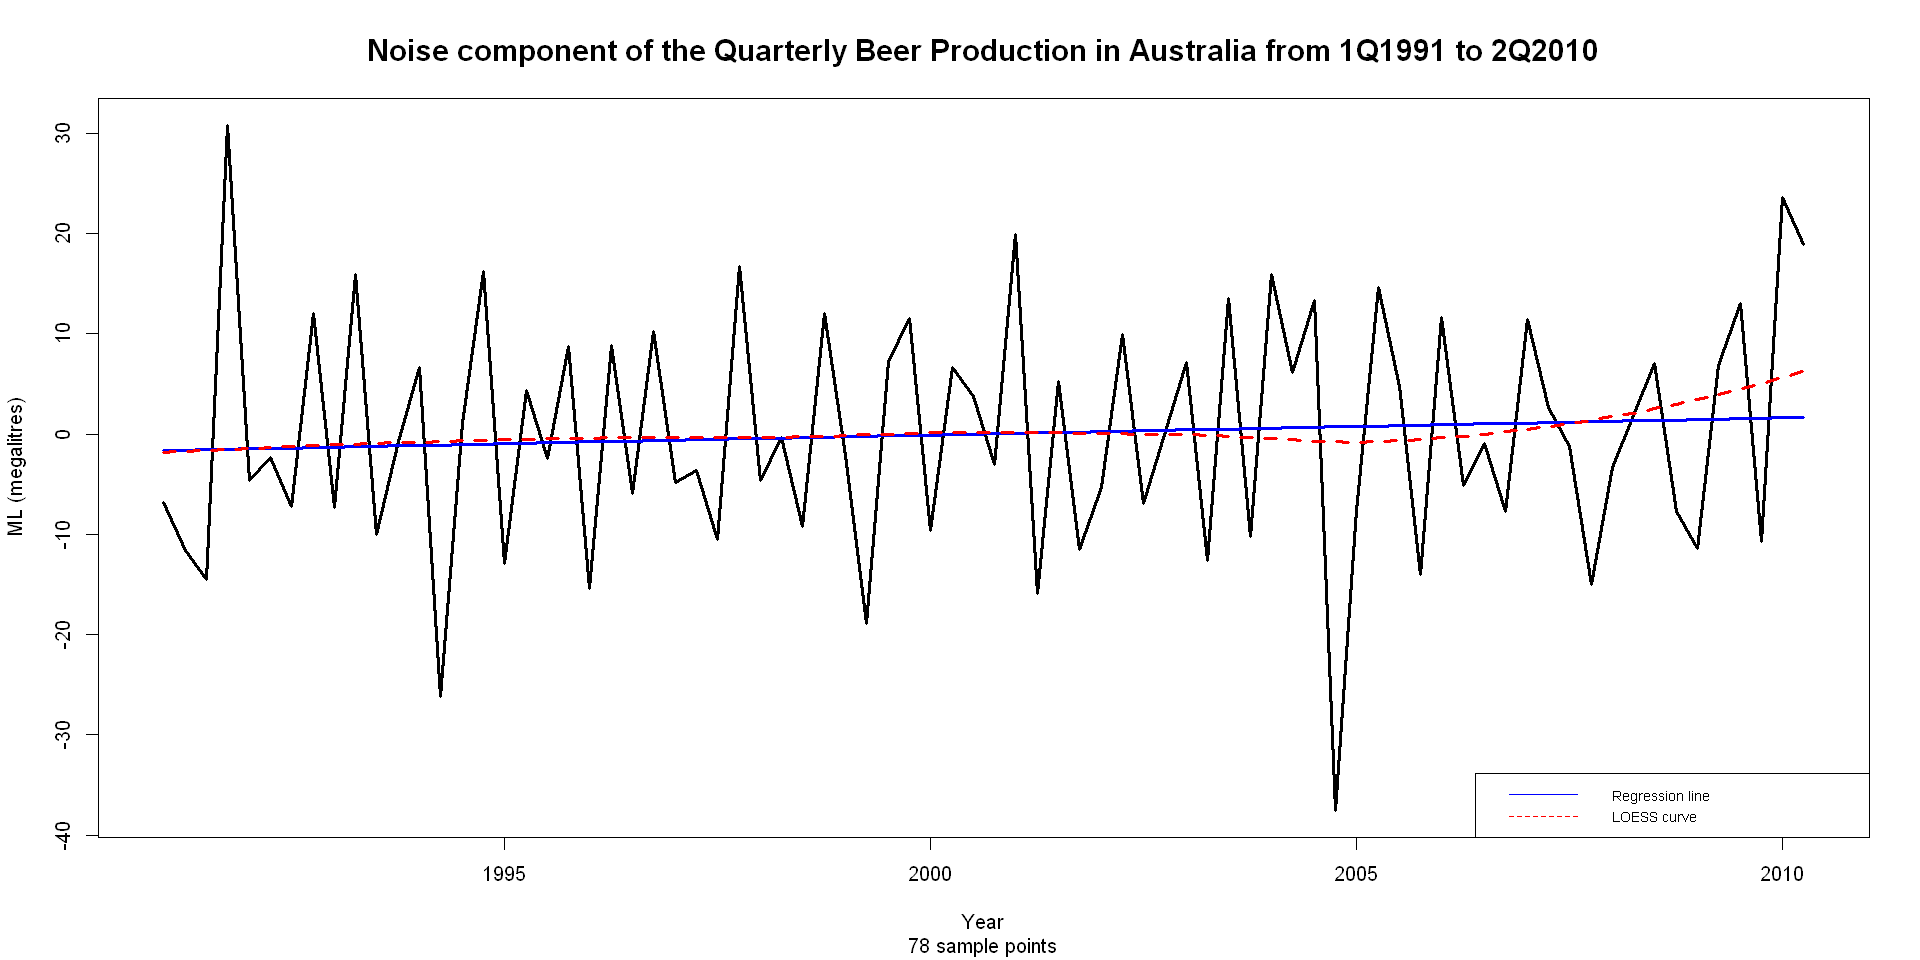

In [39]:
plot(ausbeer.cut.noise, type="l", lwd=3, 
     main = "Noise component of the Quarterly Beer Production in Australia from 1Q1991 to 2Q2010",
     sub = paste(length(ausbeer.cut.noise), "sample points", sep=" "),
     xlab = "Year", ylab = "ML (megalitres)", 
     cex.axis=1, cex.main= 1.5, cex.sub = 1, cex.lab = 1)
loess.fit <- ts(loess(coredata(ausbeer.cut.noise) ~ index(ausbeer.cut.noise), span = 0.8)$fitted, start = c(1991,1), frequency = 4)
lm.fit <- ts(lm(coredata(ausbeer.cut.noise) ~ index(ausbeer.cut.noise))$fitted.values, start = c(1991,1), frequency = 4)
lines(lm.fit, col = "blue", lwd=3)
lines(loess.fit, col = "red", lwd=3, lty=2)
legend("bottomright", legend = c("Regression line", "LOESS curve"), cex = 0.7, col = c("blue","red"), lty=c(1,2))

#### 5.1.1 Gaussianità

Come primo passo della verifica delle proprietà del rumore decido di verificarne la gaussianità in quanto avere un'idea chiara della distribuzione mi aiuta a fare scelte più consapevoli anche in fase di test dell'omoschedasticità.

Decido innanzitutto di visualizzare un sommario del rumore e confrontarlo con i valori di una normale centrata in 0 con la stessa deviazione standard.

In [40]:
summary(ausbeer.cut.noise)
print(paste("SD:", round(sd(ausbeer.cut.noise),2)))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-37.513  -7.763  -1.099   0.000   8.840  30.737 

[1] "SD: 11.95"


In [41]:
theo.gauss <- function(ts){
  sd <- sd(ts)
  theo.min <- round(-3*sd,3)
  theo.max <- round(3*sd,3)
  theo.1Q <- round(qnorm(0.25, mean = 0 , sd = sd, lower.tail = T),3)
  theo.median <- 0
  theo.3Q <- round(qnorm(0.75, mean = 0 , sd = sd, lower.tail = T),3)
  print(cbind(theo.min,theo.1Q, theo.median , theo.3Q , theo.max))
}

In [42]:
theo.gauss(ausbeer.cut.noise)

     theo.min theo.1Q theo.median theo.3Q theo.max
[1,]  -35.848   -8.06           0    8.06   35.848


Da una prima analisi si può ipotizzare una certa vicinanza tra i valori teorici e quelli campionari, tuttavia emergono alcuni indizi di asimmetria (mediana diversa da 0) e di curtosi (valore minimo al di fuori dell'intervallo); decido dunque di calcolare l'asimmetria e la curtosi e di disegnare un grafico di comparazione tra la distribuzione osservata e quella teorica.

In [43]:
ausbeer.cut.noise.skew <- skewness(ausbeer.cut.noise) #theo 0
ausbeer.cut.noise.kurt <- kurtosis(ausbeer.cut.noise) # theo 3
print(cbind(ausbeer.cut.noise.skew,ausbeer.cut.noise.kurt))

     ausbeer.cut.noise.skew ausbeer.cut.noise.kurt
[1,]              -0.111381              0.1840551


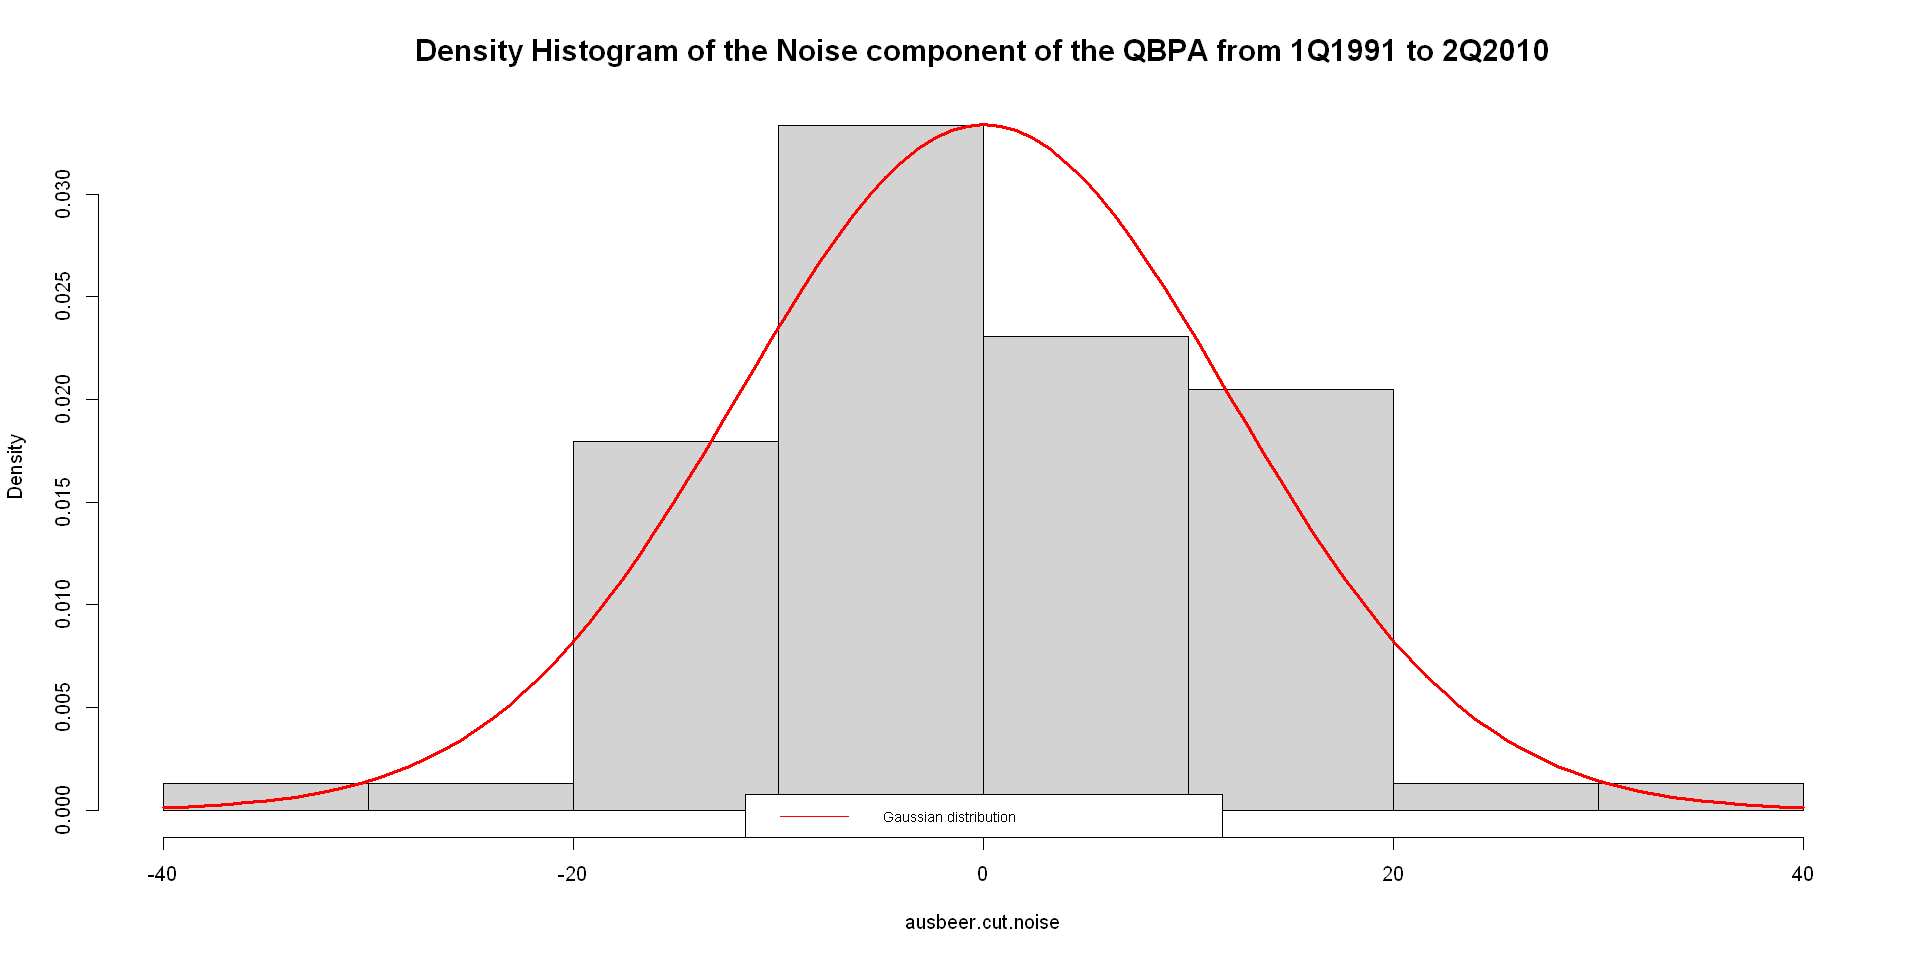

In [44]:
hist(ausbeer.cut.noise, freq = FALSE, 
    main = "Density Histogram of the Noise component of the QBPA from 1Q1991 to 2Q2010",
    cex.axis=1, cex.main= 1.5, cex.sub = 1, cex.lab = 1)
curve(dnorm(x,mean=0,sd=sd(ausbeer.cut.noise)), add=TRUE,col="red", lwd=3)
legend("bottom", legend = "Gaussian distribution", cex = 0.7, col = "red", lty=c(1,2))

Come è possibile osservare sia dal grafico che dai valori di asimmetria e curtosi, la distribuzione è abbastanza simmetrica e platicurtica, ma non si discosta molto dal modello gaussiano. Procedo dunque con la verifica visiva e numerica della gaussianità.

[1] 56  4

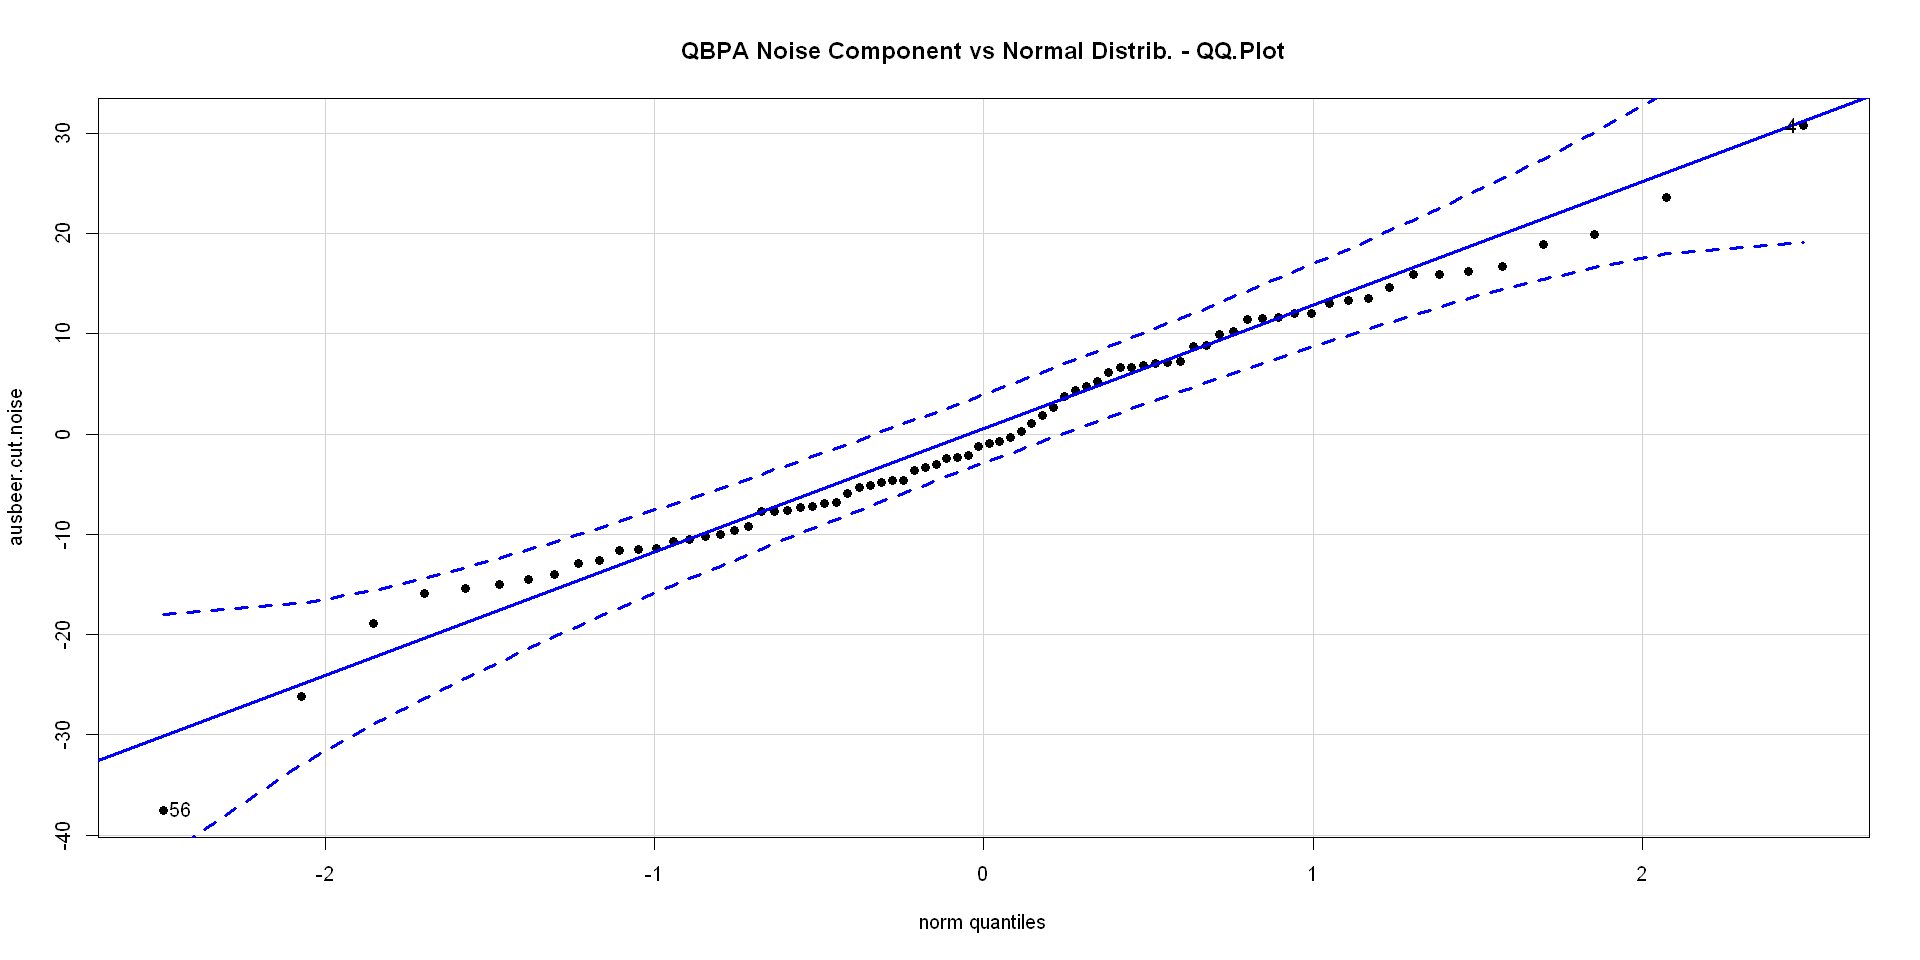

In [45]:
qqPlot(ausbeer.cut.noise, lwd=3, pch=16,
      main = "QBPA Noise Component vs Normal Distrib. - QQ.Plot")

In [46]:
jarque.bera.test(ausbeer.cut.noise) # Jarque-Bera ## H0: The data is normally distributed.
shapiro.test(ausbeer.cut.noise) # Shapiro-Wilks ## H0: The data is normally distributed.
dagoTest(ausbeer.cut.noise) # D’Agostino Pearson ## H0: The data is normally distributed.


	Jarque Bera Test

data:  ausbeer.cut.noise
X-squared = 0.39984, df = 2, p-value = 0.8188



	Shapiro-Wilk normality test

data:  ausbeer.cut.noise
W = 0.98463, p-value = 0.4715



Title:
 D'Agostino Normality Test

Test Results:
  STATISTIC:
    Chi2 | Omnibus: 0.891
    Z3  | Skewness: -0.441
    Z4  | Kurtosis: 0.8346
  P VALUE:
    Omnibus  Test: 0.6405 
    Skewness Test: 0.6592 
    Kurtosis Test: 0.4039 

Description:
 Tue Dec 22 23:14:26 2020 by user: Marco


Vista l'indicazione visiva di normalità del QQPlot e la conferma dei test statistici (Jarque Bera, Shapiro-Wilk, D'Agostino-Pearson) è possibile ipotizzare che la distribuzione che ha generato il rumore sia ragionevolmente una distirbuzione normale.

*Nota metodologica: è stato considerato un livello di significatività α=.05*

#### 5.1.2 Stazionarietà

Dall'analisi grafica il rumore sembra stazionario in quanto la loess non si discosta dalla retta di regressione lineare, tuttavia cerco conferma con i test statistici:

In [47]:
adf.lags <- floor(12*(length(ausbeer.cut.noise)/100)^1/4) # as suggested by Schwert 
adf.test(ausbeer.cut.noise, k=adf.lags) # Dickey-Fuller ## H0: the data are non-stationary
kpss.test(ausbeer.cut.noise) # Kwiatkowski, Phillips, Schmidt and Shin ## H0: time series is trend-stationary


	Augmented Dickey-Fuller Test

data:  ausbeer.cut.noise
Dickey-Fuller = -7.8354, Lag order = 2, p-value = 0.01
alternative hypothesis: stationary



	KPSS Test for Level Stationarity

data:  ausbeer.cut.noise
KPSS Level = 0.13796, Truncation lag parameter = 3, p-value = 0.1


Sia il test di Dickey-Fuller sia il test di Kwiatkowski, Phillips, Schmidt e Shin confermano la stazionarietà del rumore

*Nota metodologica: è stato considerato un livello di significatività α=.05*

#### 5.1.3 Omoschedasticità

Il plot del rumore suggerisce un comportamento omoschedastico, tuttavia procedo con i test statistici per trovare una conferma all'evidenza visiva.

*Nota metodologica: Applico i test non studentizzati perchè la normalità nel rumore è ragionevolmente rispettata*

In [48]:
ausbeer.cut.noise.lm <- lm(coredata(ausbeer.cut.noise) ~ index(ausbeer.cut.noise))
print("------ Breusch-Pagan test ------")
bptest(ausbeer.cut.noise.lm, studentize = FALSE) # Breusch-Pagan ## H0: Equal/constant variances
print("------ White test ------")
bptest(ausbeer.cut.noise.lm,  ~ index(ausbeer.cut.noise.lm) + I(index(ausbeer.cut.noise.lm)^2) , studentize = FALSE) # White ## H0: Equal/constant variances
print("------ White-Wooldridge test ------")
bptest(ausbeer.cut.noise.lm,  ~ ausbeer.cut.noise.lm$fitted + I(ausbeer.cut.noise.lm$fitted^2) , studentize = FALSE) # White-Wooldridge ## H0: Equal/constant variances

[1] "------ Breusch-Pagan test ------"



	Breusch-Pagan test

data:  ausbeer.cut.noise.lm
BP = 2.1144e-06, df = 1, p-value = 0.9988


[1] "------ White test ------"



	Breusch-Pagan test

data:  ausbeer.cut.noise.lm
BP = 0.97684, df = 2, p-value = 0.6136


[1] "------ White-Wooldridge test ------"



	Breusch-Pagan test

data:  ausbeer.cut.noise.lm
BP = 0.84131, df = 2, p-value = 0.6566


Tutti i test statistici (Breusch-Pagan, White, White-Wooldridge) confermano l'ipotesi di omoschedasticità. Il rumore dunque è da considerarsi omoschedastico.

*Nota metodologica: è stato considerato un livello di significatività α=.05*

#### 5.1.4 Scorrelazione

Infine costruisco l'autocorrelogramma globale e l'autocorrelogramma parziale per verificare che non ci sia autocorrelazione nel rumore; eseguo, inoltre, i test statistici come ulteriore evidenza.

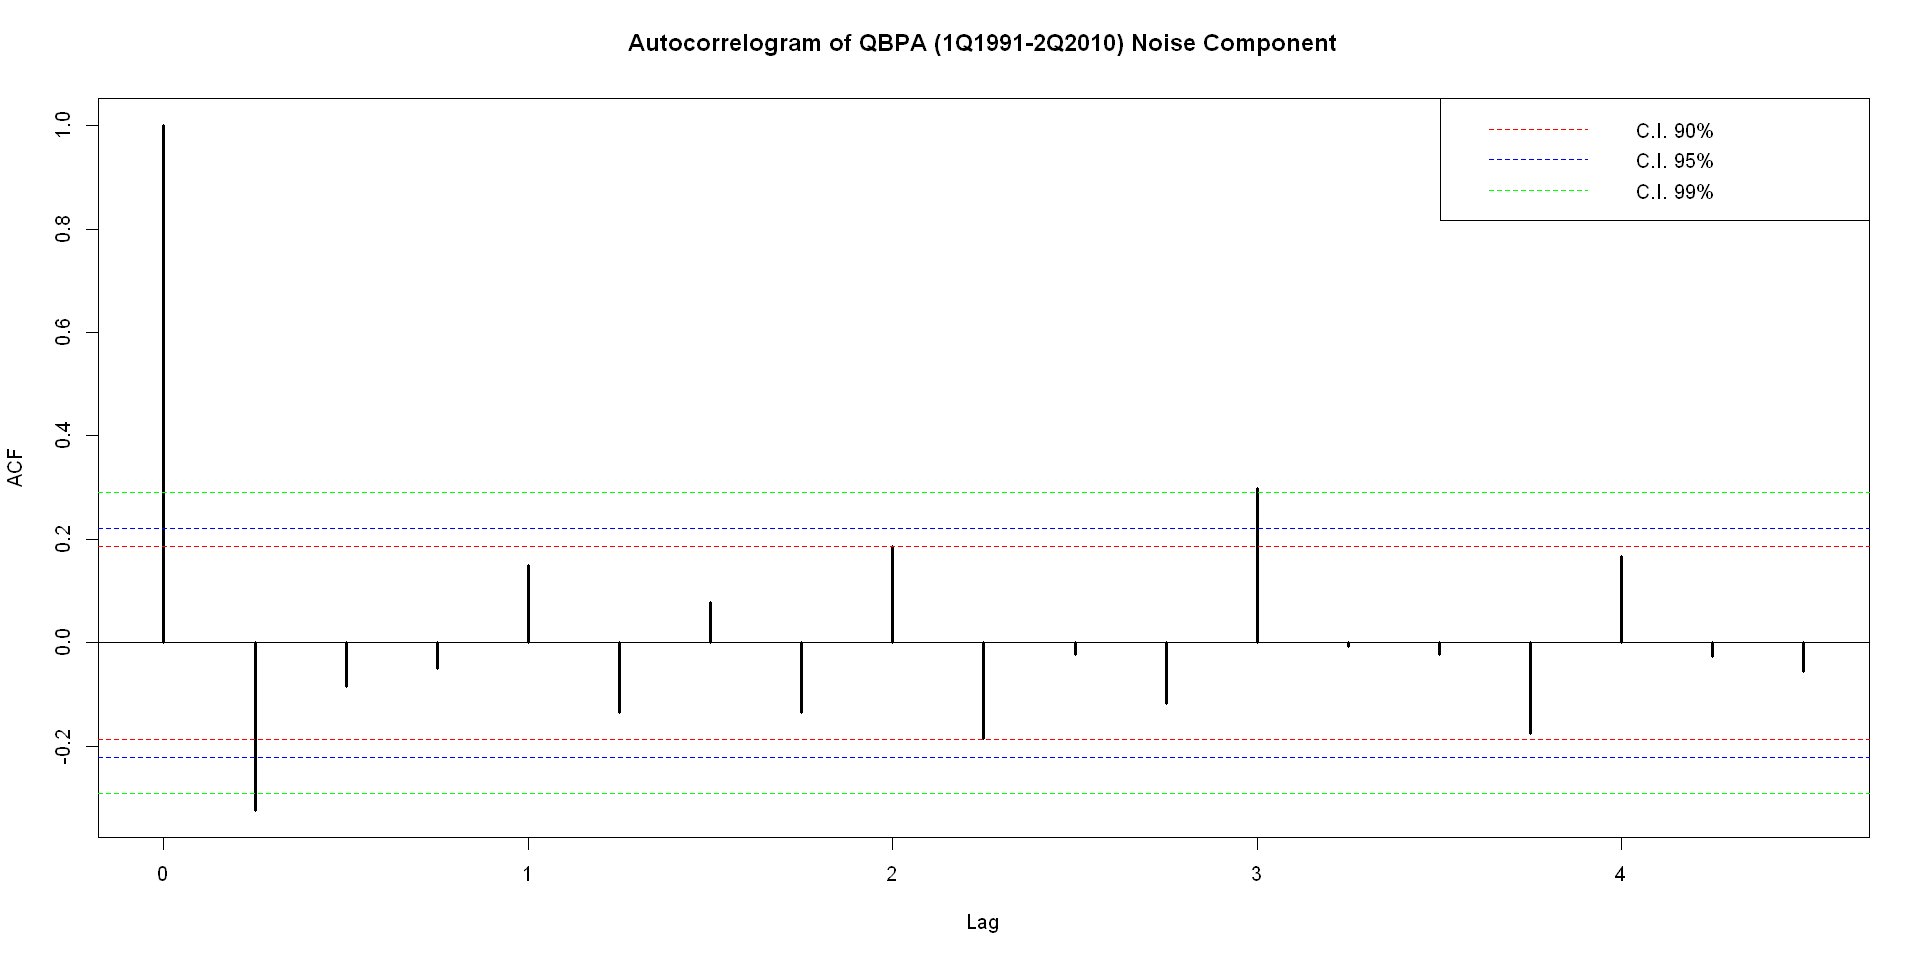

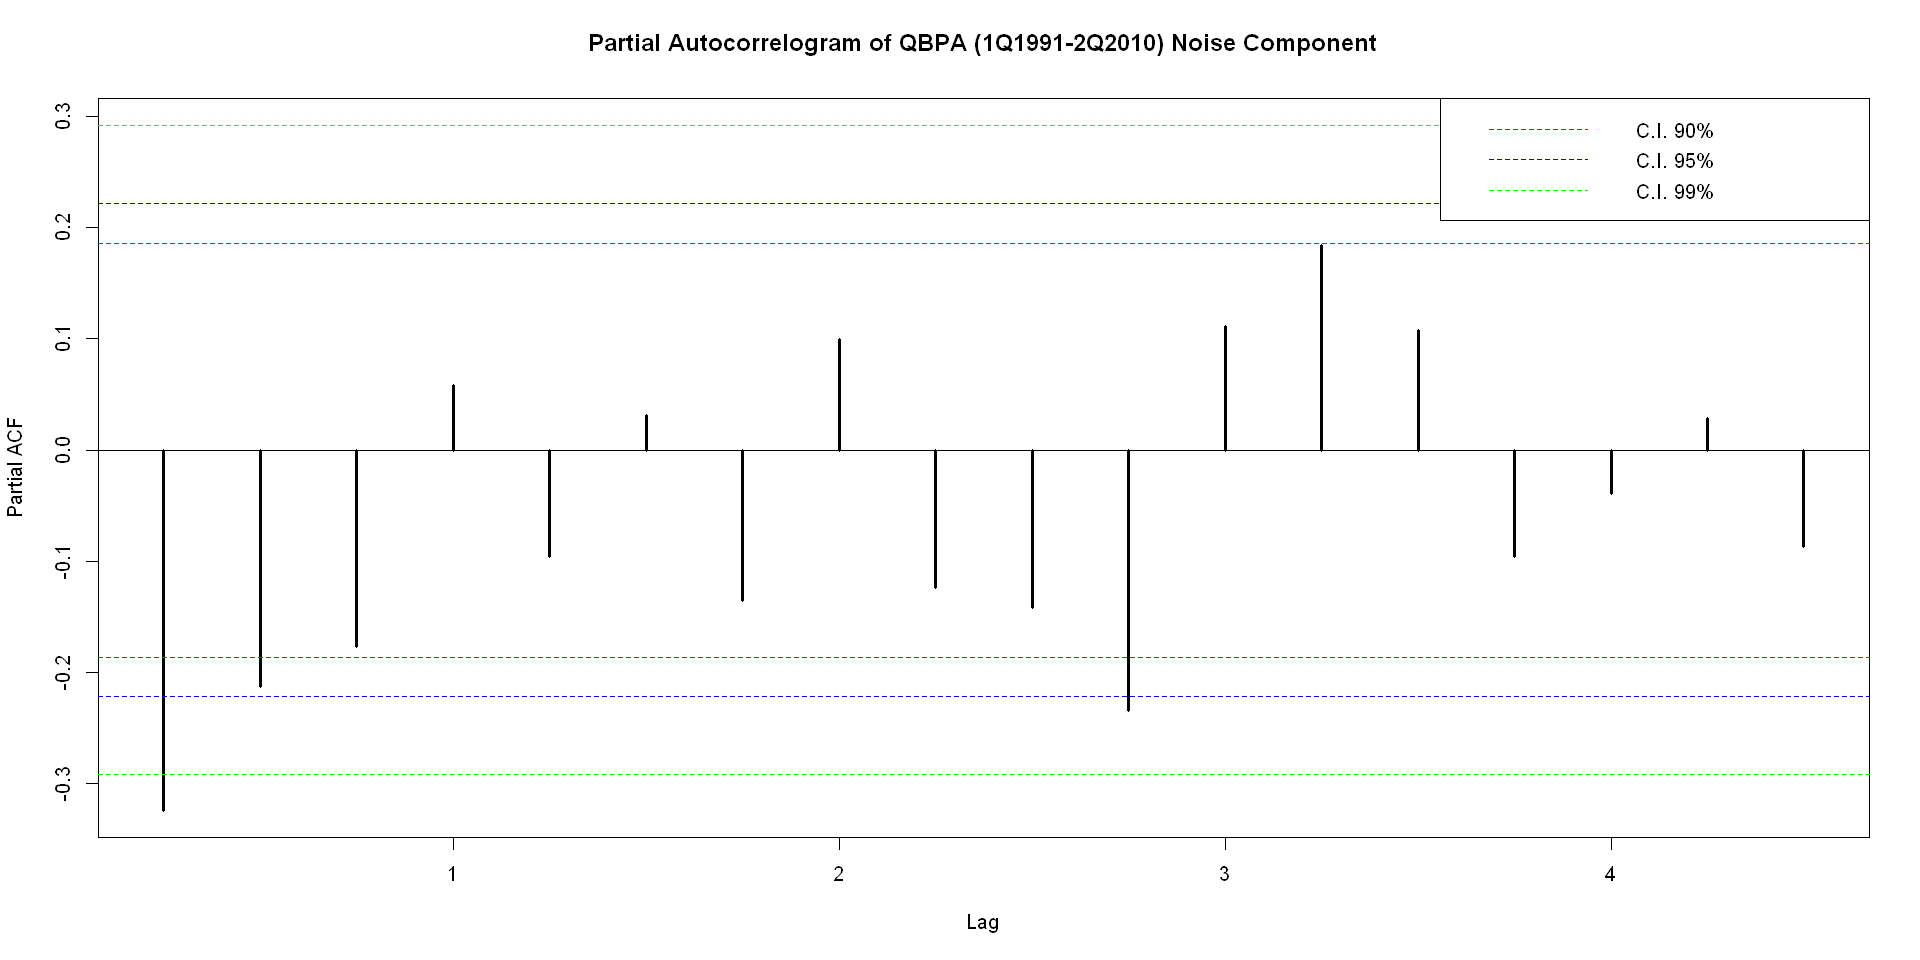

In [49]:
acf(ausbeer.cut.noise, lwd=3,
    main="Autocorrelogram of QBPA (1Q1991-2Q2010) Noise Component",
    ci = c(0.90,0.95, 0.99), ci.col=c("red", "blue", "green"),
    cex.axis=1, cex.main= 1.5, cex.sub = 1, cex.lab = 1)
legend("topright", 
       legend = c("C.I. 90%", "C.I. 95%", "C.I. 99%"), 
       col = c("red", "blue", "green"), lty=c(2,2,2))

pacf(ausbeer.cut.noise, lwd=3,
    main="Partial Autocorrelogram of QBPA (1Q1991-2Q2010) Noise Component",
    ci = c(0.90,0.95, 0.99), ci.col=c("red", "blue", "green"),
    cex.axis=1, cex.main= 1.5, cex.sub = 1, cex.lab = 1)
legend("topright", 
       legend = c("C.I. 90%", "C.I. 95%", "C.I. 99%"), 
       col = c("red", "blue", "green"), lty=c(2,2,2))

In [50]:
Box.test(ausbeer.cut.noise, lag = 4, type = "Ljung-Box") ## H0: autocorrelations (for chosen lags) in the data is zero
dwtest(ausbeer.cut.noise.lm, alternative="two.sided", exact = TRUE) # Durbin-Watson ## H0: residuals from an OLS regression are not autocorrelated
bgtest(ausbeer.cut.noise.lm, order = 4, type = "Chisq") # Breusch-Godfrey ## H0: there is no serial correlation of any order up to p
bgtest(ausbeer.cut.noise.lm, order = 4, type = "F")  # Breusch-Godfrey ## H0: there is no serial correlation of any order up to p


	Box-Ljung test

data:  ausbeer.cut.noise
X-squared = 11.197, df = 4, p-value = 0.02444



	Durbin-Watson test

data:  ausbeer.cut.noise.lm
DW = 2.6282, p-value = 0.006162
alternative hypothesis: true autocorrelation is not 0



	Breusch-Godfrey test for serial correlation of order up to 4

data:  ausbeer.cut.noise.lm
LM test = 15.953, df = 4, p-value = 0.003083



	Breusch-Godfrey test for serial correlation of order up to 4

data:  ausbeer.cut.noise.lm
LM test = 4.628, df1 = 4, df2 = 72, p-value = 0.002213


Sia i test statistici, sia gli autocorrelogrammi forniscono evidenze contro l'ipotesi di scorrelazione, ciò significa che all'interno del rumore probabilmente potrebbe presente un processo autoregressivo (AR) o a media mobile (MA).

Alla luce di ciò questo rumore non si candida a essere un rumore ideale (white noise gaussiano), sarà dunque necessario modellare ulteriormente questa componente della serie storica.

*Nota metodologica: è stato considerato un livello di significatività α=.05*

### 5.2 Modello del rumore

Per costruire un modello del rumore come prima cosa faccio il grafico dagli autocorrelogrammi e provo a individuare alcune caratteristiche (come picchi consecutivi con decadimento) che possono guidarmi nella scelta

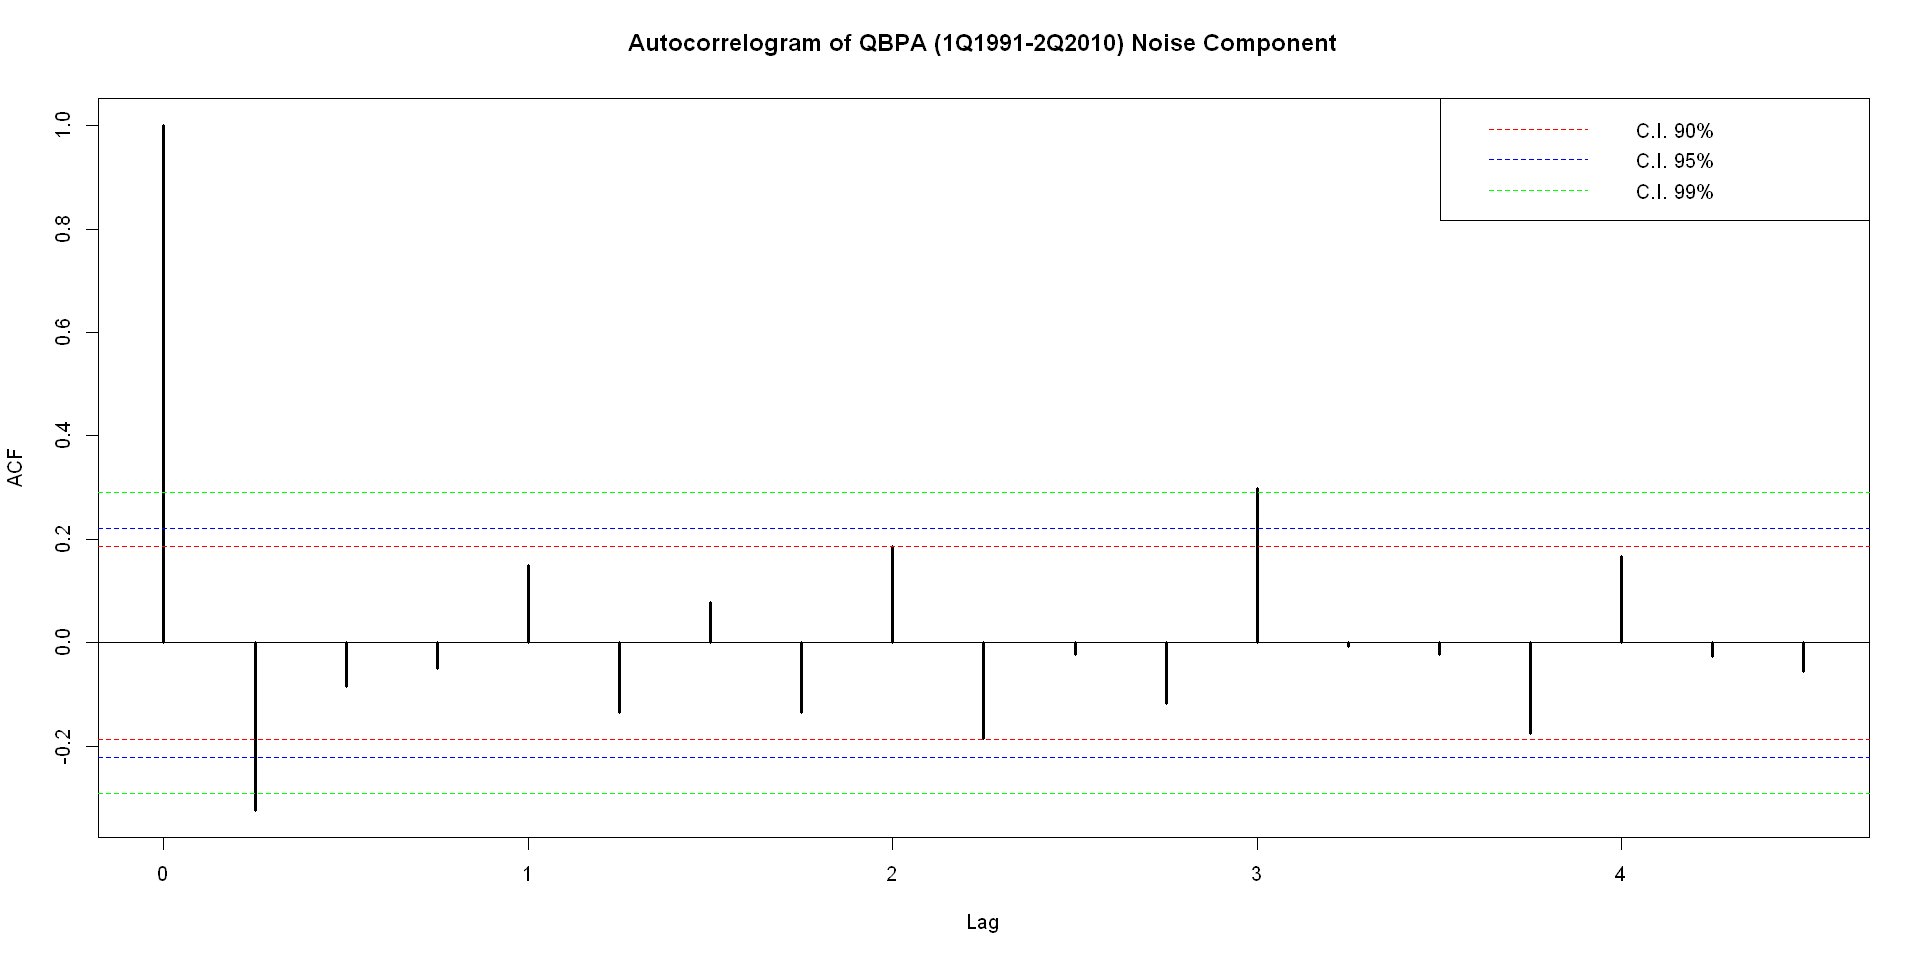

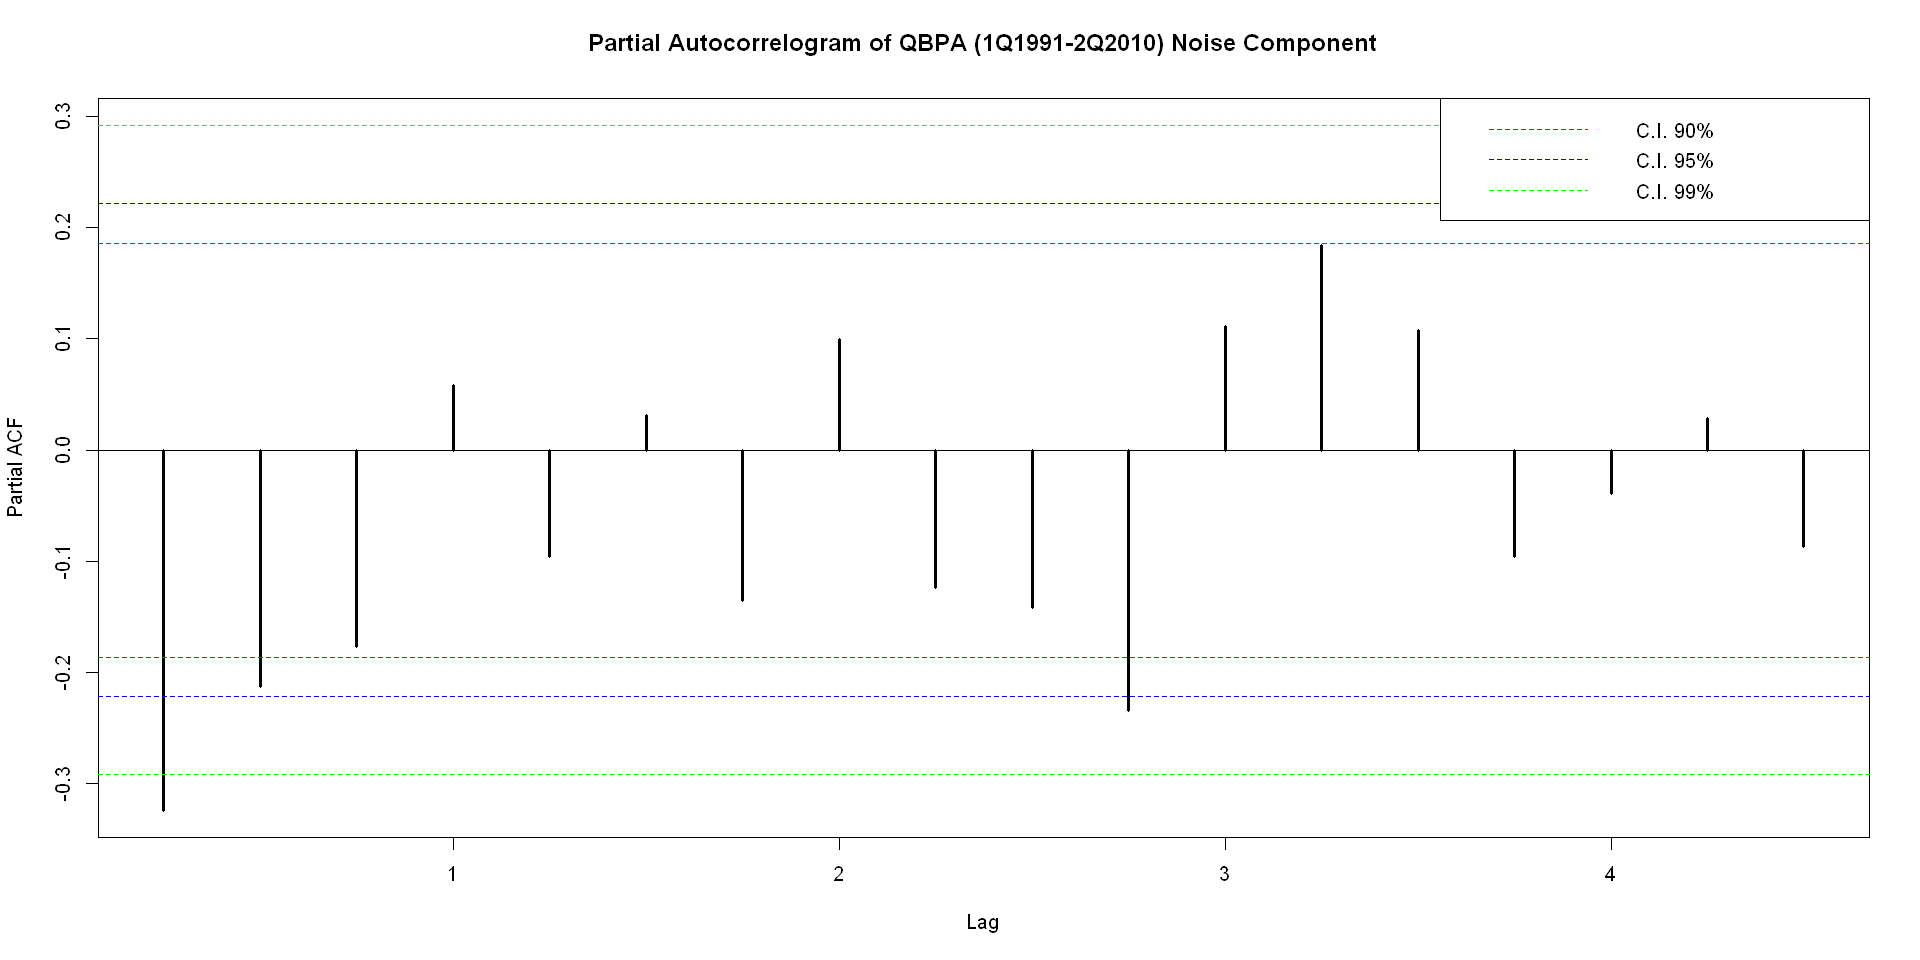

In [51]:
acf(ausbeer.cut.noise, lwd=3,
    main="Autocorrelogram of QBPA (1Q1991-2Q2010) Noise Component",
    ci = c(0.90,0.95, 0.99), ci.col=c("red", "blue", "green"),
    cex.axis=1, cex.main= 1.5, cex.sub = 1, cex.lab = 1)
legend("topright", 
       legend = c("C.I. 90%", "C.I. 95%", "C.I. 99%"), 
       col = c("red", "blue", "green"), lty=c(2,2,2))

pacf(ausbeer.cut.noise, lwd=3,
    main="Partial Autocorrelogram of QBPA (1Q1991-2Q2010) Noise Component",
    ci = c(0.90,0.95, 0.99), ci.col=c("red", "blue", "green"),
    cex.axis=1, cex.main= 1.5, cex.sub = 1, cex.lab = 1)
legend("topright", 
       legend = c("C.I. 90%", "C.I. 95%", "C.I. 99%"), 
       col = c("red", "blue", "green"), lty=c(2,2,2))

Osservando gli spike degli autocorrelogrammi, è possibile ipotizzare un processo *ARMA (2,3)*, ovvero un processo composto da una componente autoregressiva di ordine 2 e da una componente di media mobile di ordine 3. 

Provo dunque a costruire il modello e analizzo i residui per capire se è un buon candidato.

In [52]:
noise.model <-sarima(ausbeer.cut.noise, p=2, d=0, q=3, no.constant = TRUE, details=FALSE)

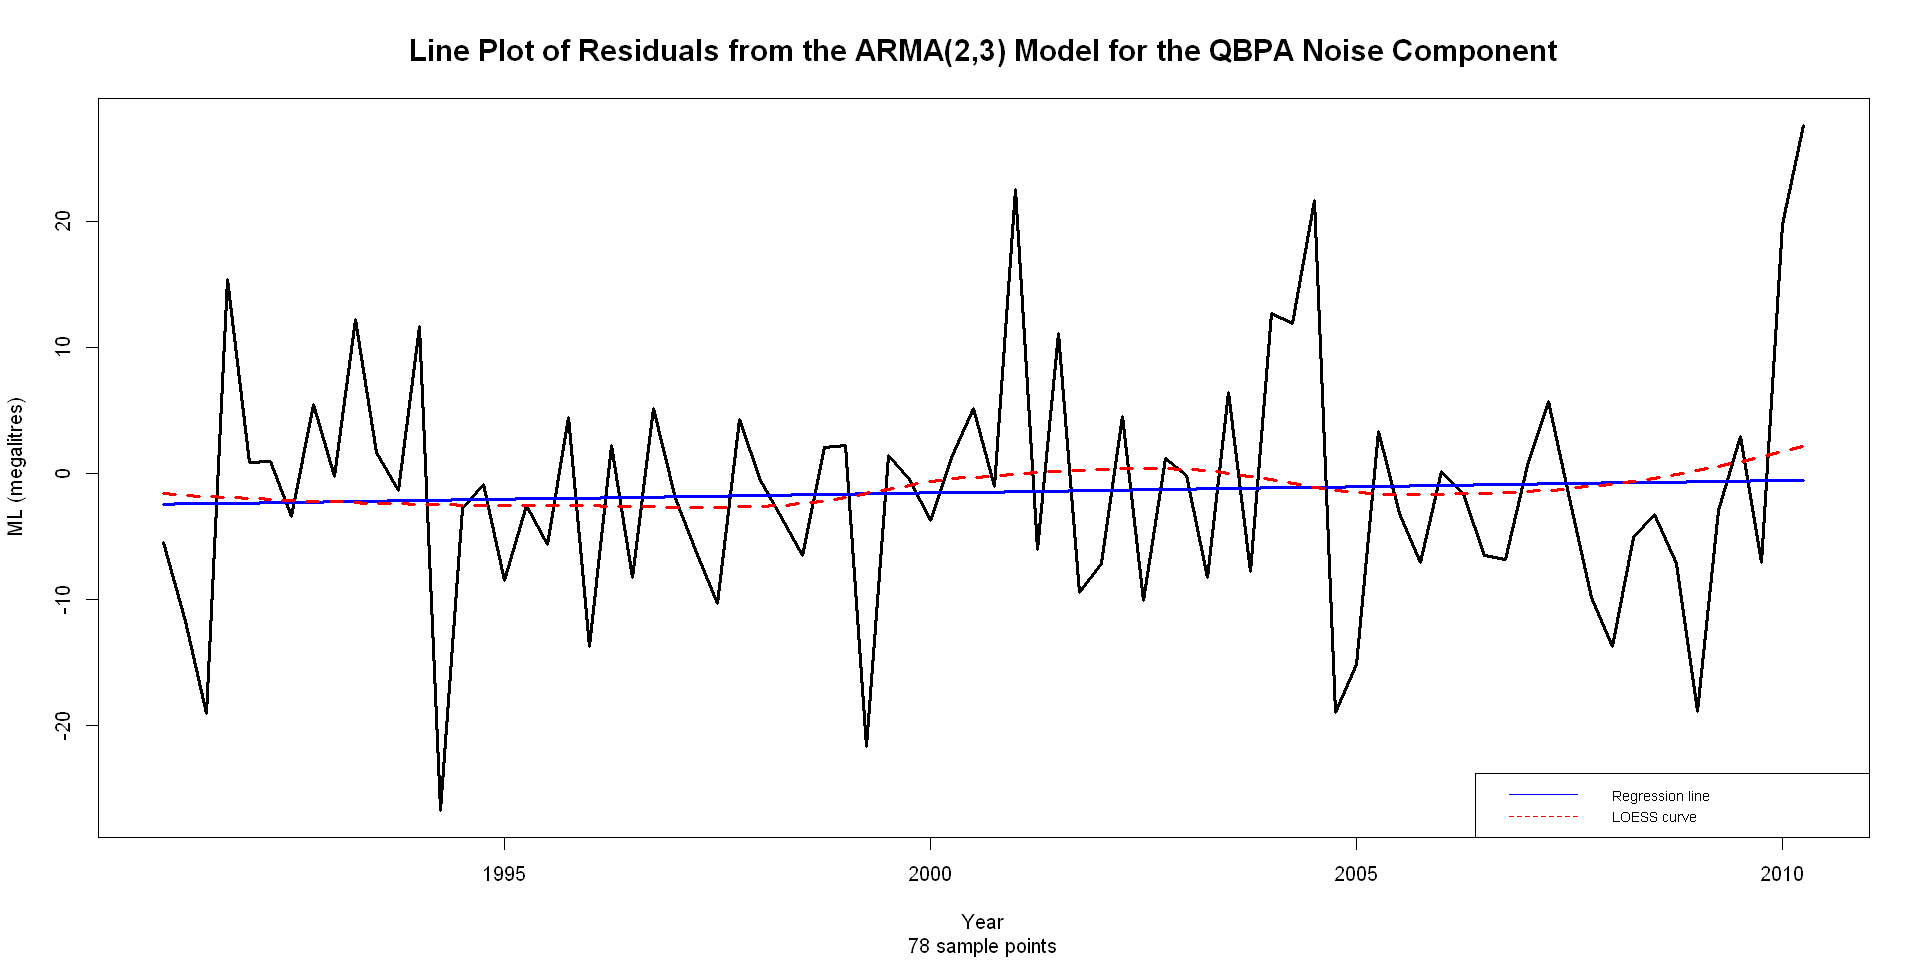

In [53]:
plot(noise.model$fit$residuals, type="l", lwd=3, 
     main = "Line Plot of Residuals from the ARMA(2,3) Model for the QBPA Noise Component",
     sub = paste(length(ausbeer.cut.noise), "sample points", sep=" "),
     xlab = "Year", ylab = "ML (megalitres)", 
     cex.axis=1, cex.main= 1.5, cex.sub = 1, cex.lab = 1)
loess.fit <- ts(loess(coredata(noise.model$fit$residuals) ~ index(noise.model$fit$residuals), span = 0.8)$fitted, start = c(1991,1), frequency = 4)
lm.fit <- ts(lm(coredata(noise.model$fit$residuals) ~ index(noise.model$fit$residuals))$fitted.values, start = c(1991,1), frequency = 4)
lines(lm.fit, col = "blue", lwd=3)
lines(loess.fit, col = "red", lwd=3, lty=2)
legend("bottomright", legend = c("Regression line", "LOESS curve"), cex = 0.7, col = c("blue","red"), lty=c(1,2))

In [54]:
summary(noise.model$fit)


Call:
stats::arima(x = xdata, order = c(p, d, q), seasonal = list(order = c(P, D, 
    Q), period = S), xreg = xmean, include.mean = FALSE, transform.pars = trans, 
    fixed = fixed, optim.control = list(trace = trc, REPORT = 1, reltol = tol))

Coefficients:
          ar1      ar2     ma1      ma2      ma3
      -1.3072  -0.3416  0.7756  -0.6987  -0.5975
s.e.   0.2795   0.2709  0.2357   0.1320   0.1547

sigma^2 estimated as 97.42:  log likelihood = -290.08,  aic = 592.16

Training set error measures:
              ME RMSE MAE MPE MAPE
Training set NaN  NaN NaN NaN  NaN


#### 5.2.1 Scorrelazione

Come primo passo verifico graficamente se è stato risolto il problema dell'autocorrelazione facendo gli autocorrelogrammi e i relativi test statistici sui residui del modello *ARMA(2,3)* del rumore.

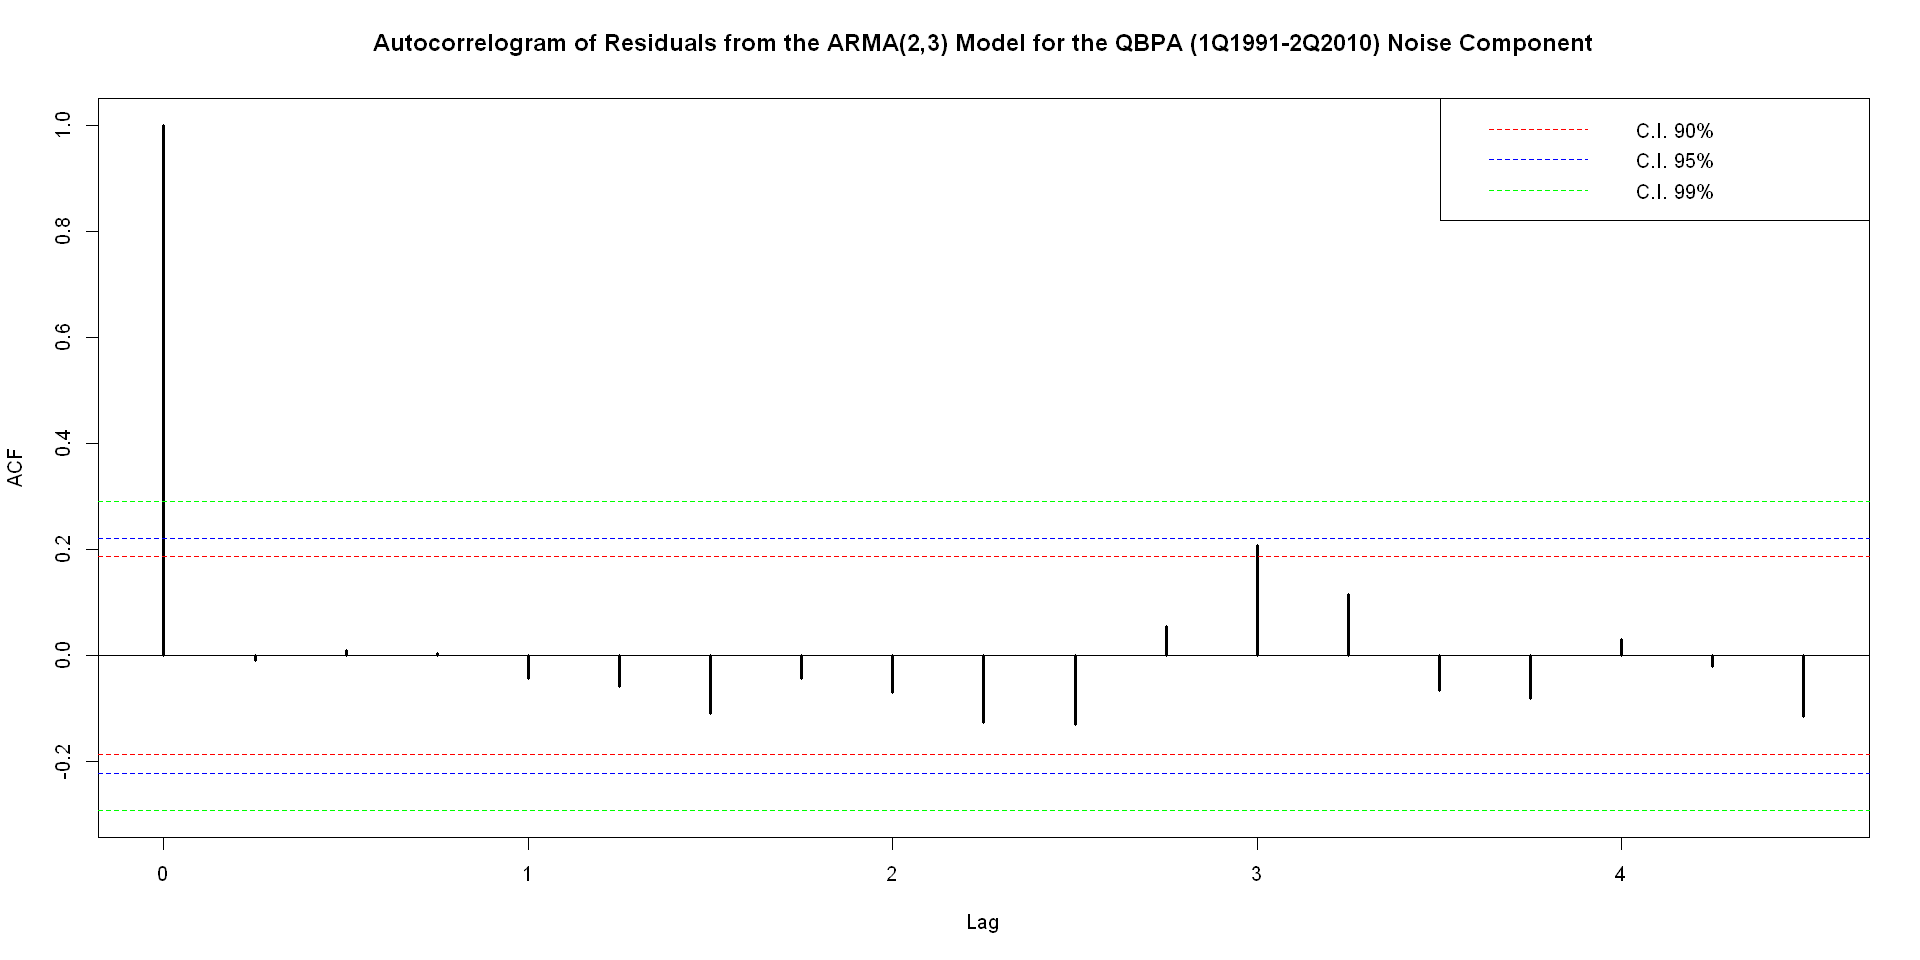

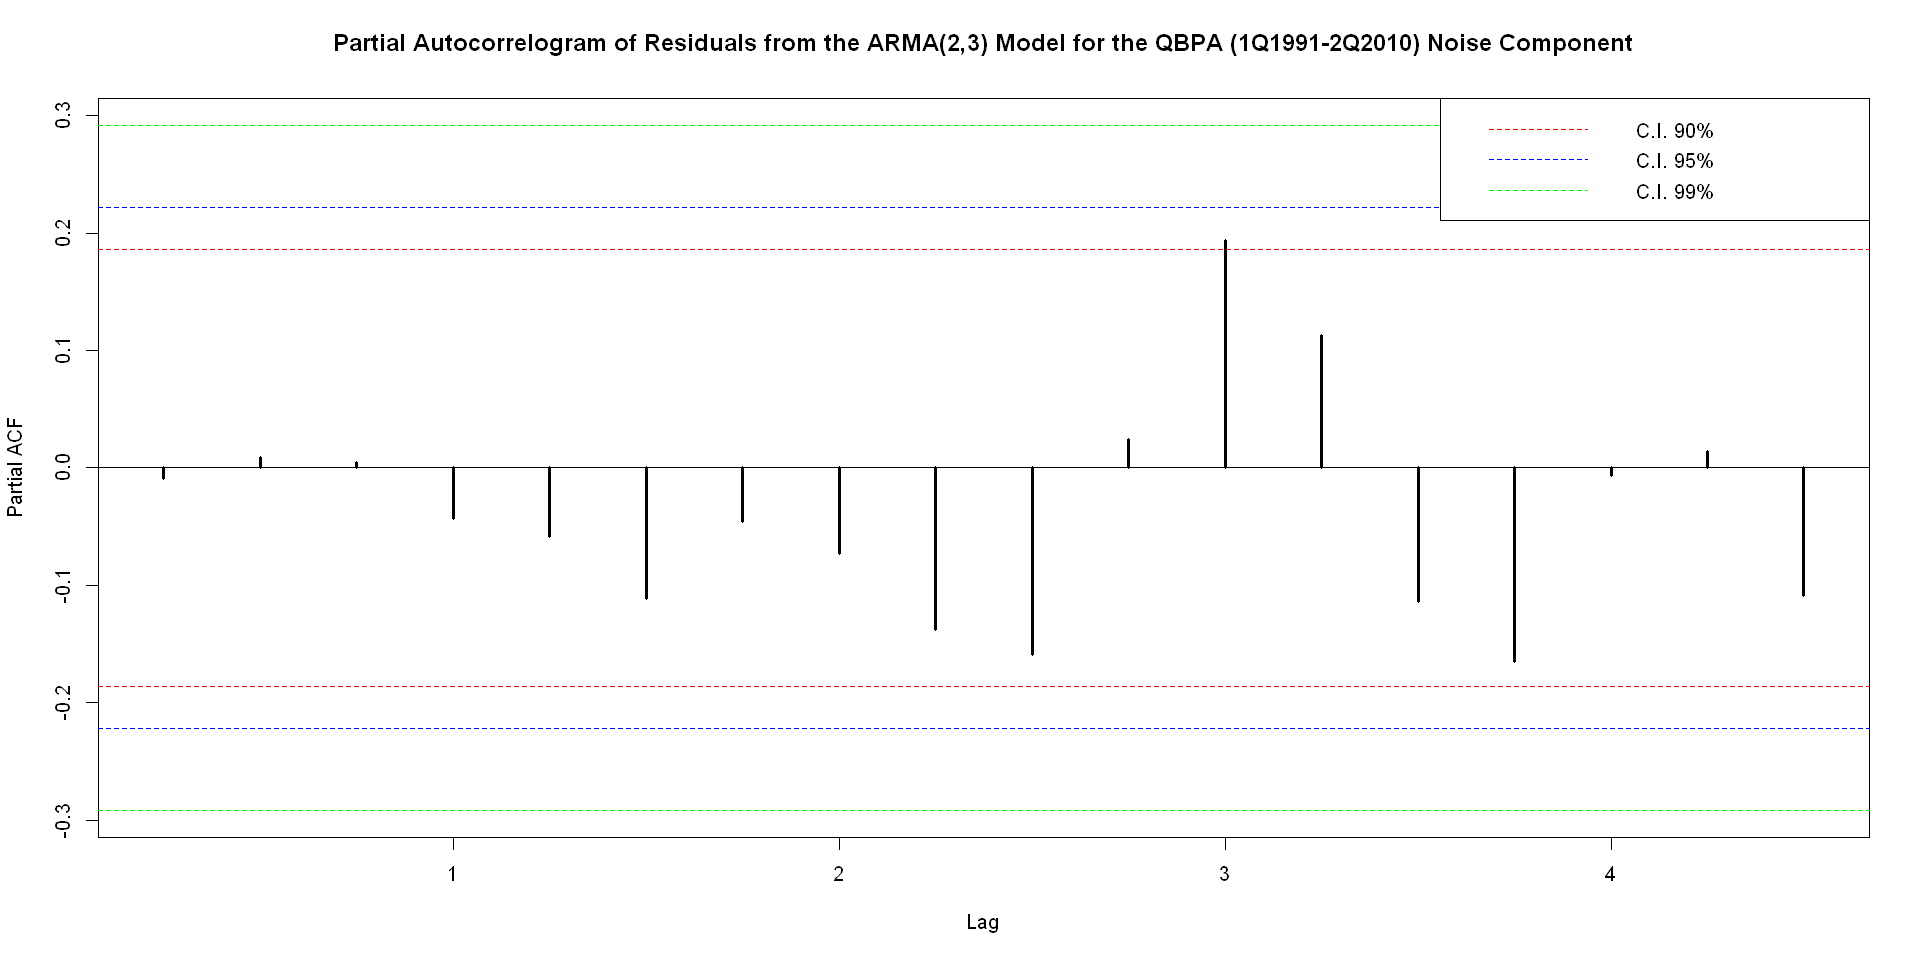

In [55]:
# scorrelazione
acf(noise.model$fit$residuals, lwd=3,
    main = "Autocorrelogram of Residuals from the ARMA(2,3) Model for the QBPA (1Q1991-2Q2010) Noise Component",
    ci = c(0.90,0.95, 0.99), ci.col=c("red", "blue", "green"),
    cex.axis=1, cex.main= 1.5, cex.sub = 1, cex.lab = 1)
legend("topright", 
       legend = c("C.I. 90%", "C.I. 95%", "C.I. 99%"), 
       col = c("red", "blue", "green"), lty=c(2,2,2))
pacf(noise.model$fit$residuals, lwd=3,
     main = "Partial Autocorrelogram of Residuals from the ARMA(2,3) Model for the QBPA (1Q1991-2Q2010) Noise Component",
     ci = c(0.90,0.95, 0.99), ci.col=c("red", "blue", "green"),
     cex.axis=1, cex.main= 1.5, cex.sub = 1, cex.lab = 1)
legend("topright", 
       legend = c("C.I. 90%", "C.I. 95%", "C.I. 99%"), 
       col = c("red", "blue", "green"), lty=c(2,2,2))

In [56]:
noise.model.residuals.lm <- lm(coredata(noise.model$fit$residuals) ~ index(noise.model$fit$residuals))
Box.test(noise.model$fit$residuals, lag = 4, type = "Ljung-Box") ## H0: autocorrelations (for chosen lags) in the data is zero
dwtest(noise.model.residuals.lm, alternative="two.sided", exact = TRUE) # Durbin-Watson ## H0: residuals from an OLS regression are not autocorrelated
bgtest(noise.model.residuals.lm, order = 4, type = "Chisq") # Breusch-Godfrey ## H0: there is no serial correlation of any order up to p
bgtest(noise.model.residuals.lm, order = 4, type = "F")  # Breusch-Godfrey ## H0: there is no serial correlation of any order up to p


	Box-Ljung test

data:  noise.model$fit$residuals
X-squared = 0.17313, df = 4, p-value = 0.9965



	Durbin-Watson test

data:  noise.model.residuals.lm
DW = 1.9081, p-value = 0.5993
alternative hypothesis: true autocorrelation is not 0



	Breusch-Godfrey test for serial correlation of order up to 4

data:  noise.model.residuals.lm
LM test = 0.17345, df = 4, p-value = 0.9964



	Breusch-Godfrey test for serial correlation of order up to 4

data:  noise.model.residuals.lm
LM test = 0.040116, df1 = 4, df2 = 72, p-value = 0.9969


Sia gli autocorrelogrammi che i test statistici confermano l'eliminazione dell'autocorrelazione, fornendo un'evidenza congiunta sulla scorrelazione dei residui del modello *ARMA(2,3)* del rumore

*Nota metodologica: è stato considerato un livello di significatività α=.05*

#### 5.2.2 Stazionarietà e omoschedasticità

Successivamente verifico la stazionarietà e l'omoschedasticità attraverso gli opportuni test statistici per avvalorare le ipotesi di stazionarietà e omoschedasticità che emergono in modo abbastanza evidente dall'analisi grafica.

In [57]:
#stazionarietà
adf.lags <- floor(12*(length(noise.model$fit$residuals)/100)^1/4) # as suggested by Schwert 
adf.test(noise.model$fit$residuals, k=adf.lags) # Dickey-Fuller ## H0: the data are non-stationary
kpss.test(noise.model$fit$residuals) # Kwiatkowski, Phillips, Schmidt and Shin ## H0: time series is trend-stationary


	Augmented Dickey-Fuller Test

data:  noise.model$fit$residuals
Dickey-Fuller = -4.4031, Lag order = 2, p-value = 0.01
alternative hypothesis: stationary



	KPSS Test for Level Stationarity

data:  noise.model$fit$residuals
KPSS Level = 0.060922, Truncation lag parameter = 3, p-value = 0.1


*Nota metodologica: Applico i test (per l'omoschedasticità) studentizzati in quanto la normalità nei residui è rispettata solo considerando un un livello di significatività α = .05 (questo aspetto si vedrà meglio nella sezione successiva)*

In [58]:
#omoschedasticità
print("------ Koenker test ------")
bptest(noise.model.residuals.lm, studentize = TRUE) # Koenker ## H0: Equal/constant variances
print("------ White test ------")
bptest(noise.model.residuals.lm,  ~ index(ausbeer.lm) + I(index(ausbeer.lm)^2) , studentize = TRUE) # White ## H0: Equal/constant variances
print("------ White-Wooldridge test ------")
bptest(noise.model.residuals.lm,  ~ ausbeer.lm$fitted + I(ausbeer.lm$fitted^2) , studentize = TRUE) # White-Wooldridge ## H0: Equal/constant variances

[1] "------ Koenker test ------"



	studentized Breusch-Pagan test

data:  noise.model.residuals.lm
BP = 1.1569, df = 1, p-value = 0.2821


[1] "------ White test ------"



	studentized Breusch-Pagan test

data:  noise.model.residuals.lm
BP = 1.0341, df = 2, p-value = 0.5963


[1] "------ White-Wooldridge test ------"



	studentized Breusch-Pagan test

data:  noise.model.residuals.lm
BP = 4.0477, df = 2, p-value = 0.1321


I test statistici confermano l'ipotesi di stazionarietà e omoschedasticità

*Nota metodologica: è stato considerato un livello di significatività α=.05*

#### 5.2.3 Gaussianità

Infine disegno la distribuzione dei residui del modello *ARMA(2,3)* del rumore e verifico la gaussianità con il supporto del QQ-Plot e dei test statistici.

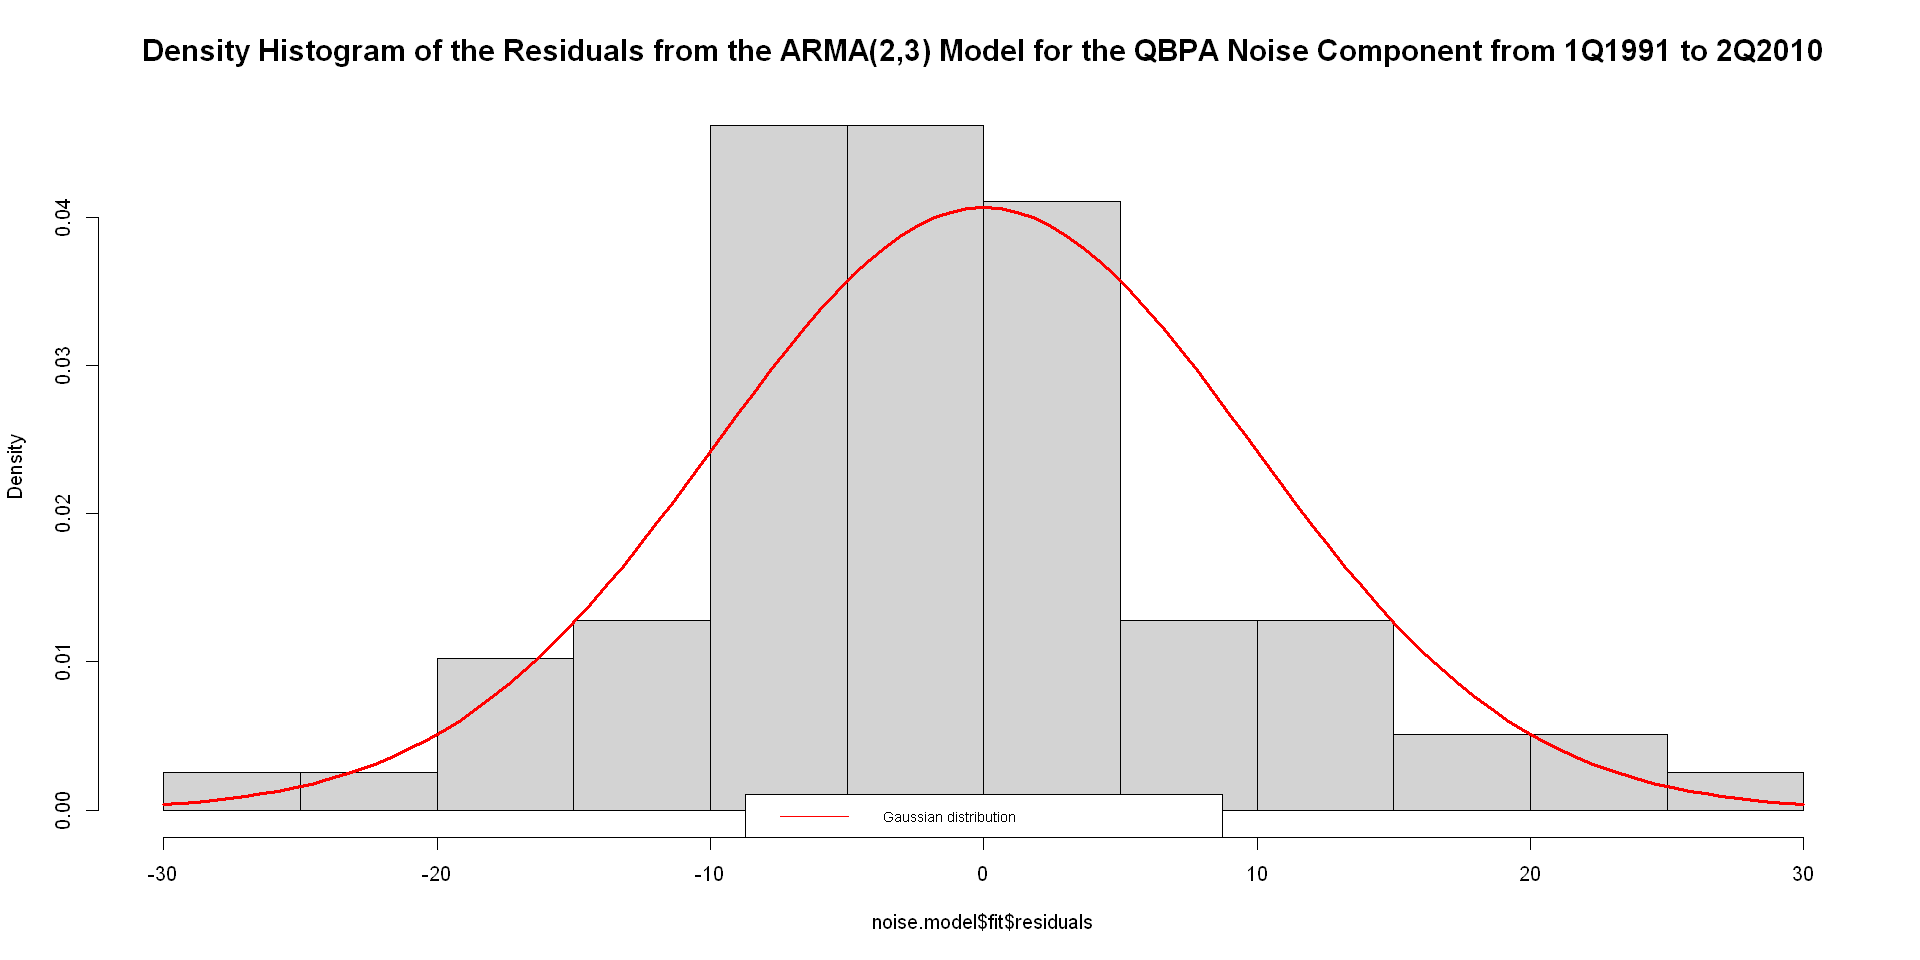

In [59]:
hist(noise.model$fit$residuals, freq = FALSE,
    main = "Density Histogram of the Residuals from the ARMA(2,3) Model for the QBPA Noise Component from 1Q1991 to 2Q2010",
    cex.axis=1, cex.main= 1.5, cex.sub = 1, cex.lab = 1)
curve(dnorm(x,mean=0,sd=sd(noise.model$fit$residuals)), add=TRUE,col="red", lwd=3)
legend("bottom", legend = "Gaussian distribution", cex = 0.7, col = "red", lty=c(1,2))

In [60]:
noise.model.skew <- skewness(noise.model$fit$residuals) #theo 0
noise.model.kurt <- kurtosis(noise.model$fit$residuals) # theo 3
print(cbind(noise.model.skew,noise.model.kurt))

     noise.model.skew noise.model.kurt
[1,]        0.3705068        0.8301276


La distribuzione appare platicurtica e sostanzialmente simmetrica

[1] 78 14

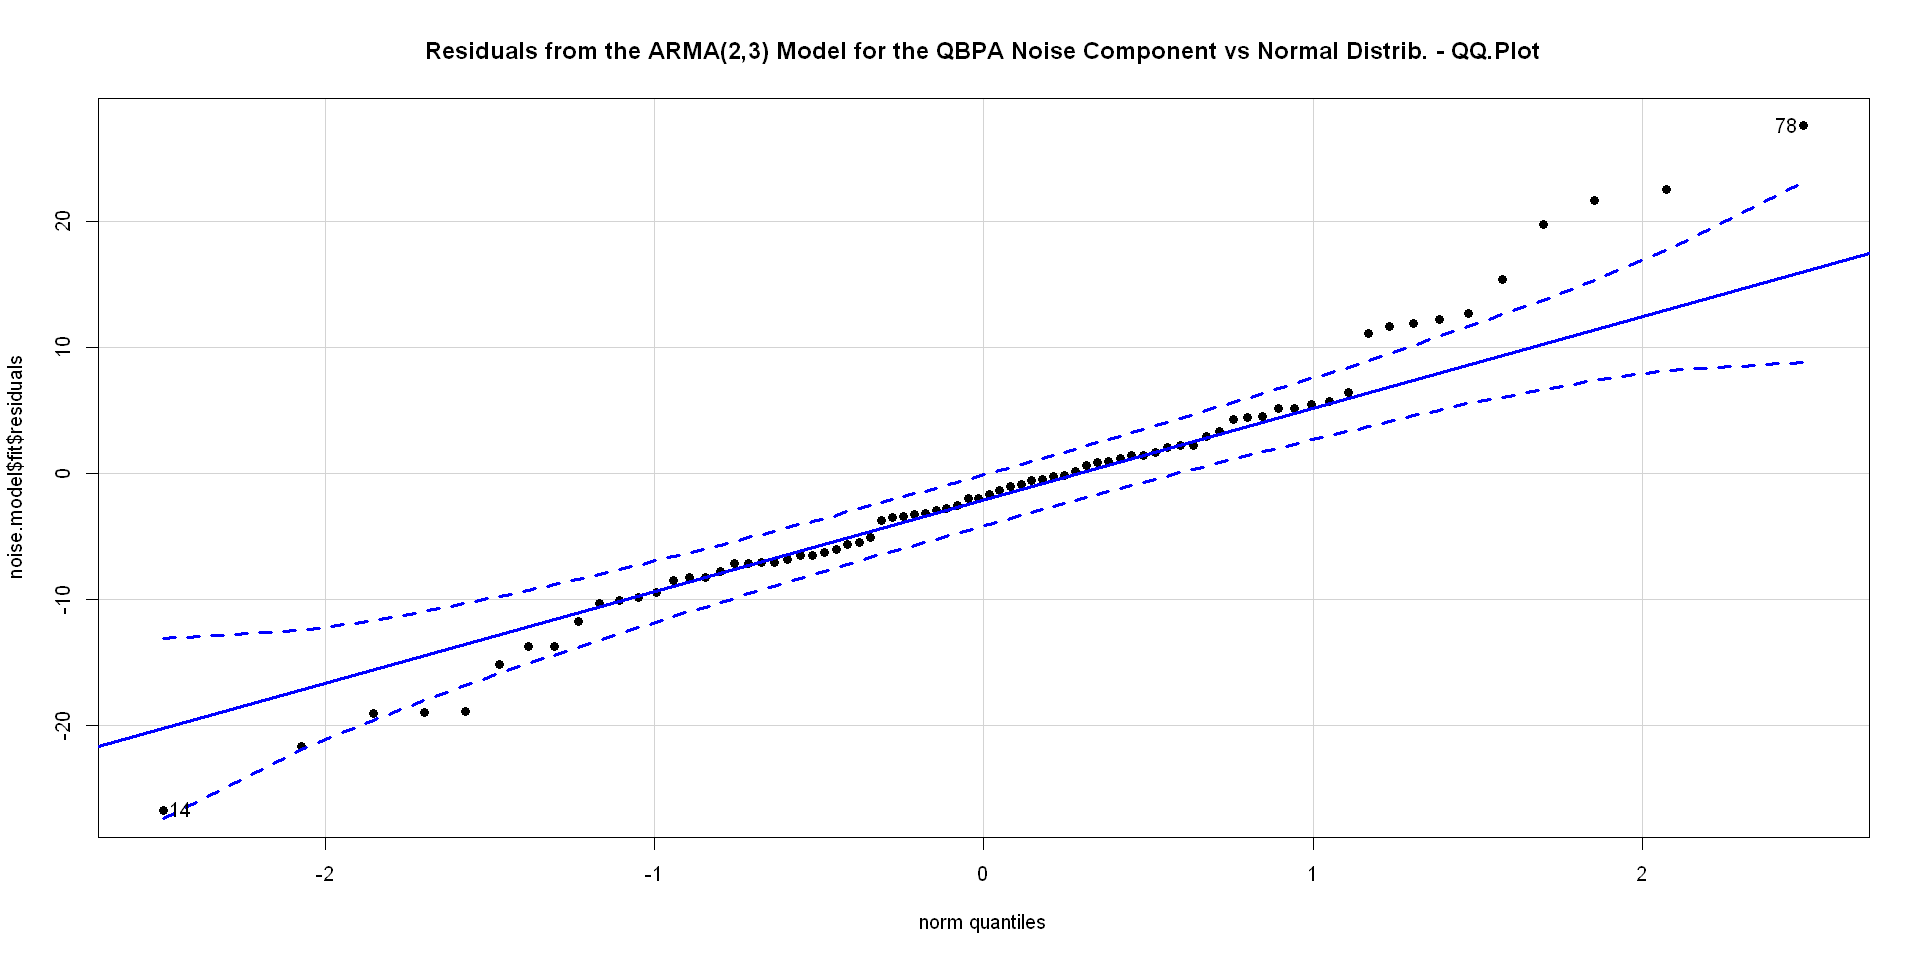

In [61]:
qqPlot(noise.model$fit$residuals, lwd=3, pch=16,
       main = "Residuals from the ARMA(2,3) Model for the QBPA Noise Component vs Normal Distrib. - QQ.Plot")

In [62]:
# Test di normalità
jarque.bera.test(noise.model$fit$residuals) # Jarque-Bera ## H0: The data is normally distributed.
shapiro.test(noise.model$fit$residuals) # Shapiro-Wilks ## H0: The data is normally distributed.
dagoTest(noise.model$fit$residuals) # D’Agostino Pearson ## H0: The data is normally distributed.


	Jarque Bera Test

data:  noise.model$fit$residuals
X-squared = 4.6675, df = 2, p-value = 0.09693



	Shapiro-Wilk normality test

data:  noise.model$fit$residuals
W = 0.97071, p-value = 0.06909



Title:
 D'Agostino Normality Test

Test Results:
  STATISTIC:
    Chi2 | Omnibus: 5.0126
    Z3  | Skewness: 1.433
    Z4  | Kurtosis: 1.7202
  P VALUE:
    Omnibus  Test: 0.08157 
    Skewness Test: 0.1519 
    Kurtosis Test: 0.0854 

Description:
 Tue Dec 22 23:14:27 2020 by user: Marco


*Nota metodologica: è stato considerato un livello di significatività α=.05*

Il QQ-Plot e l'esito dei test statistici confermano la normalità, tuttavia se avessimo applicato un livello di significatività *α = .1* non saremmo arrivati alla stessa conclusione.

#### 5.2.4 Conclusioni

Il modello *ARMA(2,3)* è risultato essere un modello valido per modellare il rumore della serie storica in quanto i suoi residui rispettano le caratteristiche del *white noise gaussiano*, tuttavia decido di cercare un modello che garantisca maggiore solidità statistica in quanto i residui del precedente modello non sono del tutto convincenti sotto la lente della normalità.

[Torna all'indice](#Indice)

### 5.3 Modello alternativo del rumore

Come primo tentativo è stato provato il comando *auto.arima* che ha restituito un modello non buono dal punto di vista delle proprietà dei residui.

Ho deciso dunque di esplorare uno spazio finito di modelli *ARMA*; per farlo ho costruito una funzione che restituisce informazioni utili per una scelta consapevole del modello da applicare al rumore. Nello specifico la funzione che ho creato fornisce informazioni sul numero di picchi fuori dall'intervallo di confidenza degli autocorrelogrammi, il p-value del test di Ljung-Box, il p-value del test di D'Agostino-Pearson, l'AIC e la complessità del modello.

In [63]:
explore.arma <- function(x, search_space = 3, lb.lags = 1){
    p.vec <- c()
    q.vec <- c()
    acf.vec <- c()
    pacf.vec <-c()
    lb.vec <- c()
    dp.omni.vec <- c()
    dp.skew.vec <- c()
    dp.kurt.vec <- c()
    aic.vec <- c()
    complexity.vec <- c()

    for (i in 0:search_space){
        for (k in 0:search_space){
            model <- sarima(x, p=i, d=0, q=k, no.constant = TRUE, details=FALSE)
            lb <- Box.test(model$fit$residuals, lag = lb.lags, type = "Ljung-Box")
            dp <- dagoTest(model$fit$residuals)
            aic <- model$fit$aic
            
            model.acf <- acf(model$fit$residuals, plot = FALSE)
            acf.peaks <- sum(model.acf$acf > qnorm((1 + 0.95)/2)/sqrt(model.acf$n.used))
            model.pacf <- pacf(model$fit$residuals, plot = FALSE)
            pacf.peaks <- sum(model.pacf$acf > qnorm((1 + 0.95)/2)/sqrt(model.pacf$n.used))

            p.vec <- append(p.vec, i, after = length(p.vec))
            q.vec <- append(q.vec, k, after = length(p.vec))
            acf.vec <- append(acf.vec, acf.peaks, after = length(acf.vec))
            pacf.vec <- append(pacf.vec, pacf.peaks, after = length(pacf.vec))
            lb.vec <- append(lb.vec, round(lb$p.value,2), after = length(lb.vec))
            dp.omni.vec <- append(dp.omni.vec, round(dp@test$p.value[1],2), after = length(dp.omni.vec))
            dp.skew.vec <- append(dp.skew.vec, round(dp@test$p.value[2],2), after = length(dp.skew.vec))
            dp.kurt.vec <- append(dp.kurt.vec, round(dp@test$p.value[3],2), after = length(dp.kurt.vec))
            aic.vec <- append(aic.vec, round(aic,2), after = length(aic.vec))
            complexity.vec <- append(complexity.vec, i+k, after = length(complexity.vec))
            }
    }

    arma.models <- data.frame(p.vec, q.vec, acf.vec, pacf.vec, lb.vec, dp.omni.vec, dp.skew.vec, dp.kurt.vec, aic.vec, complexity.vec)
    names(arma.models) <- c("AR", "MA", "ACF peaks","PACF peaks", "Ljung-Box (p-value)", "D’Agostino Overall (p-value)", "D’Agostino Skewness (p-value)", "D’Agostino Kurtosis (p-value)", "AIC", "Model complexity")
    return(arma.models)
}

In [64]:
explore.arma(ausbeer.cut.noise, search_space = 5, lb.lags = 4)

AR,MA,ACF peaks,PACF peaks,Ljung-Box (p-value),D’Agostino Overall (p-value),D’Agostino Skewness (p-value),D’Agostino Kurtosis (p-value),AIC,Model complexity
<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
0,0,2,0,0.02,0.64,0.66,0.40,609.33,0
0,1,2,1,0.69,0.04,0.07,0.08,593.32,1
0,2,2,1,0.98,0.11,0.06,0.33,591.69,2
0,3,2,1,0.98,0.15,0.08,0.39,593.52,3
0,4,2,1,1.00,0.12,0.07,0.35,595.38,4
0,5,2,1,0.98,0.25,0.14,0.44,595.92,5
1,0,2,0,0.13,0.77,0.75,0.52,602.46,1
1,1,2,1,0.96,0.18,0.10,0.40,591.60,2
1,2,2,1,0.97,0.16,0.09,0.39,593.55,3


Scelgo il modello *ARMA(3,5)* e analizzo i residui per capire se è un buon candidato.

In [65]:
noise.model.alt <-sarima(ausbeer.cut.noise, p=3, d=0, q=5, no.constant = TRUE, details=FALSE)

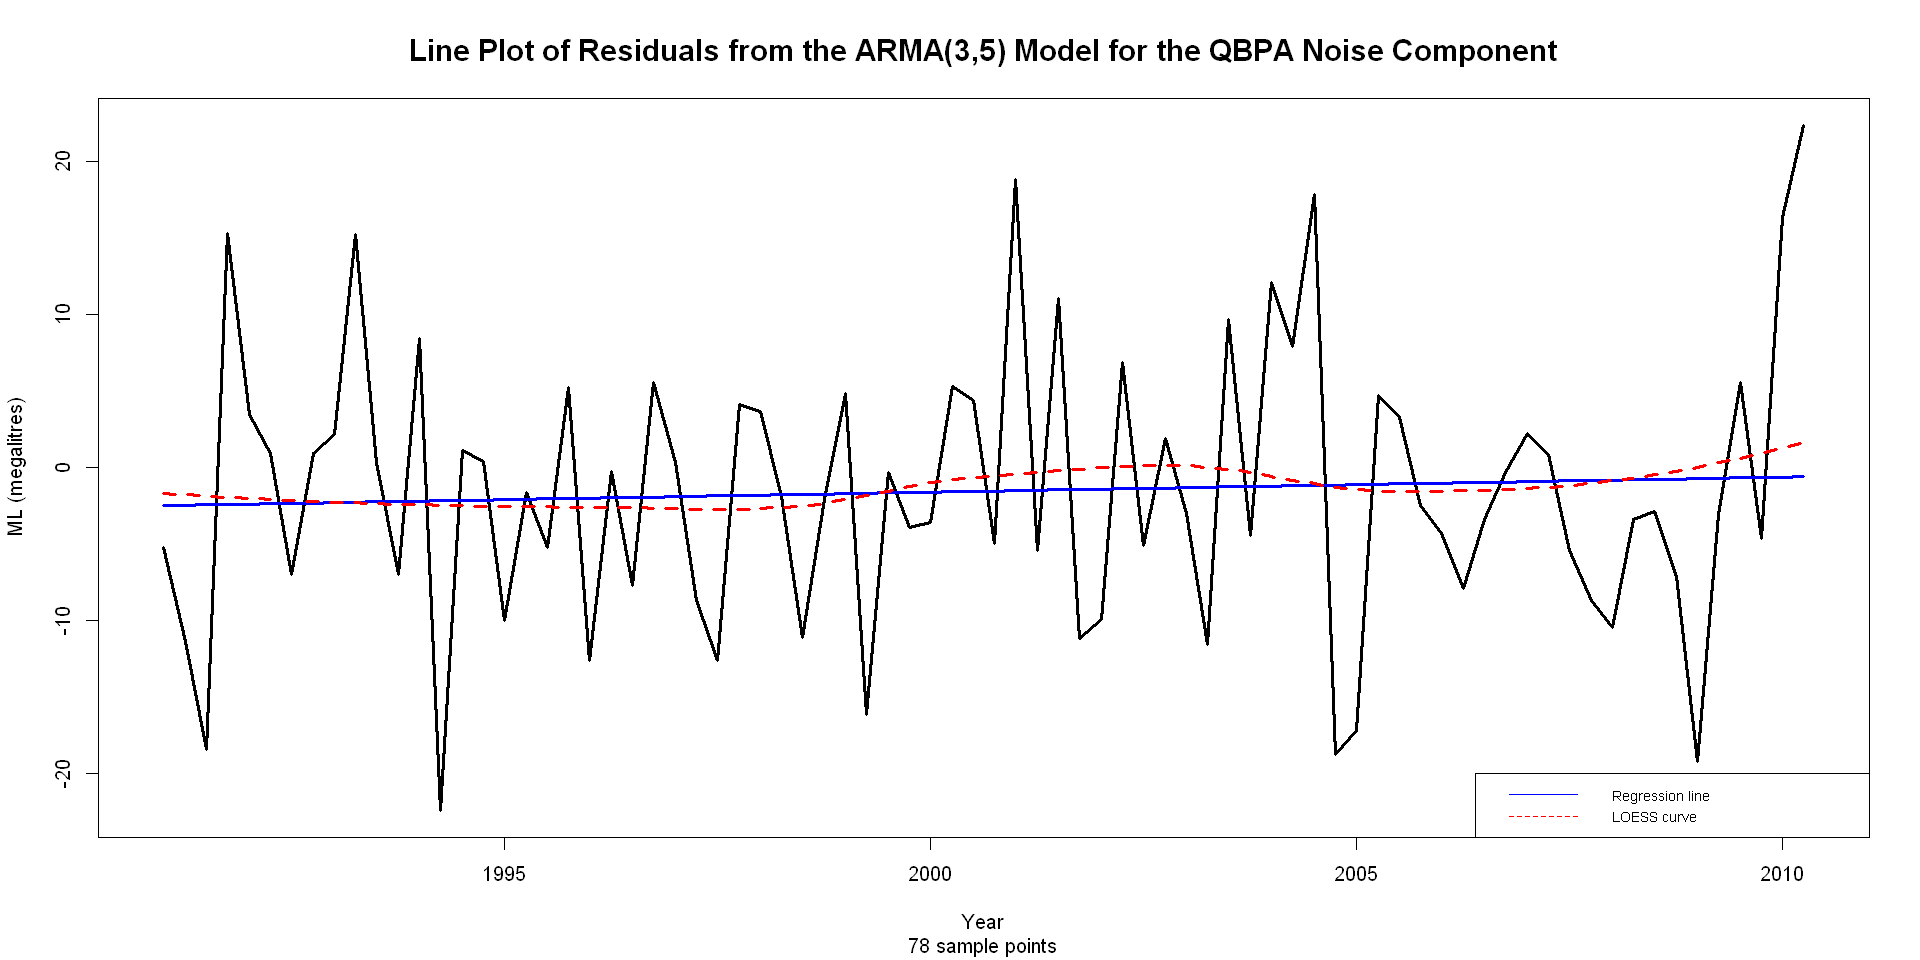

In [66]:
plot(noise.model.alt$fit$residuals, type="l", lwd=3, 
     main = "Line Plot of Residuals from the ARMA(3,5) Model for the QBPA Noise Component",
     sub = paste(length(ausbeer.cut.noise), "sample points", sep=" "),
     xlab = "Year", ylab = "ML (megalitres)", 
     cex.axis=1, cex.main= 1.5, cex.sub = 1, cex.lab = 1)
loess.fit <- ts(loess(coredata(noise.model.alt$fit$residuals) ~ index(noise.model.alt$fit$residuals), span = 0.8)$fitted, start = c(1991,1), frequency = 4)
lm.fit <- ts(lm(coredata(noise.model.alt$fit$residuals) ~ index(noise.model.alt$fit$residuals))$fitted.values, start = c(1991,1), frequency = 4)
lines(lm.fit, col = "blue", lwd=3)
lines(loess.fit, col = "red", lwd=3, lty=2)
legend("bottomright", legend = c("Regression line", "LOESS curve"), cex = 0.7, col = c("blue","red"), lty=c(1,2))

In [67]:
summary(noise.model.alt$fit)


Call:
stats::arima(x = xdata, order = c(p, d, q), seasonal = list(order = c(P, D, 
    Q), period = S), xreg = xmean, include.mean = FALSE, transform.pars = trans, 
    fixed = fixed, optim.control = list(trace = trc, REPORT = 1, reltol = tol))

Coefficients:
          ar1      ar2      ar3     ma1      ma2     ma3      ma4      ma5
      -0.6368  -0.4434  -0.7128  0.0982  -0.0613  0.4651  -0.5114  -0.5107
s.e.   0.1202   0.1471   0.1107  0.1363   0.1171  0.0913   0.0967   0.1214

sigma^2 estimated as 85.81:  log likelihood = -287.05,  aic = 592.11

Training set error measures:
              ME RMSE MAE MPE MAPE
Training set NaN  NaN NaN NaN  NaN


#### 5.3.1 Scorrelazione

Come fatto per il modello precedente come primo passo verifico graficamente se è stato risolto il problema dell'autocorrelazione facendo gli autocorrelogrammi dei residui del modello *ARMA(3,5)* del rumore e i relativi test statistici.

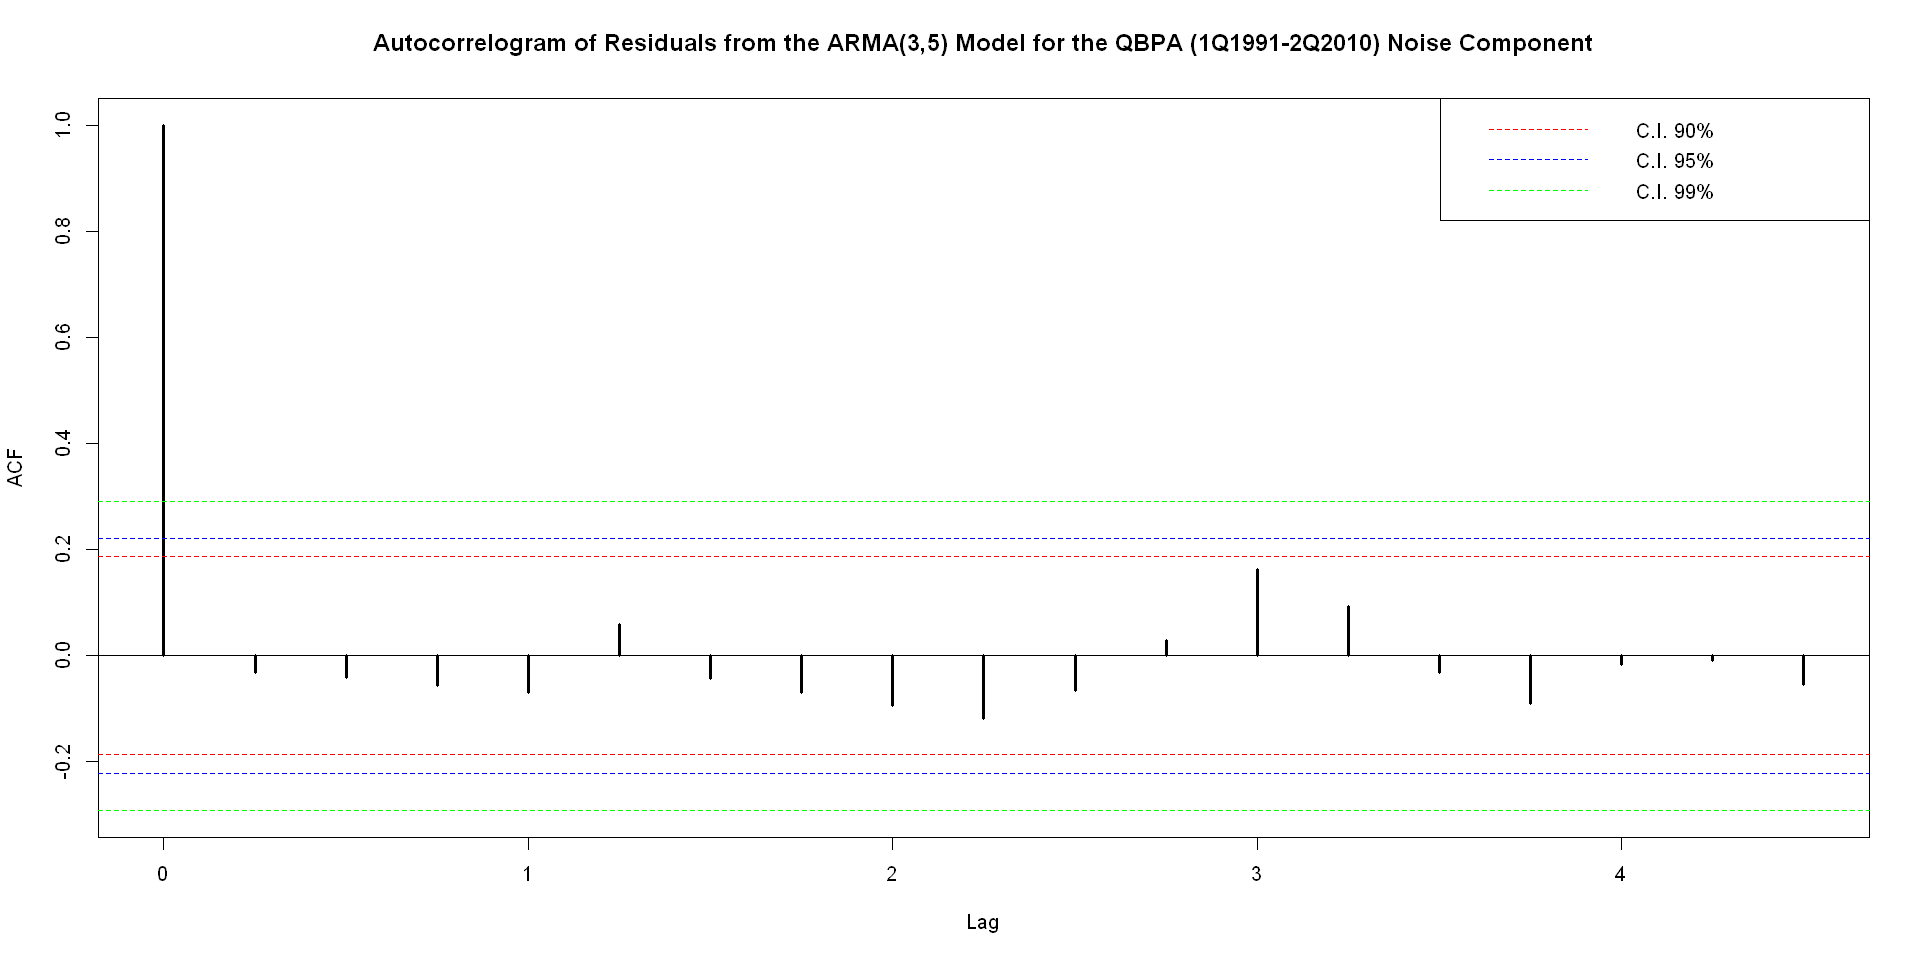

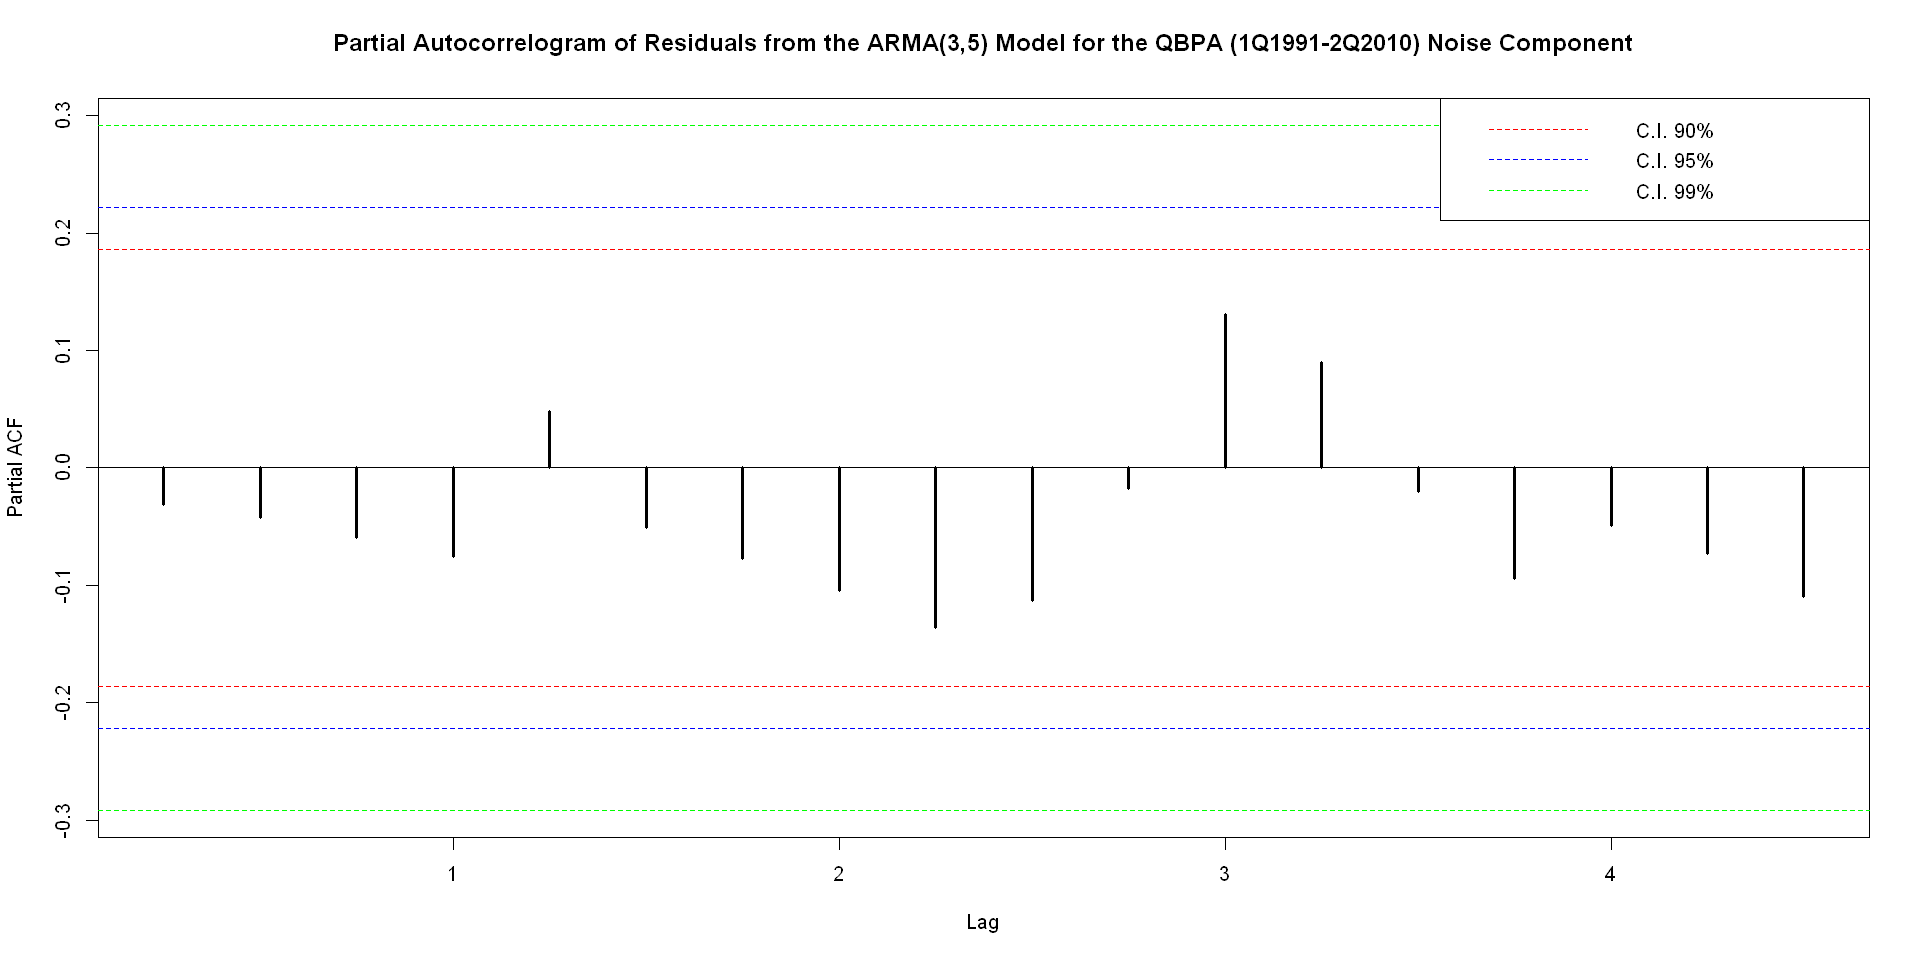

In [68]:
# scorrelazione
acf(noise.model.alt$fit$residuals, lwd=3,
    main = "Autocorrelogram of Residuals from the ARMA(3,5) Model for the QBPA (1Q1991-2Q2010) Noise Component",
    ci = c(0.90,0.95, 0.99), ci.col=c("red", "blue", "green"),
    cex.axis=1, cex.main= 1.5, cex.sub = 1, cex.lab = 1)
legend("topright", 
       legend = c("C.I. 90%", "C.I. 95%", "C.I. 99%"), 
       col = c("red", "blue", "green"), lty=c(2,2,2))
pacf(noise.model.alt$fit$residuals, lwd=3,
     main = "Partial Autocorrelogram of Residuals from the ARMA(3,5) Model for the QBPA (1Q1991-2Q2010) Noise Component",
     ci = c(0.90,0.95, 0.99), ci.col=c("red", "blue", "green"),
     cex.axis=1, cex.main= 1.5, cex.sub = 1, cex.lab = 1)
legend("topright", 
       legend = c("C.I. 90%", "C.I. 95%", "C.I. 99%"), 
       col = c("red", "blue", "green"), lty=c(2,2,2))

In [69]:
noise.model.alt.residuals.lm <- lm(coredata(noise.model.alt$fit$residuals) ~ index(noise.model.alt$fit$residuals))
Box.test(noise.model.alt$fit$residuals, lag = 4, type = "Ljung-Box") ## H0: autocorrelations (for chosen lags) in the data is zero
dwtest(noise.model.alt.residuals.lm, alternative="two.sided", exact = TRUE) # Durbin-Watson ## H0: residuals from an OLS regression are not autocorrelated
bgtest(noise.model.alt.residuals.lm, order = 4, type = "Chisq") # Breusch-Godfrey ## H0: there is no serial correlation of any order up to p
bgtest(noise.model.alt.residuals.lm, order = 4, type = "F")  # Breusch-Godfrey ## H0: there is no serial correlation of any order up to p


	Box-Ljung test

data:  noise.model.alt$fit$residuals
X-squared = 0.88692, df = 4, p-value = 0.9264



	Durbin-Watson test

data:  noise.model.alt.residuals.lm
DW = 1.9798, p-value = 0.8359
alternative hypothesis: true autocorrelation is not 0



	Breusch-Godfrey test for serial correlation of order up to 4

data:  noise.model.alt.residuals.lm
LM test = 1.0655, df = 4, p-value = 0.8997



	Breusch-Godfrey test for serial correlation of order up to 4

data:  noise.model.alt.residuals.lm
LM test = 0.24929, df1 = 4, df2 = 72, p-value = 0.9092


Sia gli autocorrelogrammi che i test statistici confermano l'eliminazione dell'autocorrelazione, fornendo un'evidenza congiunta sulla scorrelazione dei residui del modello *ARMA(3,5)* del rumore

*Nota metodologica: è stato considerato un livello di significatività α=.05*

#### 5.3.2 Stazionarietà e omoschedasticità

Seccessivamente verifico la stazionarietà e l'omoschedasticità attraverso gli opportuni test statistici per avvalorare le ipotesi di stazionarietà e omoschedasticità che emergono in modo abbastanza evidente dall'analisi grafica.

In [70]:
#stazionarietà
adf.lags <- floor(12*(length(noise.model.alt$fit$residuals)/100)^1/4) # as suggested by Schwert 
adf.test(noise.model.alt$fit$residuals, k=adf.lags) # Dickey-Fuller ## H0: the data are non-stationary
kpss.test(noise.model.alt$fit$residuals) # Kwiatkowski, Phillips, Schmidt and Shin ## H0: time series is trend-stationary


	Augmented Dickey-Fuller Test

data:  noise.model.alt$fit$residuals
Dickey-Fuller = -5.2258, Lag order = 2, p-value = 0.01
alternative hypothesis: stationary



	KPSS Test for Level Stationarity

data:  noise.model.alt$fit$residuals
KPSS Level = 0.065856, Truncation lag parameter = 3, p-value = 0.1


*Nota metodologica: Applico i test non studentizzati perchè la normalità nel rumore è ragionevolmente rispettata (vedi sezione successiva)*

In [71]:
#omoschedasticità
bptest(noise.model.alt.residuals.lm, studentize = FALSE) # Breusch-Pagan ## H0: Equal/constant variances
print("------ White test ------")
bptest(noise.model.alt.residuals.lm,  ~ index(noise.model.alt.residuals.lm) + I(index(noise.model.alt.residuals.lm)^2) , studentize = FALSE) # White ## H0: Equal/constant variances
print("------ White-Wooldridge test ------")
bptest(noise.model.alt.residuals.lm,  ~ noise.model.alt.residuals.lm$fitted + I(noise.model.alt.residuals.lm$fitted^2) , studentize = FALSE) # White-Wooldridge ## H0: Equal/constant variances


	Breusch-Pagan test

data:  noise.model.alt.residuals.lm
BP = 0.4945, df = 1, p-value = 0.4819


[1] "------ White test ------"



	Breusch-Pagan test

data:  noise.model.alt.residuals.lm
BP = 0.15658, df = 2, p-value = 0.9247


[1] "------ White-Wooldridge test ------"



	Breusch-Pagan test

data:  noise.model.alt.residuals.lm
BP = 2.9282, df = 2, p-value = 0.2313


I test statistici confermano l'ipotesi di stazionarietà e omoschedasticità

*Nota metodologica: è stato considerato un livello di significatività α=.05*

#### 5.3.3 Gaussianità

Infine disegno la distribuzione dei residui del modello *ARMA(3,5)* del rumore e ne verifico la gaussianità con il supporto del QQ-Plot e dei test statistici.

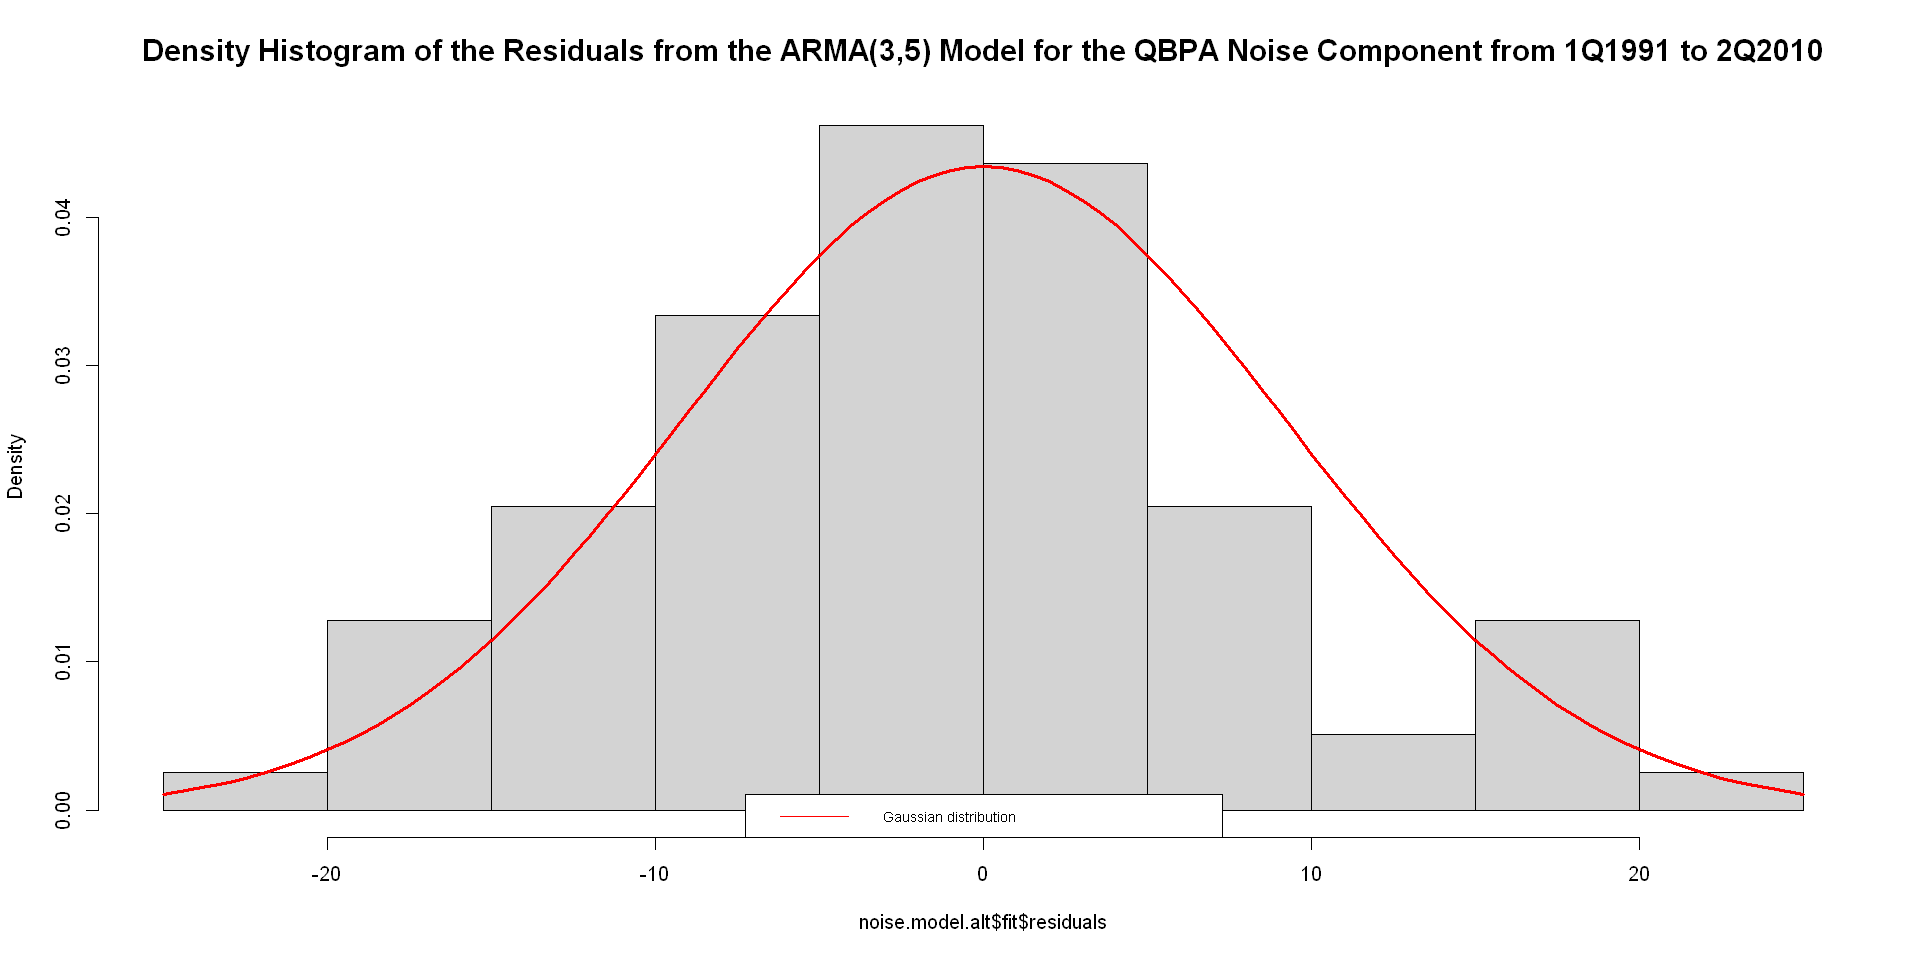

In [72]:
hist(noise.model.alt$fit$residuals, freq = FALSE,
     main = "Density Histogram of the Residuals from the ARMA(3,5) Model for the QBPA Noise Component from 1Q1991 to 2Q2010",
     cex.axis=1, cex.main= 1.5, cex.sub = 1, cex.lab = 1)
curve(dnorm(x,mean=0,sd=sd(noise.model.alt$fit$residuals)), add=TRUE,col="red", lwd=3)
legend("bottom", legend = "Gaussian distribution", cex = 0.7, col = "red", lty=c(1,2))

In [73]:
noise.model.alt.skew <- skewness(noise.model.alt$fit$residuals) #theo 0
noise.model.alt.kurt <- kurtosis(noise.model.alt$fit$residuals) # theo 3
print(cbind(noise.model.alt.skew,noise.model.alt.kurt))

     noise.model.alt.skew noise.model.alt.kurt
[1,]            0.2321235          0.003130081


La distribuzione appare platicurtica e sostanzialmente simmetrica

[1] 78 14

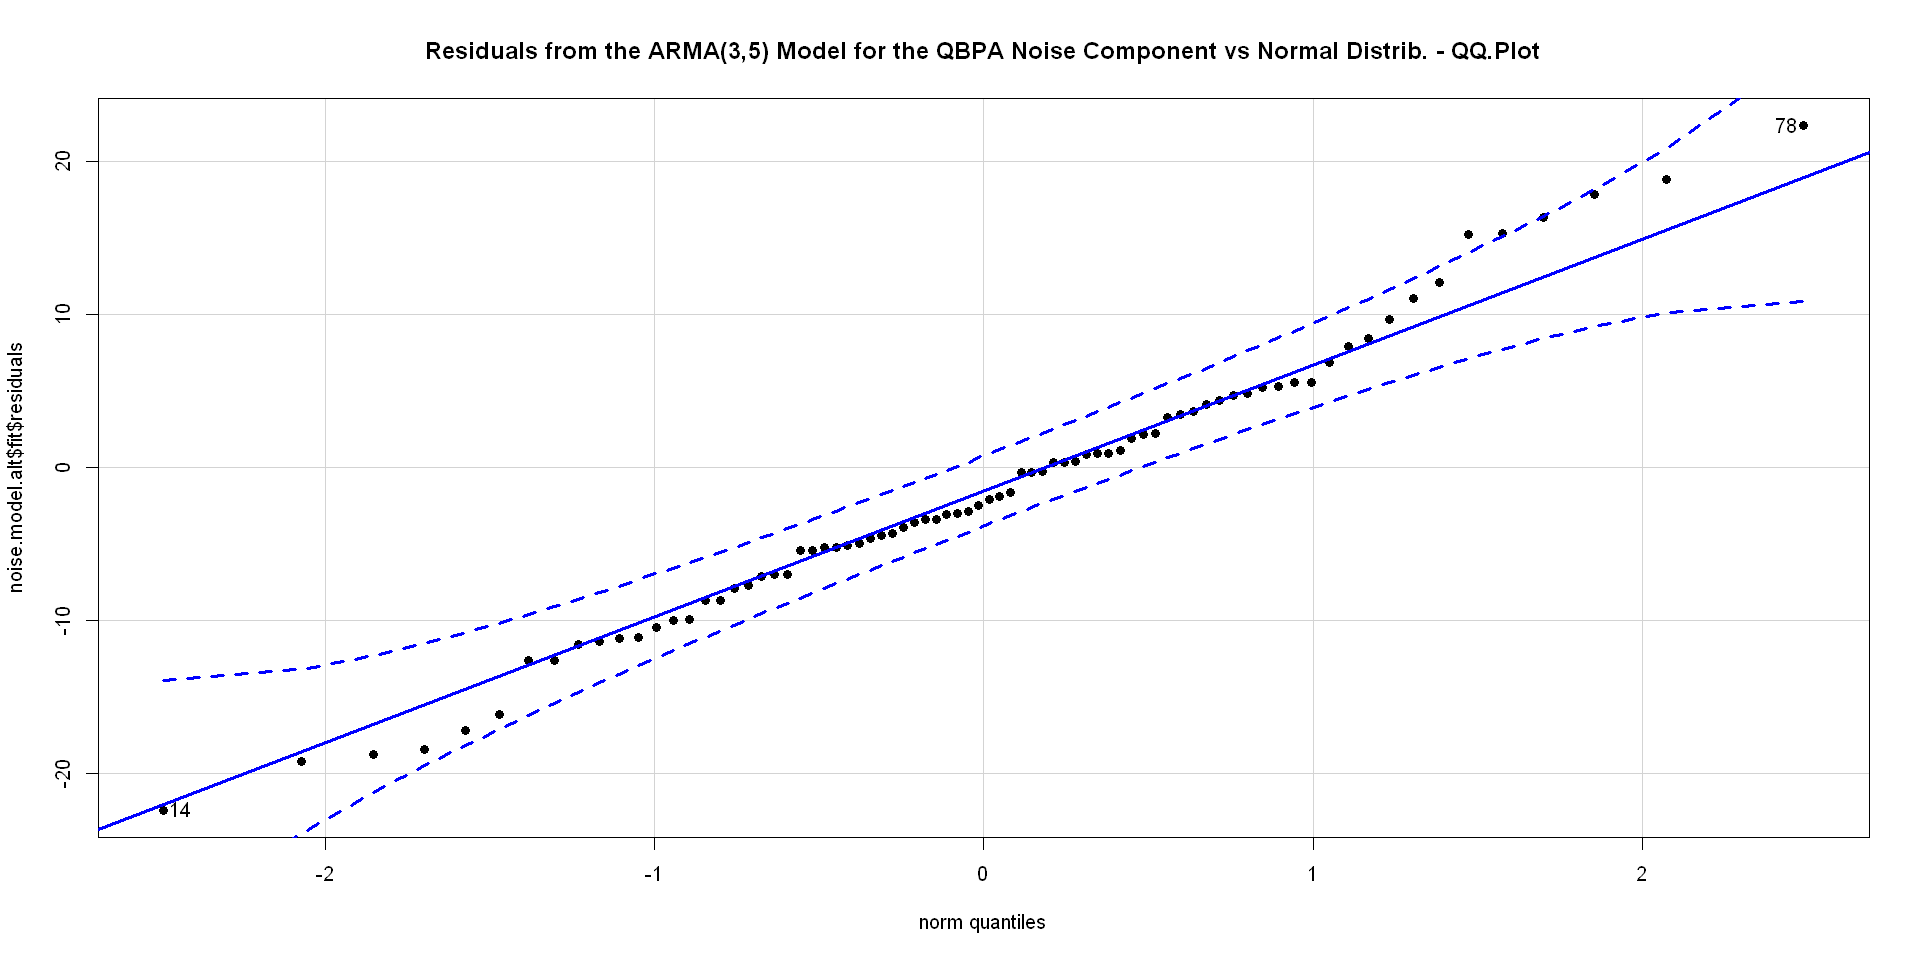

In [74]:
qqPlot(noise.model.alt$fit$residuals, lwd=3, pch=16,
       main = "Residuals from the ARMA(3,5) Model for the QBPA Noise Component vs Normal Distrib. - QQ.Plot")

In [75]:
# Test di normalità
jarque.bera.test(noise.model.alt$fit$residuals) # Jarque-Bera ## H0: The data is normally distributed.
shapiro.test(noise.model.alt$fit$residuals) # Shapiro-Wilks ## H0: The data is normally distributed.
dagoTest(noise.model.alt$fit$residuals) # D’Agostino Pearson ## H0: The data is normally distributed.


	Jarque Bera Test

data:  noise.model.alt$fit$residuals
X-squared = 0.74977, df = 2, p-value = 0.6874



	Shapiro-Wilk normality test

data:  noise.model.alt$fit$residuals
W = 0.98699, p-value = 0.6155



Title:
 D'Agostino Normality Test

Test Results:
  STATISTIC:
    Chi2 | Omnibus: 1.0928
    Z3  | Skewness: 0.9117
    Z4  | Kurtosis: 0.5115
  P VALUE:
    Omnibus  Test: 0.579 
    Skewness Test: 0.3619 
    Kurtosis Test: 0.609 

Description:
 Tue Dec 22 23:14:29 2020 by user: Marco


Il QQ-Plot e l'esito dei test statistici confermano l'ipotesi di normalità.

*Nota metodologica: è stato considerato un livello di significatività α=.05*

#### 5.3.4 Conclusioni

Alla luce di tutte le evidenze raccolte il modello *ARMA(3, 5)* è risultato essere un buon modello per descrivere il rumore della serie storica in analisi in quanto i suoi residui rispettano ampiamente tutte le caratteristiche del *white noise gaussiano*. Lo svantaggio principale di questo modello risulta essere però l'elevata complessità.

[Torna all'indice](#Indice)

## 6 Modello *SARIMA* e Forecast

Oltre al modello additivo esiste un altro modo di affrontare la serie storica in analisi ovvero attraverso un modello *SARIMA*. I modelli *SARIMA* sono dei modelli misti di componenti a media mobile e di componenti autoregressive che tengono conto dell'eventuale non stazionarietà e stagionalità di una serie. Questa famiglia di modelli cerca di descrivere il fenomeno attraverso l'adattamento, sia della parte stagionale, sia della parte non stagionale, in un modello moltiplicativo che può essere rappresentato in questi termini [^6] :

\begin{align}
ARIMA(p,d,q) \ x \ (P,D,Q)_{S}
\end{align}

dove:
* ***p*** è l'ordine della componente AutoRegressiva non stagionale
* ***d*** è numero di integrazioni non stagionali
* ***q*** è l'ordine della componente Moving Average non stagionale
* ***P*** è l'ordine della componente AutoRegressiva stagionale
* ***D*** è numero di integrazioni stagionali
* ***Q*** è l'ordine della componente Moving Average stagionale
* ***S*** è il numero di punti componenti la stagione

Per la costruzione del modello utilizzo la procedura proposta da Box e Jenkins che si basa su tre fasi[^7] :
* *identificazione del modello*: che consiste nella specificazione dei parametri p,d,q (ed eventualmente P, D,Q) cercando di riconoscere nelle funzioni di autocorrelazione globale e parziale picchi significativi
* *stima del modello*
* *controllo diagnostico*: in cui si valuta l'adeguatezza del modello stimato mediante opportune analisi dei residui

[^6]: Seasonal ARIMA models: STAT 510. (n.d.). Retrieved December 22, 2020, from https://online.stat.psu.edu/stat510/lesson/4/4.1

[^7]: Tarsitano, A. (2016). La metodologia Box-Jenkins. Retrieved December 22, 2020, from http://www.ecostat.unical.it/tarsitano/Didattica/SeStoCor/BaseRel_BJ.pdf

Non avendo a disposizione dati più recenti del 2010, per valutare la bontà del modello che andrò a individuare, ho deciso di escludere in fase di costruzione i valori relativi agli ultimi tre anni della serie storica; questa porzione sarà poi utilizzata per confrontare i valori previsti dal modello *SARIMA* (forecast) e quelli osservati.

In [76]:
ausbeer.cut.train <-window(ausbeer.cut, end = c(2006,4))
ausbeer.cut.test <- window(ausbeer.cut, start =c(2007,1))

### 6.1 Costruzione del modello e studio dei residui

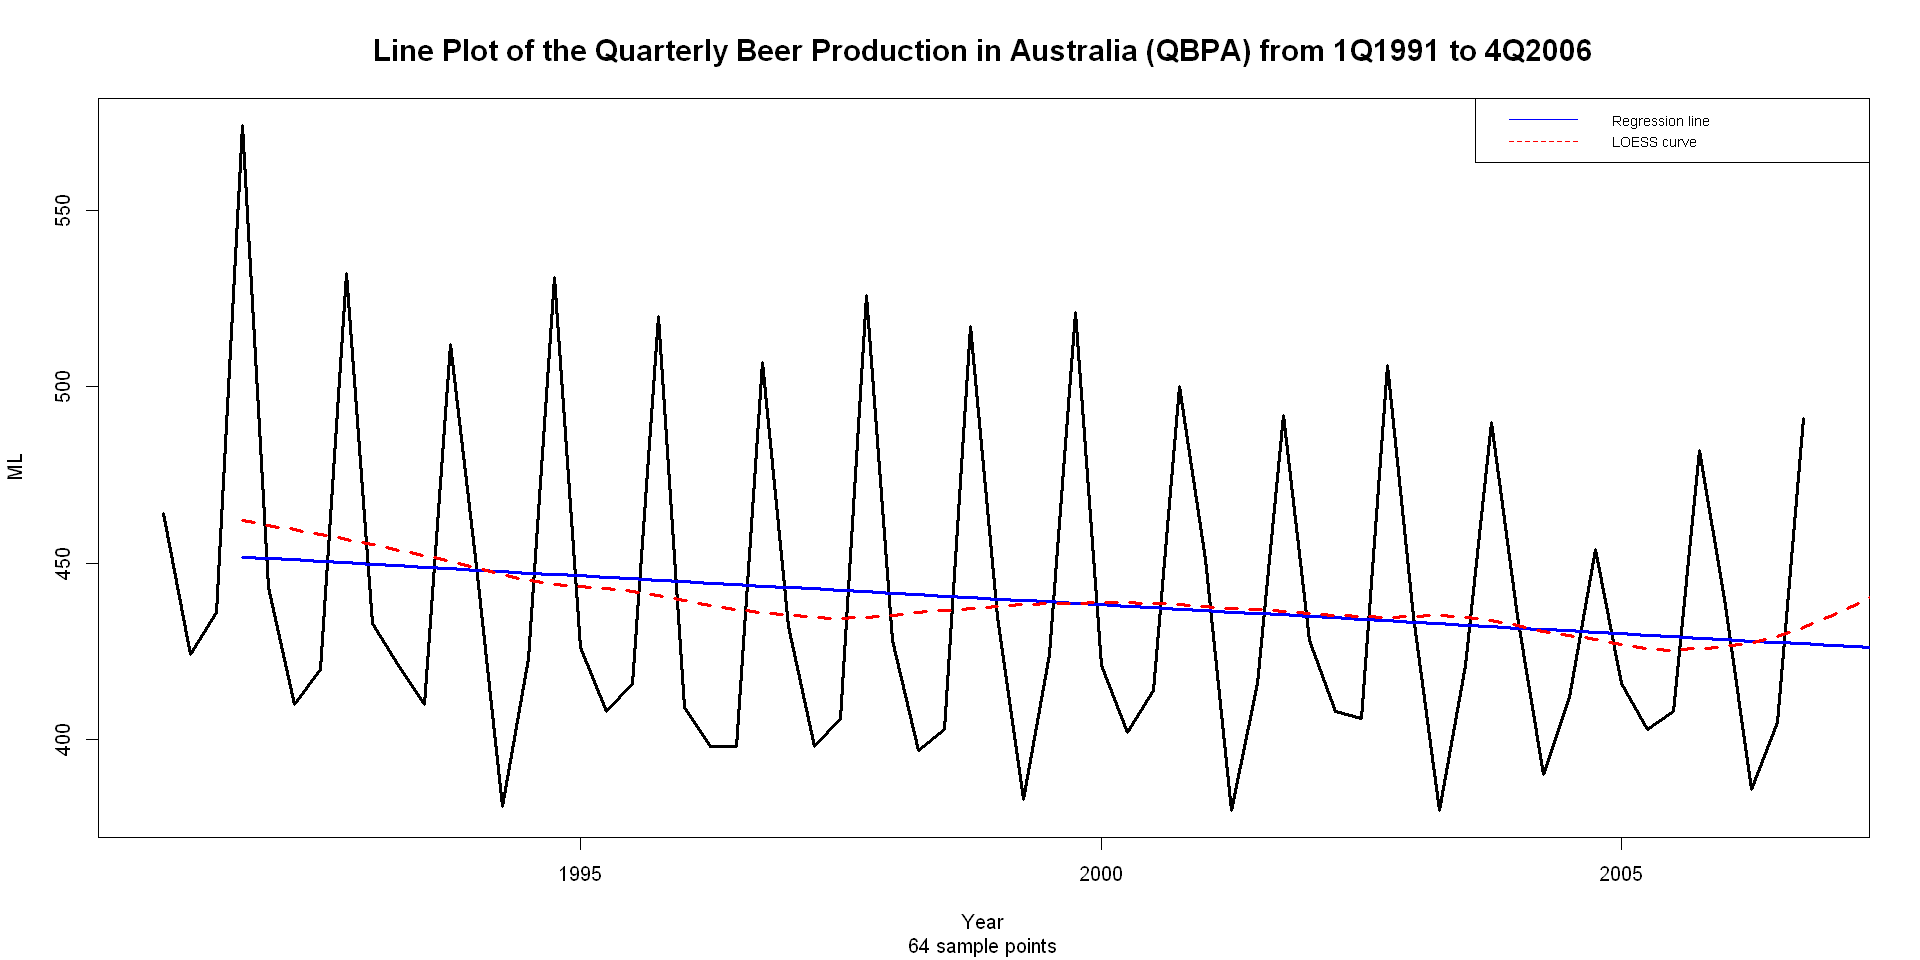

In [77]:
plot(ausbeer.cut.train, type="l", lwd=3,
     main = "Line Plot of the Quarterly Beer Production in Australia (QBPA) from 1Q1991 to 4Q2006",
     sub = paste(length(ausbeer.cut.train), "sample points", sep=" "),
     xlab = "Year", ylab = "ML",
     cex.axis=1, cex.main= 1.5, cex.sub = 1, cex.lab = 1)
loess.fit <- ts(loess(coredata(ausbeer.cut.train) ~ index(ausbeer.cut.train), span = 0.4)$fitted, start = c(1991,4), frequency = 4)
lm.fit <- ts(lm(coredata(ausbeer.cut.train) ~ index(ausbeer.cut.train))$fitted.values, start = c(1991,4), frequency = 4)
lines(lm.fit, col = "blue", lwd=3)
lines(loess.fit, col = "red", lwd=3, lty=2)
legend("topright", legend = c("Regression line", "LOESS curve"), cex = 0.7, col = c("blue","red"), lty=c(1,2))

Per identificare i parametri del modello costruisco gli autocorrelogrammi e provo a individuare alcune caratteristiche chiave (come picchi consecutivi con decadimento, stagionalità) che possono guidarmi nella scelta

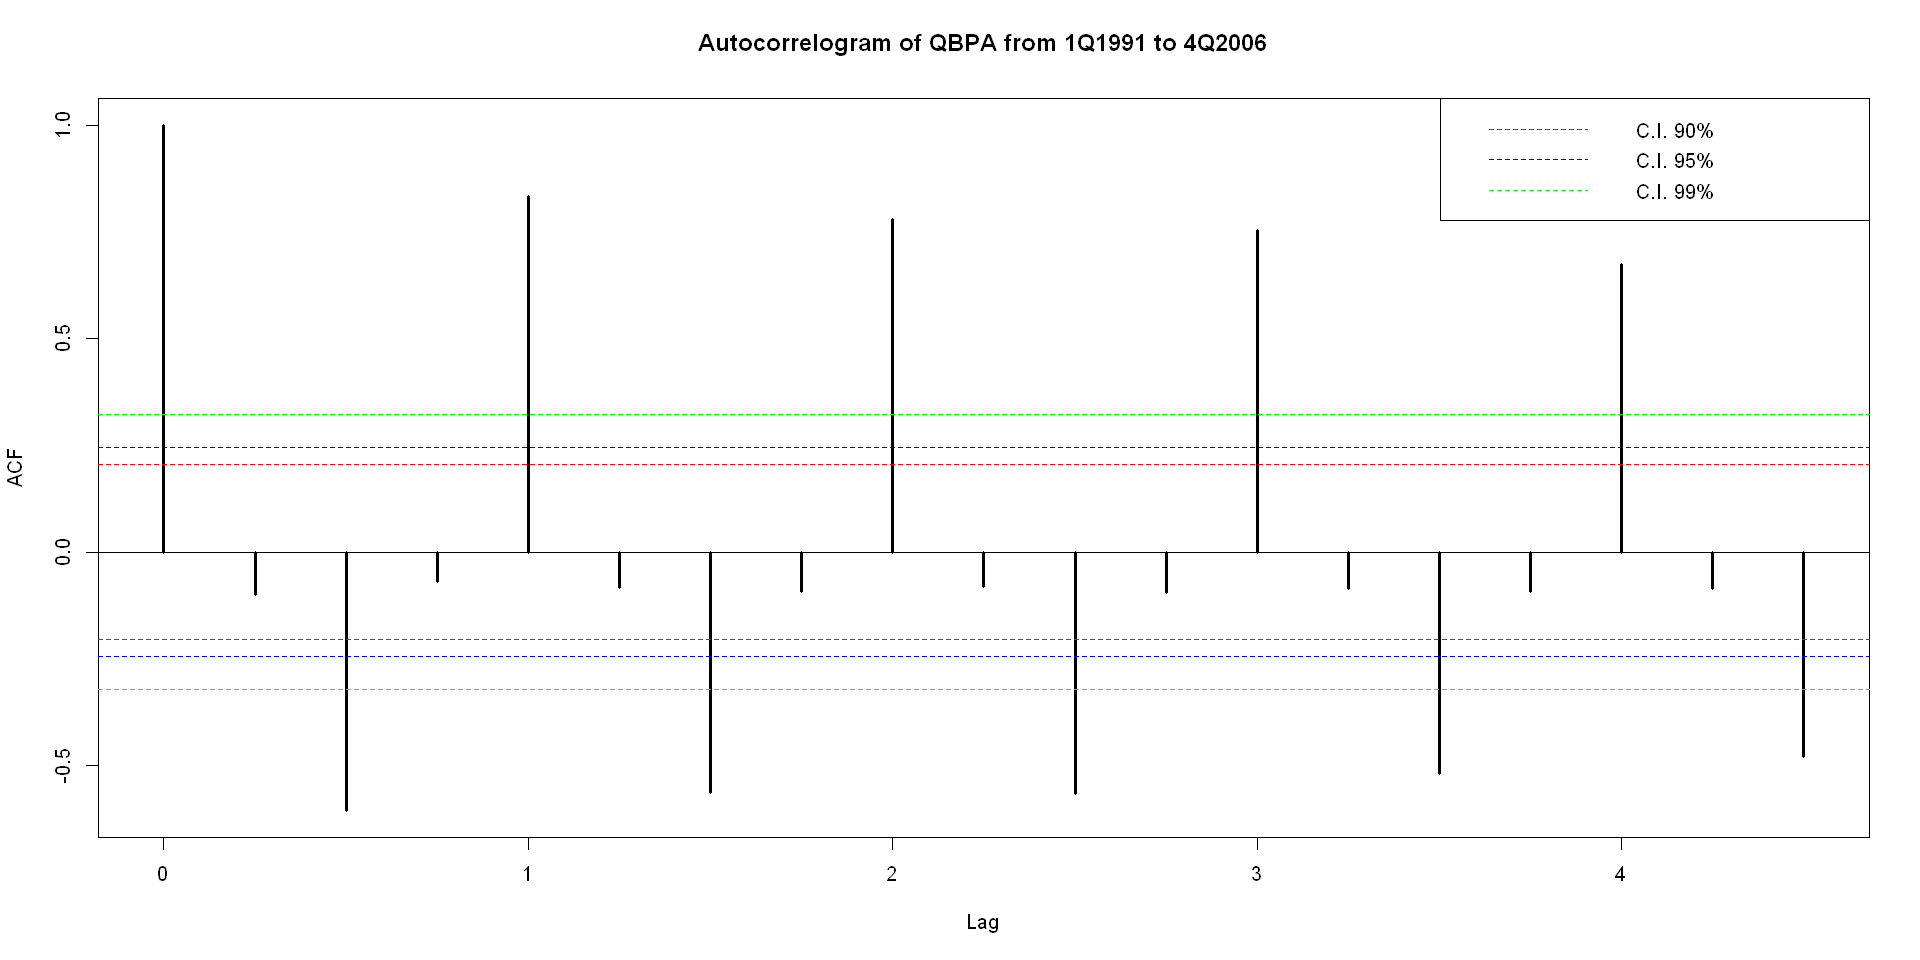

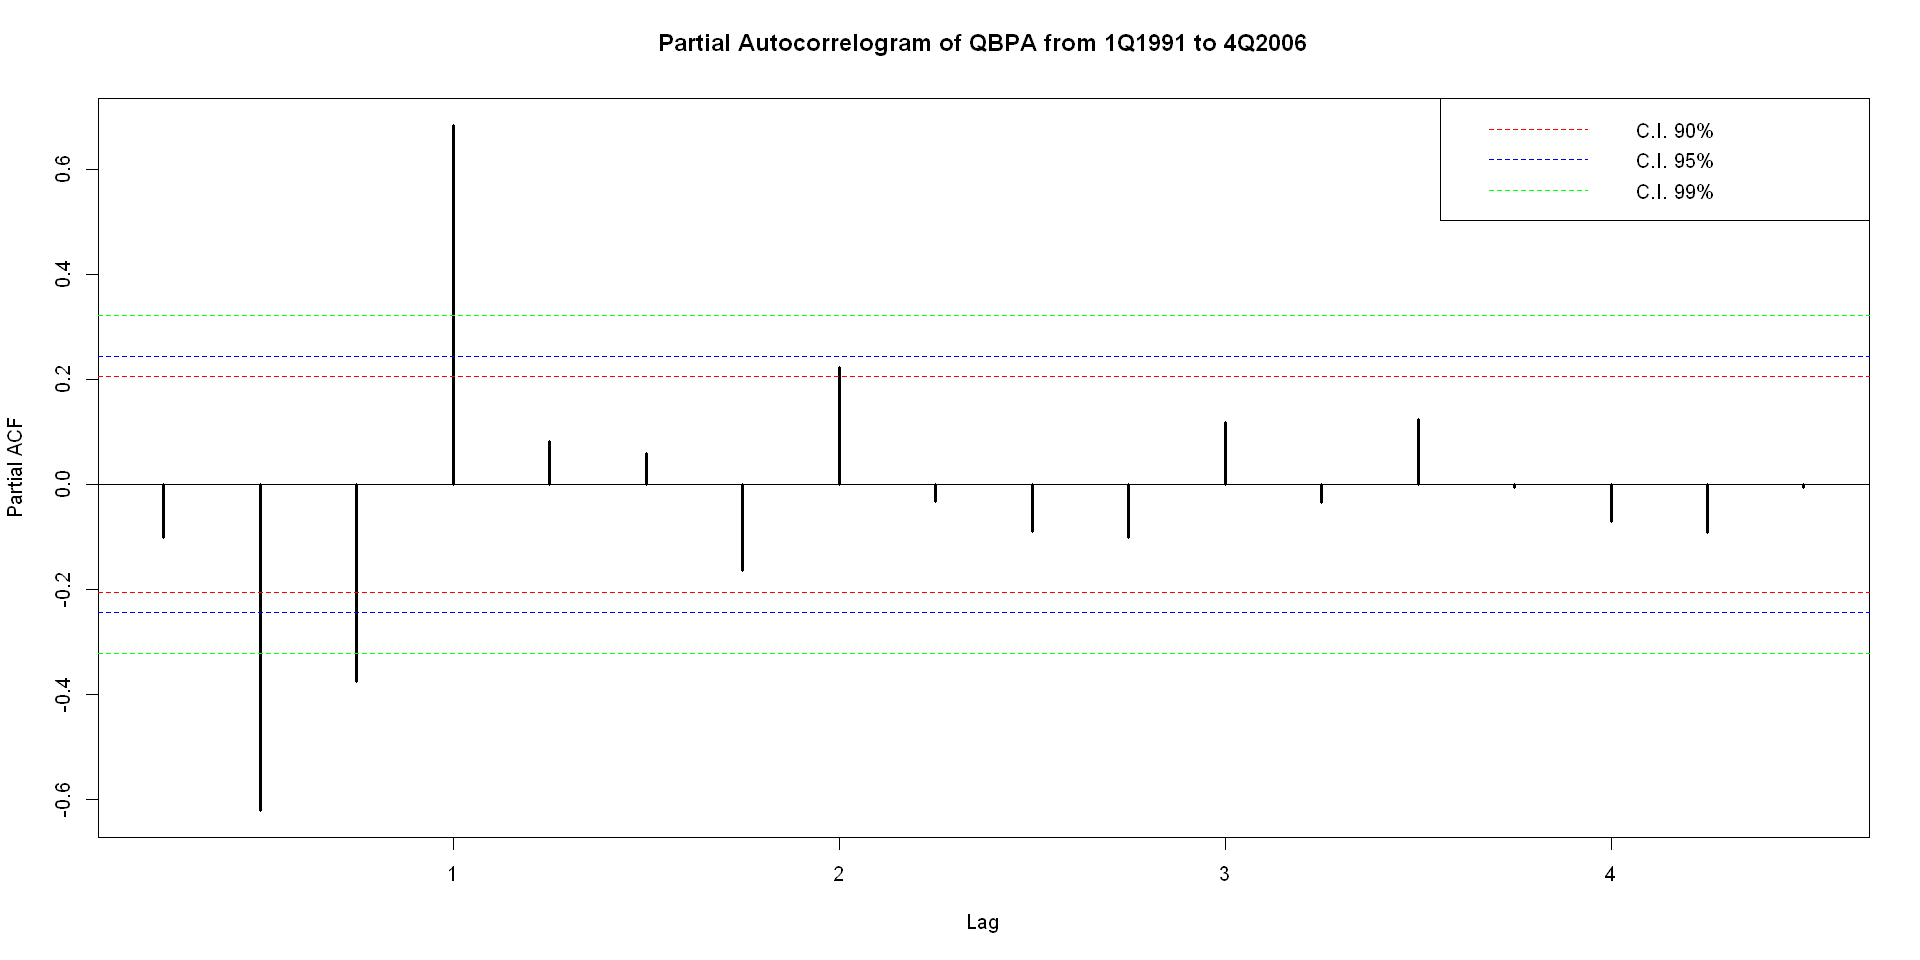

In [78]:
acf(ausbeer.cut.train, lwd=3,
    main="Autocorrelogram of QBPA from 1Q1991 to 4Q2006",
    ci = c(0.90,0.95, 0.99), ci.col=c("red", "blue", "green"),
    cex.axis=1, cex.main= 1.5, cex.sub = 1, cex.lab = 1)
legend("topright", 
       legend = c("C.I. 90%", "C.I. 95%", "C.I. 99%"), 
       col = c("red", "blue", "green"), lty=c(2,2,2))

pacf(ausbeer.cut.train, lwd=3,
    main="Partial Autocorrelogram of QBPA from 1Q1991 to 4Q2006",
    ci = c(0.90,0.95, 0.99), ci.col=c("red", "blue", "green"),
    cex.axis=1, cex.main= 1.5, cex.sub = 1, cex.lab = 1)
legend("topright", 
       legend = c("C.I. 90%", "C.I. 95%", "C.I. 99%"), 
       col = c("red", "blue", "green"), lty=c(2,2,2))

I grafici suggeriscono la presenza di processi autoregressivi e a media mobile di carattere stagionale oltre alla presenza di un processo autoregressivo di ordine due (o tre) di carattere non stagionale. Sulla base degli spike individuati decido dunque di provare un modello *SARIMA(3,0,0)(1,0,1)[4]*

*E' stato provato anche il modello SARIMA(2,0,0)(1,0,1)[4], tuttavia i suoi residui non rispecchiavano le caratteristiche ricercate, in particolare risultavano autocorrelati*

In [79]:
mod.train <- sarima(ausbeer.cut.train, p=3, d=0, q=0, P=1, D=0, Q=1, S=4, no.constant=TRUE, details=FALSE)

Una volta costruito il modello rappresento i residui e ne studio le proprietà come suggerito dalla procedura di Box e Jenkins

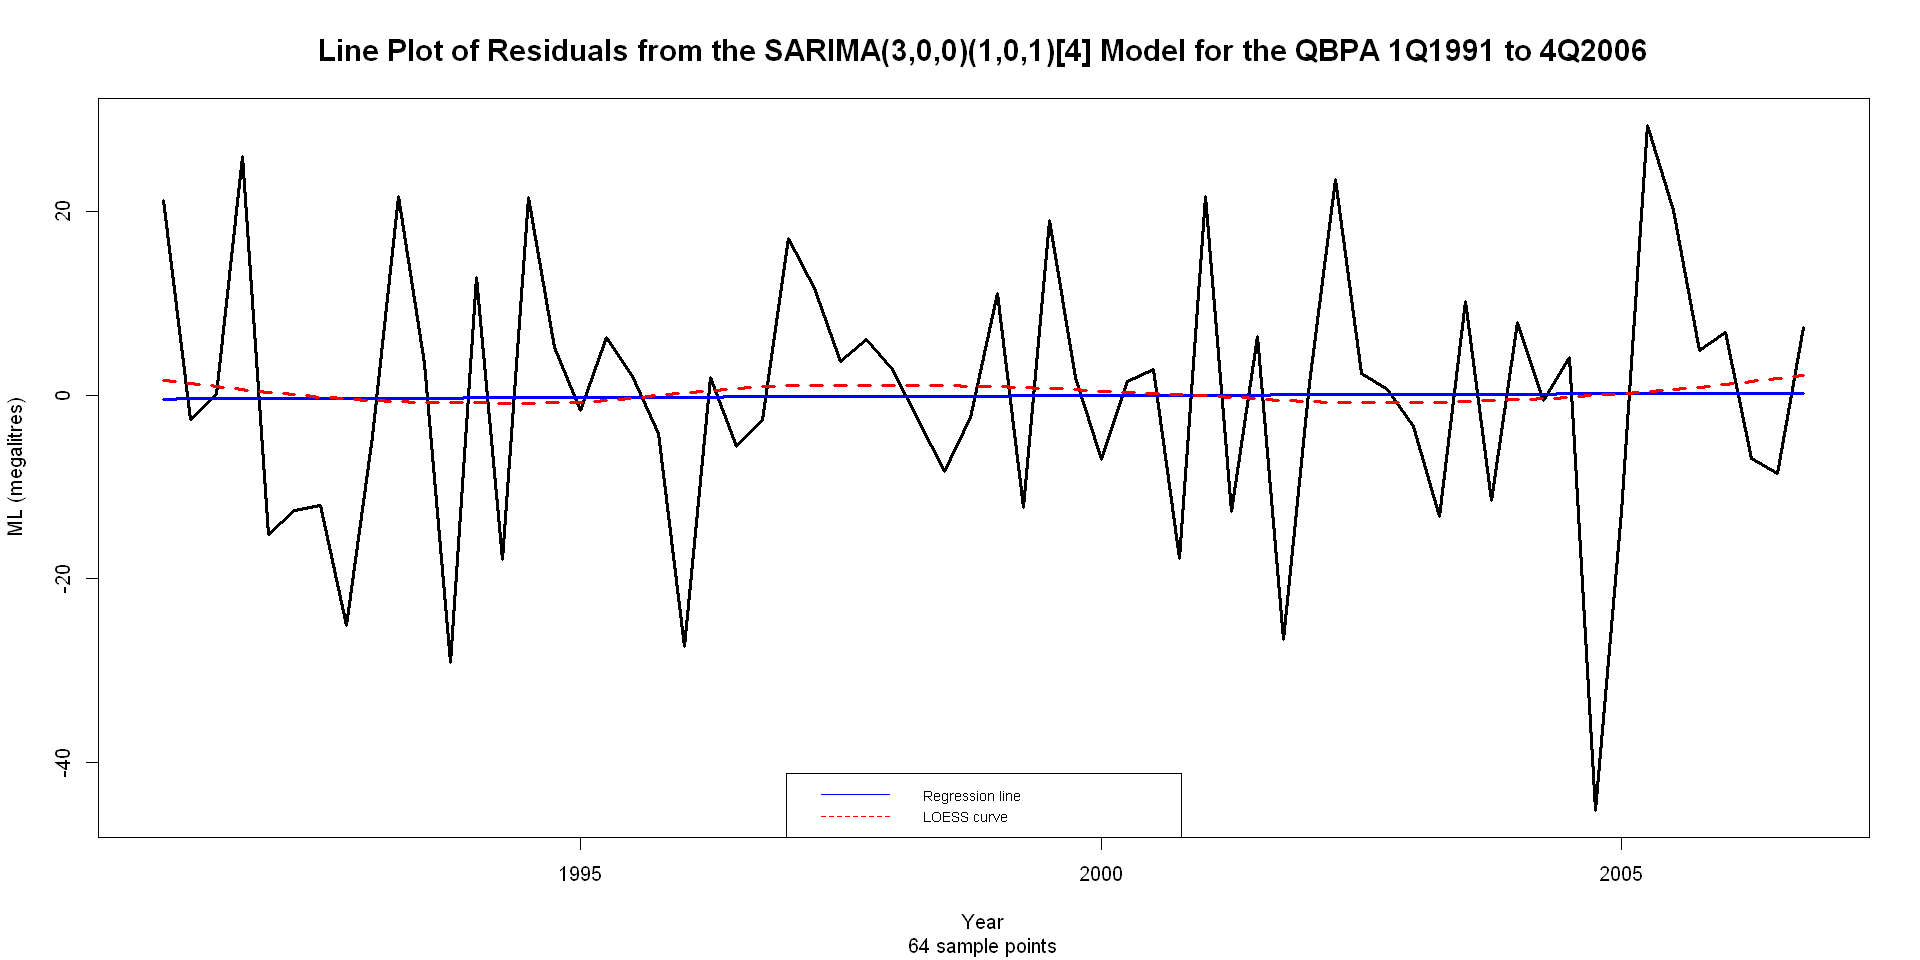

In [80]:
# PLOT
plot(mod.train$fit$residuals, type="l", lwd=3, 
     main = "Line Plot of Residuals from the SARIMA(3,0,0)(1,0,1)[4] Model for the QBPA 1Q1991 to 4Q2006",
     sub = paste(length(ausbeer.cut.train), "sample points", sep=" "),
     xlab = "Year", ylab = "ML (megalitres)", 
     cex.axis=1, cex.main= 1.5, cex.sub = 1, cex.lab = 1)
loess.fit <- ts(loess(coredata(mod.train$fit$residuals) ~ index(mod.train$fit$residuals), span = 0.8)$fitted, start = c(1991,1), frequency = 4)
lm.fit <- ts(lm(coredata(mod.train$fit$residuals) ~ index(mod.train$fit$residuals))$fitted.values, start = c(1991,1), frequency = 4)
lines(lm.fit, col = "blue", lwd=3)
lines(loess.fit, col = "red", lwd=3, lty=2)
legend("bottom", legend = c("Regression line", "LOESS curve"), cex = 0.7, col = c("blue","red"), lty=c(1,2))

In [81]:
summary(mod.train$fit)


Call:
stats::arima(x = xdata, order = c(p, d, q), seasonal = list(order = c(P, D, 
    Q), period = S), xreg = xmean, include.mean = FALSE, transform.pars = trans, 
    fixed = fixed, optim.control = list(trace = trc, REPORT = 1, reltol = tol))

Coefficients:
         ar1     ar2     ar3    sar1     sma1
      0.0864  0.3021  0.4686  0.9982  -0.6319
s.e.  0.1149  0.1045  0.1113  0.0021   0.0924

sigma^2 estimated as 206.5:  log likelihood = -271.12,  aic = 554.24

Training set error measures:
              ME RMSE MAE MPE MAPE
Training set NaN  NaN NaN NaN  NaN


#### 6.1.1 Scorrelazione

In prima battuta verifico se è stato risolto il problema dell'autocorrelazione facendo gli autocorrelogrammi dei residui del modello *SARIMA(3,0,0)(1,0,1)[4]* e i relativi test statistici.

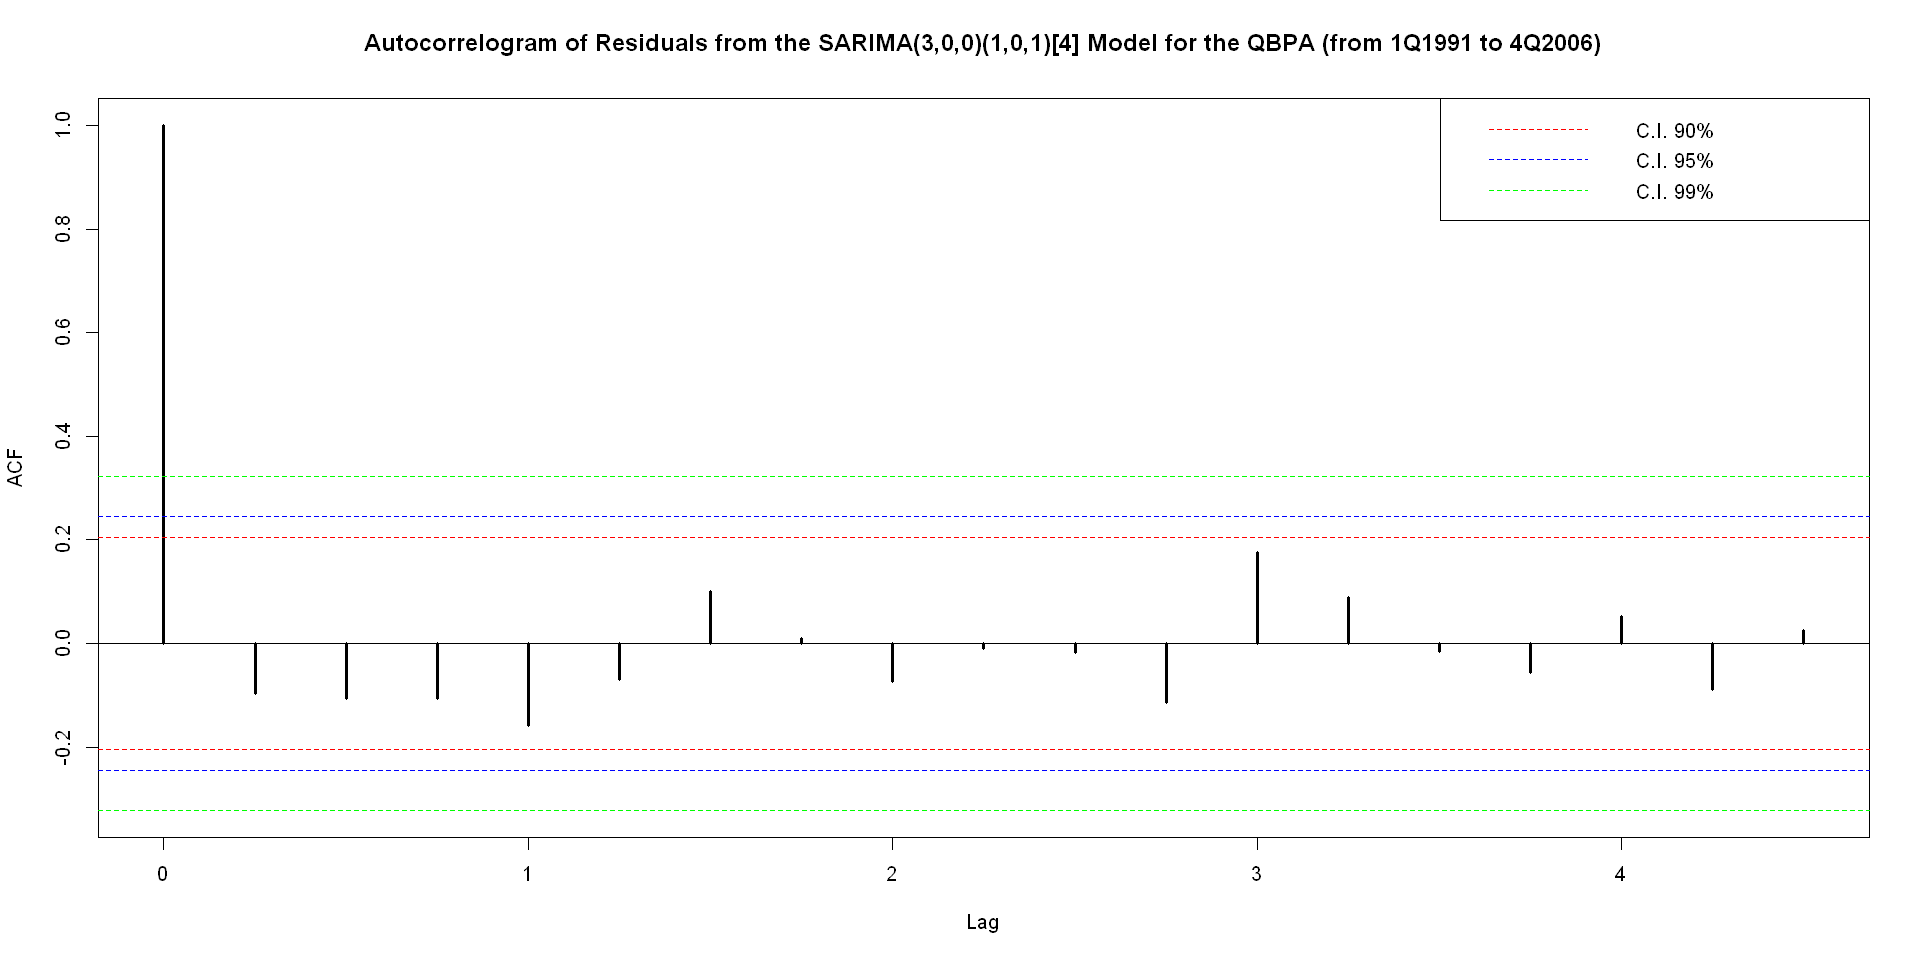

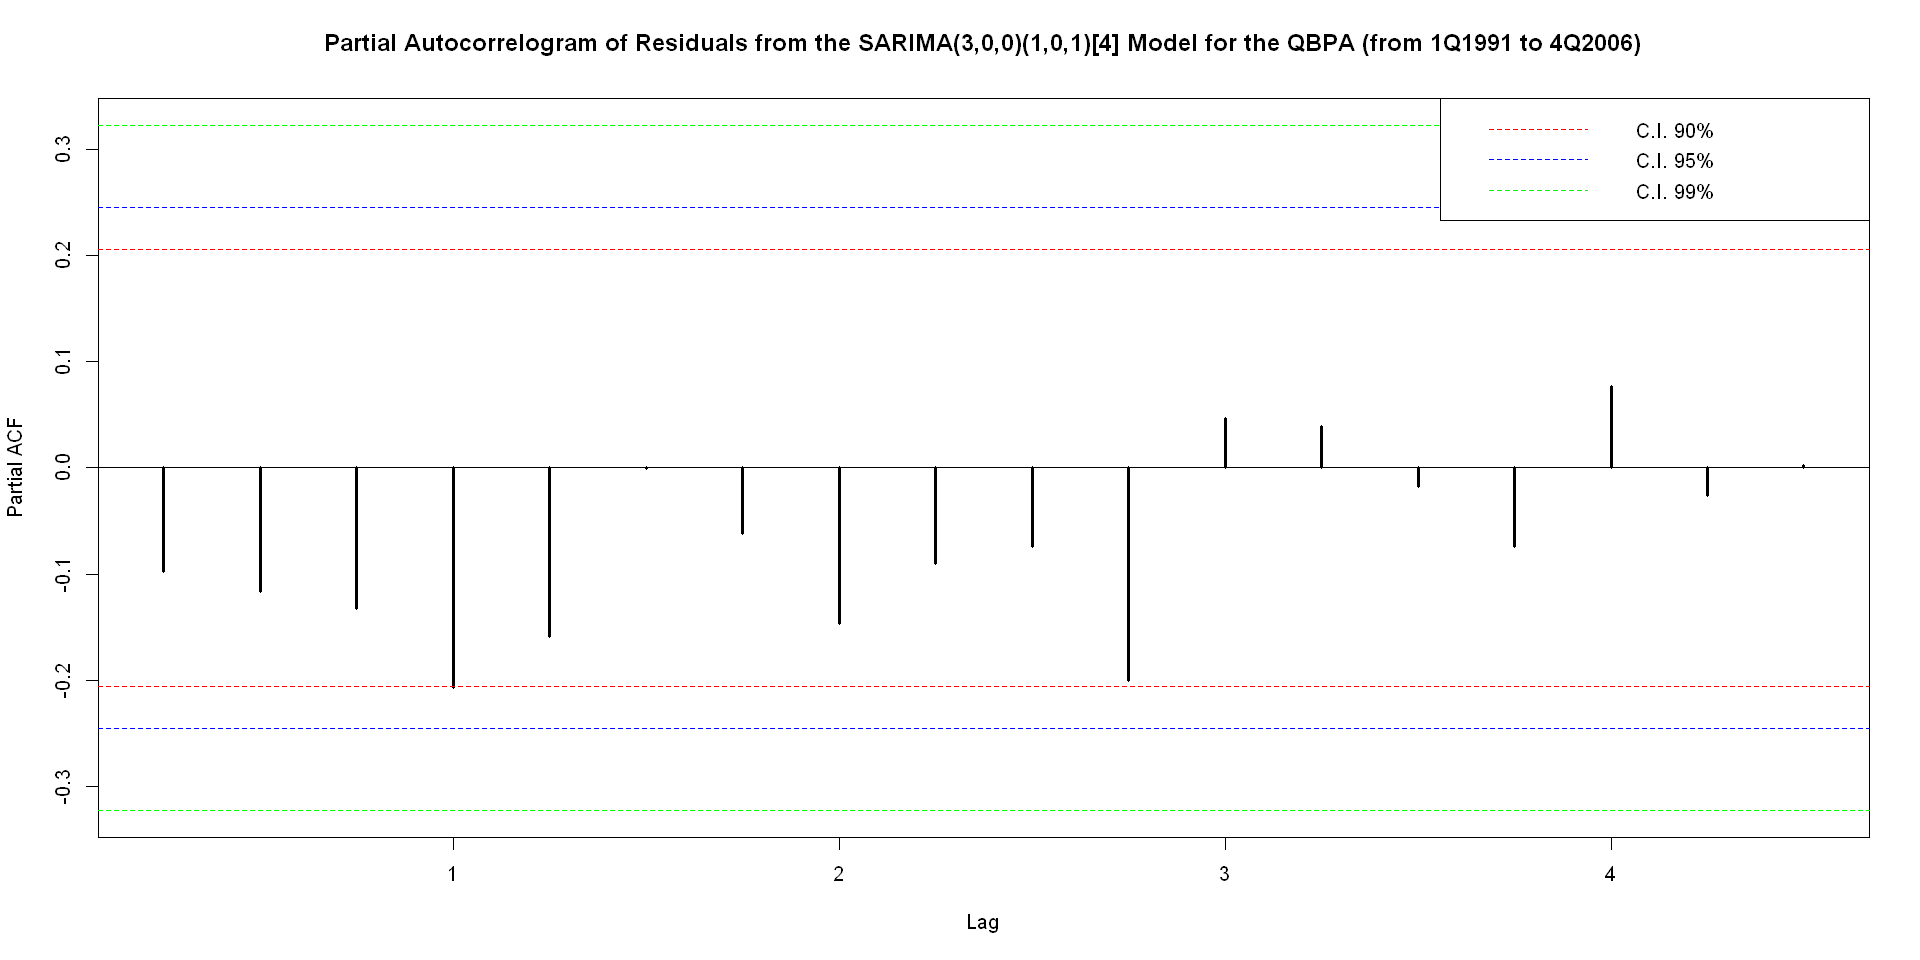

In [82]:
acf(mod.train$fit$residuals, lwd=3,
    main="Autocorrelogram of Residuals from the SARIMA(3,0,0)(1,0,1)[4] Model for the QBPA (from 1Q1991 to 4Q2006)",
    ci = c(0.90,0.95, 0.99), ci.col=c("red", "blue", "green"),
    cex.axis=1, cex.main= 1.5, cex.sub = 1, cex.lab = 1)
legend("topright", 
       legend = c("C.I. 90%", "C.I. 95%", "C.I. 99%"), 
       col = c("red", "blue", "green"), lty=c(2,2,2))
pacf(mod.train$fit$residuals, lwd=3,
     main = "Partial Autocorrelogram of Residuals from the SARIMA(3,0,0)(1,0,1)[4] Model for the QBPA (from 1Q1991 to 4Q2006)",
     ci = c(0.90,0.95, 0.99), ci.col=c("red", "blue", "green"),
     cex.axis=1, cex.main= 1.5, cex.sub = 1, cex.lab = 1)
legend("topright", 
       legend = c("C.I. 90%", "C.I. 95%", "C.I. 99%"), 
       col = c("red", "blue", "green"), lty=c(2,2,2))


In [83]:
mod.train.residuals.lm <- lm(coredata(mod.train$fit$residuals) ~ index(mod.train$fit$residuals))
Box.test(mod.train$fit$residuals, lag = 4, type = "Ljung-Box") ## H0: autocorrelations (for chosen lags) in the data is zero
dwtest(mod.train.residuals.lm, alternative="two.sided", exact = TRUE) # Durbin-Watson ## H0: residuals from an OLS regression are not autocorrelated
bgtest(mod.train.residuals.lm, order = 4, type = "Chisq") # Breusch-Godfrey ## H0: there is no serial correlation of any order up to p
bgtest(mod.train.residuals.lm, order = 4, type = "F")  # Breusch-Godfrey ## H0: there is no serial correlation of any order up to p


	Box-Ljung test

data:  mod.train$fit$residuals
X-squared = 3.9492, df = 4, p-value = 0.4129



	Durbin-Watson test

data:  mod.train.residuals.lm
DW = 2.1565, p-value = 0.6176
alternative hypothesis: true autocorrelation is not 0



	Breusch-Godfrey test for serial correlation of order up to 4

data:  mod.train.residuals.lm
LM test = 5.3005, df = 4, p-value = 0.2578



	Breusch-Godfrey test for serial correlation of order up to 4

data:  mod.train.residuals.lm
LM test = 1.3093, df1 = 4, df2 = 58, p-value = 0.2773


Sia gli autocorrelogrammi che i test statistici confermano l'eliminazione dell'autocorrelazione, fornendo un'evidenza congiunta sulla scorrelazione dei residui del modello *SARIMA(3,0,0)(1,0,1)[4]*

*Nota metodologica: è stato considerato un livello di significatività α=.05*

#### 6.1.2 Stazionarietà e omoschedasticità

Successivamente verifico la stazionarietà e l'omoschedasticità attraverso gli opportuni test statistici per avvalorare le ipotesi di stazionarietà e omoschedasticità che emergono in modo abbastanza evidente dall'analisi grafica.

In [84]:
#stazionarietà
adf.lags <- floor(12*(length(noise.model.alt$fit$residuals)/100)^1/4) # as suggested by Schwert 
adf.test(mod.train$fit$residuals, k=adf.lags) # Dickey-Fuller ## H0: the data are non-stationary
kpss.test(mod.train$fit$residuals) # Kwiatkowski, Phillips, Schmidt and Shin ## H0: time series is trend-stationary


	Augmented Dickey-Fuller Test

data:  mod.train$fit$residuals
Dickey-Fuller = -5.5592, Lag order = 2, p-value = 0.01
alternative hypothesis: stationary



	KPSS Test for Level Stationarity

data:  mod.train$fit$residuals
KPSS Level = 0.033153, Truncation lag parameter = 3, p-value = 0.1


*Nota metodologica: Applico i test non studentizzati perchè la normalità nel rumore è ragionevolmente rispettata (vedi sezione successiva)*

In [85]:
#omoschedasticità
bptest(mod.train.residuals.lm, studentize = FALSE) # Breusch-Pagan ## H0: Equal/constant variances
print("------ White test ------")
bptest(mod.train.residuals.lm,  ~ index(mod.train.residuals.lm) + I(index(mod.train.residuals.lm)^2) , studentize = FALSE) # White ## H0: Equal/constant variances
print("------ White-Wooldridge test ------")
bptest(mod.train.residuals.lm,  ~ mod.train.residuals.lm$fitted + I(mod.train.residuals.lm$fitted^2) , studentize = FALSE) # White-Wooldridge ## H0: Equal/constant variances


	Breusch-Pagan test

data:  mod.train.residuals.lm
BP = 0.008706, df = 1, p-value = 0.9257


[1] "------ White test ------"



	Breusch-Pagan test

data:  mod.train.residuals.lm
BP = 0.51742, df = 2, p-value = 0.772


[1] "------ White-Wooldridge test ------"



	Breusch-Pagan test

data:  mod.train.residuals.lm
BP = 2.2217, df = 2, p-value = 0.3293


I test statistici confermano l'ipotesi di stazionarietà e omoschedasticità

*Nota metodologica: è stato considerato un livello di significatività α=.05*

#### 6.1.3 Gaussianità

Infine verifico la gaussianità dei residui con il supporto degli opportuni test statistici e delle rappresentazioni grafiche

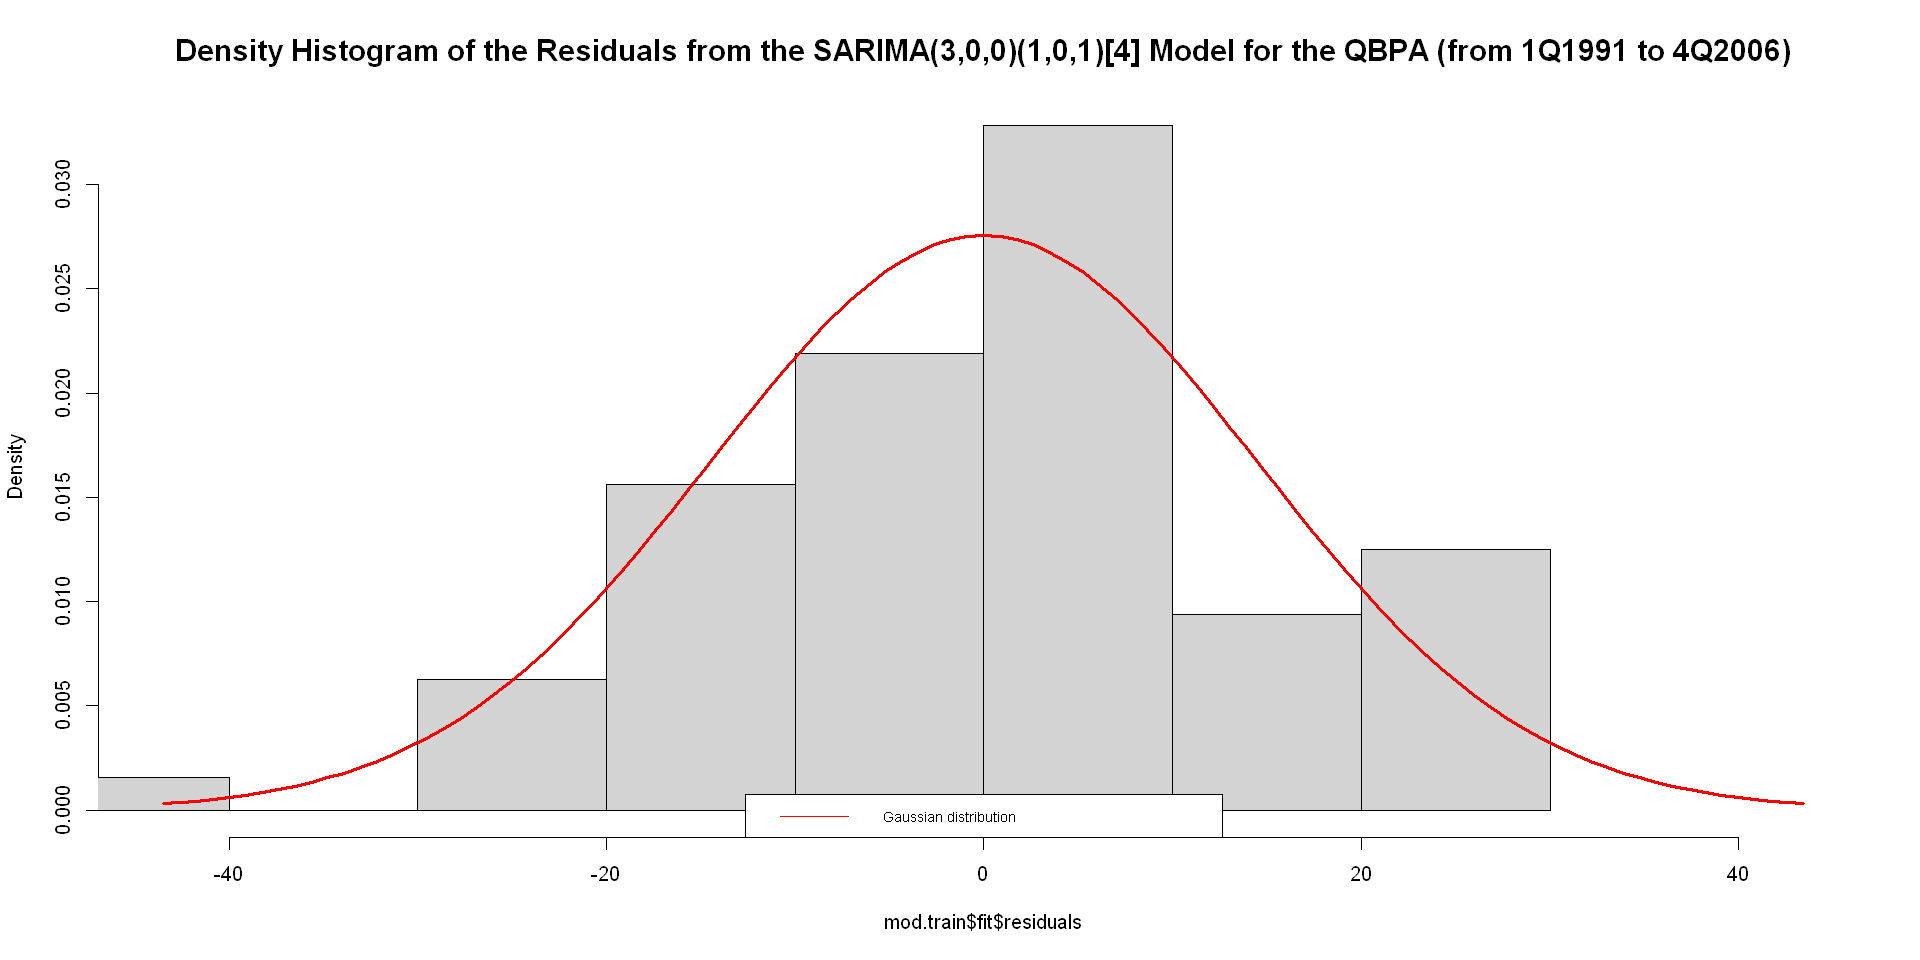

In [86]:
hist(mod.train$fit$residuals, freq = FALSE, frame.plot=TRUE, xlim=c(-3*sd(mod.train$fit$residuals),3*sd(mod.train$fit$residuals)),
     main="Density Histogram of the Residuals from the SARIMA(3,0,0)(1,0,1)[4] Model for the QBPA (from 1Q1991 to 4Q2006)",
     cex.axis=1, cex.main= 1.5, cex.sub = 1, cex.lab = 1)
curve(dnorm(x,mean=0,sd=sd(mod.train$fit$residuals)), add=TRUE,col="red", lwd=3)
legend("bottom", legend = "Gaussian distribution", cex = 0.7, col = "red", lty=c(1,2))

In [87]:
mod.train.skew <- skewness(mod.train$fit$residuals) #theo 0
mod.train.kurt <- kurtosis(mod.train$fit$residuals) # theo 3
print(cbind(mod.train.skew,mod.train.kurt))

     mod.train.skew mod.train.kurt
[1,]     -0.3871458      0.4121651


La distirbuzione appare platicurtica e sostanzialmente simmetrica 

[1] 56 58

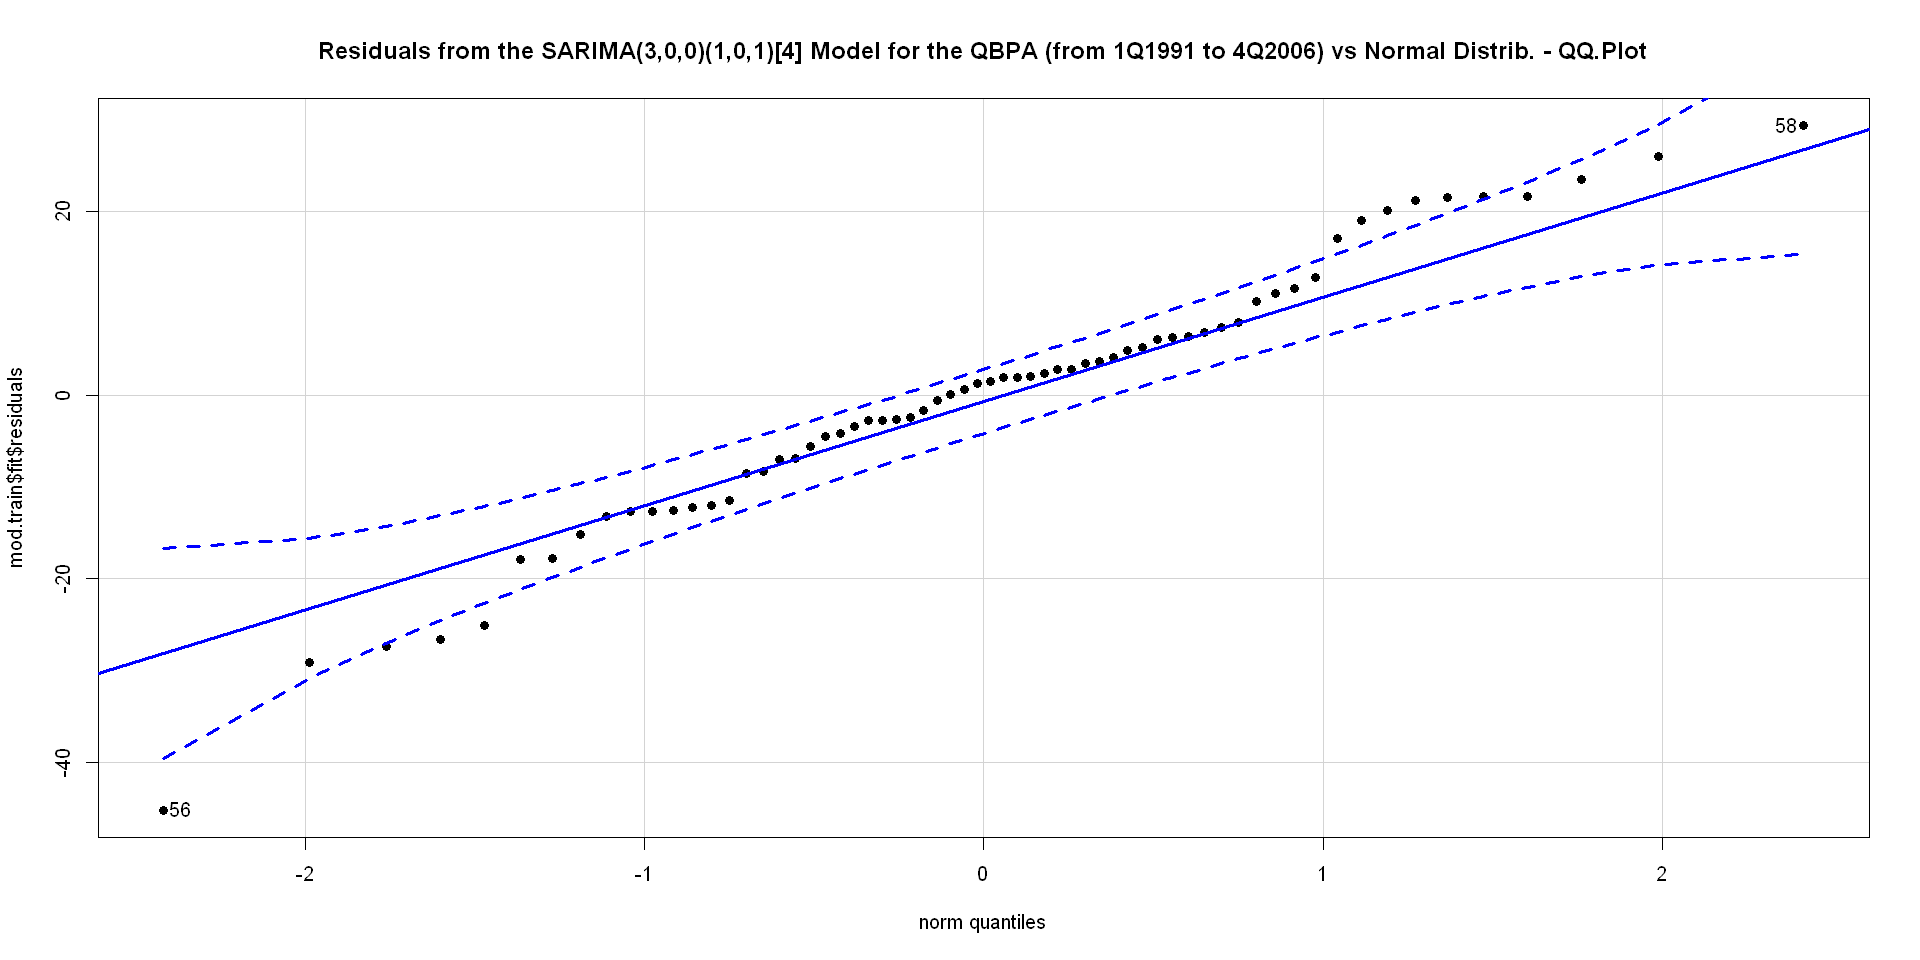

In [88]:
qqPlot(mod.train$fit$residuals, lwd=3, pch=16,
      main="Residuals from the SARIMA(3,0,0)(1,0,1)[4] Model for the QBPA (from 1Q1991 to 4Q2006) vs Normal Distrib. - QQ.Plot")

In [89]:
# Test di normalità
jarque.bera.test(mod.train$fit$residuals) # Jarque-Bera ## H0: The data is normally distributed.
shapiro.test(mod.train$fit$residuals) # Shapiro-Wilks ## H0: The data is normally distributed.
dagoTest(mod.train$fit$residuals) # D’Agostino Pearson ## H0: The data is normally distributed.


	Jarque Bera Test

data:  mod.train$fit$residuals
X-squared = 2.4009, df = 2, p-value = 0.3011



	Shapiro-Wilk normality test

data:  mod.train$fit$residuals
W = 0.9759, p-value = 0.2431



Title:
 D'Agostino Normality Test

Test Results:
  STATISTIC:
    Chi2 | Omnibus: 3.2938
    Z3  | Skewness: -1.3788
    Z4  | Kurtosis: 1.1802
  P VALUE:
    Omnibus  Test: 0.1926 
    Skewness Test: 0.168 
    Kurtosis Test: 0.2379 

Description:
 Tue Dec 22 23:14:30 2020 by user: Marco


Sebbene la distribuzione dei residui non rispecchi in toto una distribuzione gaussiana teorica, alla luce dei test statistici è possibile ipotizzare che la distribuzione sia ragionevolmente assimilabile a una distirbuzione normale.

*Nota metodologica: è stato considerato un livello di significatività α=.05*

#### 6.1.4 Conclusioni

Alla luce di tutte le evidenze raccolte il modello *SARIMA(3,0,0)(1,0,1)[4]* risulta essere un buon modello per la serie storica in analisi in quanto i suoi residui rispettano ampiamente tutte le caratteristiche del *white noise gaussiano*.

### 6.2 Forecast

Verificata la bontà del modello *SARIMA(3,0,0)(1,0,1)[4]* lo applico alla serie storica e confronto i risultati della previsione con quelli reali

In [90]:
ausbeer.cut.forecast <-forecast(ausbeer.cut.train, model = mod.train$fit, h=length(ausbeer.cut.test), level = c(90, 95, 99))

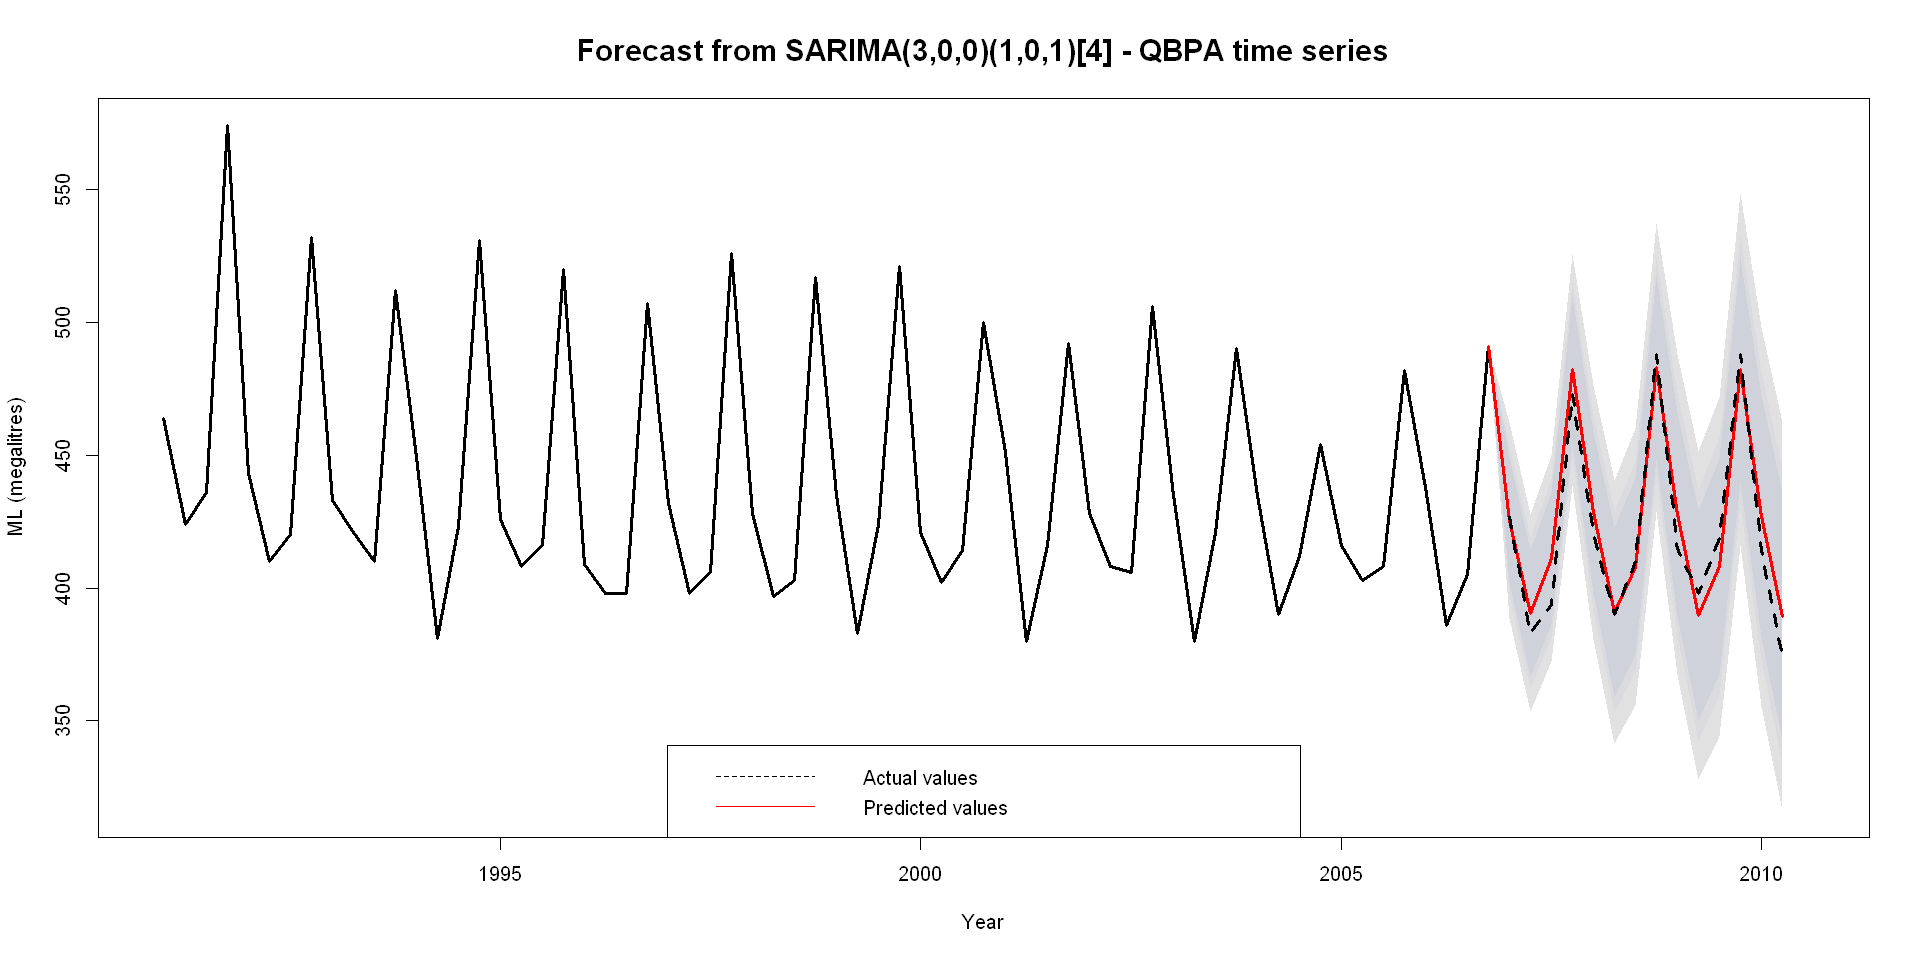

In [91]:
plot(ausbeer.cut.forecast, showgap=FALSE, lwd=3, flwd=3, fcol="red",
     main = "Forecast from SARIMA(3,0,0)(1,0,1)[4] - QBPA time series",
     xlab = "Year", ylab = "ML (megalitres)",
     cex.axis=1, cex.main= 1.5, cex.sub = 1, cex.lab = 1)
lines(ausbeer.cut.test,col="black", lwd=3, lty=2)
legend("bottom", legend = c("Actual values", "Predicted values"), cex = 1, col = c("black","red"), lty=c(2,1))

Il modello *SARIMA(3,0,0)(1,0,1)[4]* sembra performare bene in fase di predizione: tutti i valori osservati sono quasi sovrapposti a quelli previsti e cadono all'interno dell'intervallo di confidenza del forecast.

[Torna all'indice](#Indice)